In [19]:
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import joblib
from sentence_transformers import SentenceTransformer, util
import time
import torch
from tqdm.auto import tqdm
import re
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
import hdbscan
from hdbscan import HDBSCAN
from bertopic import BERTopic
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from sklearn.metrics import ndcg_score
from datetime import datetime
import spacy


load file from OpenAlex using specific filter search

In [2]:
# OpenAlex API URL
url = "https://api.openalex.org/works"
email = "moroni.simone@studenti.luiss.it"

# Numero massimo di pagine da scaricare
num_pages = 45  
articles = []

for page in range(1, num_pages + 1):
    params = {
        "filter": "type:article,publication_year:>2014",
        "search": "(AI OR artificial intelligence) AND (pricing OR promotion OR discount OR dynamic pricing) AND (GDO OR retail OR supermarket OR large-scale distribution)",
        "sort": "relevance_score:desc",
        "per_page": 200,
        "page": page,
        "mailto": email,
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        if "results" in data and data["results"]:
            articles.extend(data["results"])
        else:
            print("Nessun articolo trovato.")
            break  
    else:
        print(f"Errore nella richiesta: {response.status_code}")
        break  

    time.sleep(5)

if not articles:
    print("Nessun articolo recuperato.")
    exit()

def extract_authors(authors_list):
    return [author["author"]["display_name"] for author in authors_list] if authors_list else []

def extract_abstract(inverted_index):
    if isinstance(inverted_index, dict):  
        words = {pos: word for word, positions in inverted_index.items() for pos in positions}
        return ' '.join(words[pos] for pos in sorted(words))  
    return None  

# Creazione DataFrame con solo i campi essenziali
df = pd.DataFrame({
    "title": [article.get("title") for article in articles],
    "authors": [extract_authors(article.get("authorships", [])) for article in articles],
    "abstract": [extract_abstract(article.get("abstract_inverted_index")) for article in articles],
    "year": [article.get("publication_year") for article in articles],
    "doi": [article.get("doi", "").replace("https://doi.org/", "") if article.get("doi") else "" for article in articles],
})

df.to_csv("openalex_articles_copy.csv", index=False)
print("Dati salvati in 'openalex_articles_copy.csv'")

Dati salvati in 'openalex_articles_copy.csv'


# Data Cleaning

In [15]:
#  Carica il dataset (CSV salvato da OpenAlex)
df = pd.read_csv("openalex_articles_copy.csv")

In [16]:
total_articles = len(df)
print(f"Totale articoli processati: {total_articles}")

print(df.info())
print(df.sample(3))

Totale articoli processati: 9000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     9000 non-null   object
 1   authors   9000 non-null   object
 2   abstract  6439 non-null   object
 3   year      9000 non-null   int64 
 4   doi       8993 non-null   object
dtypes: int64(1), object(4)
memory usage: 351.7+ KB
None
                                                  title  \
5824  Towards digital organized crime and digital so...   
326   Fintech and regtech: Impact on regulators and ...   
1845  Invention, Innovation Systems, and the Fourth ...   

                          authors  \
5824         ['Andrea Di Nicola']   
326   ['Ioannis Anagnostopoulos']   
1845         ['Arthur Daemmrich']   

                                               abstract  year  \
5824  Abstract As technology has changed people’s li...  2022   
326                   

cleaning the data

In [18]:
#Check missing values
missing_values=df.isnull().sum()
print('Missing Values summary:',missing_values,sep=' ')

Missing Values summary: title          0
authors        0
abstract    2561
year           0
doi            7
dtype: int64


In [19]:
# Valuto articoli scartati per presenza di NAN values
discarded_articles = len(df[df["abstract"].isna() | df["title"].isna()| df["authors"].isna()| df["year"].isna()| df["doi"].isna()])
print(f"Articoli scartati: {discarded_articles} ({discarded_articles/total_articles:.2%})")


Articoli scartati: 2568 (28.53%)


In [20]:
#Drop Invalid Rows
df=df.dropna()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6432 entries, 0 to 8999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     6432 non-null   object
 1   authors   6432 non-null   object
 2   abstract  6432 non-null   object
 3   year      6432 non-null   int64 
 4   doi       6432 non-null   object
dtypes: int64(1), object(4)
memory usage: 301.5+ KB
None


Transform the dataset into parquet format for faster querying and loading.

In [20]:
# save to parquet. Run only first time
#df.to_parquet("openalex_articles_copy.parquet", index=False)

df = pd.read_parquet("openalex_articles_copy.parquet")


In [21]:
#Check missing values
missing_values=df.isnull().sum()
print('Missing Values summary:',missing_values,sep=' ')
df.sample(3)

Missing Values summary: title       0
authors     0
abstract    0
year        0
doi         0
dtype: int64


,title,authors,abstract,year,doi
3267,Software-Defined Networking Meets Software-Def...,"['Dimitrios Kafetzis', 'Spyridon Vassilaras', ...",The aims of this survey article are to elabora...,2022,10.1109/access.2022.3144072
2347,Nature-Inspired Metaheuristic Regression Syste...,"['Jui‐Sheng Chou', 'Wai K. Chong', 'Dac-Khuong...",Developing an expert system has been considere...,2016,10.1061/(asce)cp.1943-5487.0000561
4162,International Open Innovation Strategies of Fi...,"['Jo�ão M. Lopes', 'Sofia Gomes', 'José Olivei...",The involvement of companies in different open...,2022,10.3390/joitmc8010007


In [22]:
# valuto dimensioni dataset finale
total_articles = len(df)
print(f"Totale articoli processati: {total_articles}")

Totale articoli processati: 6432


# Pulizia cache

da runnare solo se hai cambiato dimensione del dataset. in tal caso pulisci cache e runna tutto a capo. questi embeddings_cache servono per embedding model comparison (calcolati su un subset)

In [11]:
def clear_embeddings_cache(cache_dir='embeddings_cache'):
    """Pulisce tutti i file di cache degli embeddings."""
    import shutil
    if os.path.exists(cache_dir):
        print(f"Eliminazione della directory cache: {cache_dir}")
        shutil.rmtree(cache_dir)
        os.makedirs(cache_dir, exist_ok=True)
        print("Cache svuotata con successo.")
    else:
        print(f"Nessuna directory cache {cache_dir} trovata.")
        os.makedirs(cache_dir, exist_ok=True)
        print(f"Creata nuova directory cache: {cache_dir}")

In [12]:
clear_embeddings_cache()

Nessuna directory cache embeddings_cache trovata.
Creata nuova directory cache: embeddings_cache


#

CREO SUBSET RAPPRESENTATIVO che ci serve per evaluation dei model embeddings.

In [5]:
# Crea un subset rappresentativo per i test di embedding
subset_df = df.sample(frac=0.2, random_state=11)
print(f"Subset creato con {len(subset_df)} articoli (20% del dataset originale)")

Subset creato con 1286 articoli (20% del dataset originale)


Funzione per caricare embeddings se già salvati su disco. la utilizziamo dopo per evitare di ricalcolar embeddings (se già  presenti).

In [6]:
def load_cached_embeddings(model_name, full_dataset=False):
    """
    Carica embeddings salvati in cache per un modello specifico.
    Versione semplificata che gestisce solo embeddings parziali.
    
    Args:
        model_name (str): Nome del modello di embedding
        full_dataset (bool): Flag che indica se si stanno cercando embeddings completi (ignorato in questa versione)
        
    Returns:
        tuple: (embeddings, embedding_model) se trovati, altrimenti (None, None)
    """
    import joblib
    import os
    
    # La funzione ora gestisce solo embeddings parziali
    if not model_name:
        print("Errore: È necessario specificare model_name per caricare embeddings parziali")
        return None, None
    
    # Costruisci il nome del file per gli embeddings parziali
    cache_dir = 'embeddings_cache'
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir, exist_ok=True)
    
    embeddings_file = f"{cache_dir}/{model_name.replace('/', '_')}_embeddings.pkl"
    
    # Controlla se il file esiste
    if os.path.exists(embeddings_file):
        print(f"Trovati embeddings salvati per il modello {model_name}")
        try:
            embeddings = joblib.load(embeddings_file)
            return embeddings, None
        except Exception as e:
            print(f"Errore nel caricamento degli embeddings: {e}")
            return None, None
    
    # File non trovato
    print(f"Nessun embedding salvato trovato per il modello {model_name}")
    return None, None

Siccome il topic model veniva inquinato da embedding non preprocessati, abbiamo separato gli embeddings. Gli embeddings poco puliti vengono utilizzati per clusterizzare i documenti (Catturare cosi il significato semantico completo del testo). Gli embeddings puliti invece vengono uilizzati per determinare le parole chiave dei cluster, rappresentando il contenuto di ciascun topic.

Preparo i documenti preprocessando gli articoli nel subset

In [32]:
# Preprocessing minimo per embedding
def minimal_preprocessing(text):
    if not isinstance(text, str):
        return ""
    # Normalizzazione base
    text = text.lower()
    # Rimuovi caratteri speciali ma mantieni la struttura
    text = re.sub(r'[^\w\s\.]', ' ', text)
    # Rimuovi spazi multipli
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

#Embeddings per Bertopic
# Pulizia da step words e lemmatizzazione
nlp = spacy.load("en_core_web_sm")  

def enhanced_text_cleaning(text):
    # Rimuovi stop words più specifiche del dominio
    custom_stopwords = ['data','datum', 'study', 'research', 'paper', 'analysis', 'method', 'technology','model','result','new', 'use', 'task']
    
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if 
              not token.is_stop 
              and not token.is_punct 
              and not token.like_num 
              and len(token.text) > 1
              and token.lemma_ not in custom_stopwords]
    return " ".join(tokens)


#Applico pulizia
# Crea due versioni del testo
subset_embedding_texts = []
subset_topic_texts = []

for _, row in subset_df.iterrows():
    # Versione per embedding (preprocessing minimo)
    title_emb = minimal_preprocessing(row['title'])
    abstract_emb = minimal_preprocessing(row['abstract'])
    embedding_text = f"{title_emb} {abstract_emb}"
    subset_embedding_texts.append(embedding_text)
    
    # Versione per topic modeling (preprocessing completo)
    title_topic = enhanced_text_cleaning(row['title'])
    abstract_topic = enhanced_text_cleaning(row['abstract'])
    topic_text = f"{title_topic} {abstract_topic}"
    subset_topic_texts.append(topic_text)

# Evaluate best embedding model

Confrontiamo diversi modelli di embeddings, valutandoli su un subset rappresentativo (20%), usando bert topic per clustering e scegliendo come metrica di valutazione una score che tiene conto di topic_diversity, coherence...

In [33]:
def calculate_topic_coherence(topic_model, texts, topic_id):
    """
    Calcola la coerenza di un topic basata sulla co-occorrenza delle parole top.
    
    Returns:
        Valore di coerenza (più alto = più coerente)
    """
    if topic_id == -1:
        return 0.0
        
    # Ottieni le parole principali del topic
    top_words = [word for word, _ in topic_model.get_topic(topic_id)][:10]
    
    if not top_words:
        return 0.0
        
    # Crea un contatore di co-occorrenze
    from collections import Counter
    word_counts = Counter()
    cooccurrence_counts = Counter()
    
    # Conta le occorrenze e co-occorrenze
    for text in texts:
        text_words = set(text.lower().split())
        
        # Conta parole individuali
        for word in top_words:
            if word.lower() in text_words:
                word_counts[word] += 1
                
        # Conta co-occorrenze di coppie
        for i, word1 in enumerate(top_words):
            for word2 in top_words[i+1:]:
                if word1.lower() in text_words and word2.lower() in text_words:
                    cooccurrence_counts[(word1, word2)] += 1
    
    # Calcola un punteggio di coerenza basato su PMI semplificato
    n_docs = len(texts)
    pmi_scores = []
    
    for i, word1 in enumerate(top_words):
        for word2 in top_words[i+1:]:
            # Salta se una delle parole non appare
            if word_counts[word1] == 0 or word_counts[word2] == 0:
                continue
                
            # Calcola PMI: log(P(x,y)/(P(x)*P(y)))
            p_word1 = word_counts[word1] / n_docs
            p_word2 = word_counts[word2] / n_docs
            p_both = cooccurrence_counts[(word1, word2)] / n_docs
            
            # Evita divisione per zero
            if p_both > 0:
                pmi = np.log(p_both / (p_word1 * p_word2))
                pmi_scores.append(pmi)
    
    # Normalizza e restituisci la media dei punteggi PMI
    if pmi_scores:
        return np.mean(pmi_scores)
    else:
        return 0.0


In [34]:
# Lista di modelli da valutare
models_to_evaluate = [
    'sentence-transformers/all-MiniLM-L6-v2',
    'sentence-transformers/all-mpnet-base-v2',
    'sentence-transformers/distiluse-base-multilingual-cased-v1',
    'sentence-transformers/paraphrase-albert-small-v2',
]

print(f"Iniziando la valutazione di {len(models_to_evaluate)} modelli di embedding...")

Iniziando la valutazione di 4 modelli di embedding...


Funzione per confrontare i modelli e stampo i risultati. le metriche di valutazione sono coerenza, topic diversity e percentuale di outlier .

In [35]:
def evaluate_embedding_with_bertopic(model_name, embeddings, topic_texts, sample_size=1000, random_seed=11):
    """
    Valuta un modello di embedding usando direttamente BERTopic con embeddings precalcolati.
    """

    # Imposta un seed fisso per la riproducibilità
    np.random.seed(random_seed)
    random.seed(random_seed)

    # Campiona i testi e gli embeddings se necessario
    if len(topic_texts) > sample_size:
        indices = np.random.choice(len(topic_texts), sample_size, replace=False)
        sampled_topic_texts = [topic_texts[i] for i in indices]
        sampled_embeddings = embeddings[indices]
    else:
        sampled_topic_texts = topic_texts
        sampled_embeddings = embeddings

    try:
        print(f"Valutazione di {model_name} su {len(sampled_topic_texts)} documenti usando embeddings calcolati...")

        # Crea UMAP con random_state impostato per riproducibilità
        dimensionality_reduction = umap.UMAP(
            n_neighbors=15,
            n_components=5,
            min_dist=0.0,
            metric='cosine',
            random_state=random_seed  # Importante!
        )

        # Crea HDBSCAN con un seed deterministico se possibile
        try:
            hdbscan_model = hdbscan.HDBSCAN(
                min_cluster_size=15, 
                min_samples=10, 
                prediction_data=True,
                cluster_selection_method='eom'
            )
        except TypeError:
            # Se HDBSCAN non accetta questi parametri
            hdbscan_model = hdbscan.HDBSCAN(
                min_cluster_size=15, 
                min_samples=10, 
                prediction_data=True
            )

        # Crea un modello BERTopic con parametri standard
        topic_model = BERTopic(
            embedding_model=None,
            umap_model=dimensionality_reduction,
            hdbscan_model=hdbscan.HDBSCAN(min_cluster_size=15, min_samples=10, prediction_data=True),
            min_topic_size=10,
            nr_topics='auto',
            verbose=True
        )
        # Addestra il modello usando embeddings pre-calcolati e testi per topic modeling
        topics, probs = topic_model.fit_transform(sampled_topic_texts, embeddings=sampled_embeddings)

        # Ottieni informazioni sui topic
        topic_info = topic_model.get_topic_info()

        # Calcola metriche base
        num_topics = len(topic_info[topic_info['Topic'] != -1])
        outlier_count = topic_info.loc[topic_info['Topic'] == -1, 'Count'].values[0] if -1 in topic_info['Topic'].values else 0
        outlier_percentage = outlier_count / len(sampled_topic_texts)

        # Statistiche sui topic
        topic_sizes = topic_info[topic_info['Topic'] != -1]['Count'].tolist()
        avg_topic_size = np.mean(topic_sizes) if topic_sizes else 0
        topic_size_std = np.std(topic_sizes) if len(topic_sizes) > 1 else 0

        # Calcola la diversità dei topic usando c-TF-IDF
        topic_vectors = []
        unique_topics = [t for t in set(topics) if t != -1]

        for topic_id in unique_topics:
            topic_words = topic_model.get_topic(topic_id)
            if topic_words:
                topic_vec = {word: weight for word, weight in topic_words}
                topic_vectors.append(topic_vec)

        # Calcola la diversità dei topic in un modo alternativo
        topic_diversity = 0
        unique_topics = [t for t in set(topics) if t != -1]
        if len(unique_topics) > 1:
            # Calcola la similarità utilizzando la matrice di parole-topic
            from collections import Counter
            
            # Raccogli tutte le parole importanti per ciascun topic
            topic_word_sets = {}
            for topic_id in unique_topics:
                words = [word for word, _ in topic_model.get_topic(topic_id)[:20]]  # Prendi le top 20 parole
                topic_word_sets[topic_id] = set(words)
            
            # Calcola sovrapposizione media (Jaccard similarity)
            similarities = []
            for i, topic_id1 in enumerate(unique_topics):
                for j, topic_id2 in enumerate(unique_topics[i+1:], i+1):
                    set1 = topic_word_sets[topic_id1]
                    set2 = topic_word_sets[topic_id2]
                    
                    # Jaccard similarity: |A ∩ B| / |A ∪ B|
                    if len(set1) > 0 and len(set2) > 0:
                        intersection = len(set1.intersection(set2))
                        union = len(set1.union(set2))
                        similarity = intersection / union if union > 0 else 0
                        similarities.append(similarity)
            
            # La diversità è il complemento della similarità media
            avg_similarity = np.mean(similarities) if similarities else 0
            topic_diversity = 1 - avg_similarity

        coherence_scores = []
        for topic_id in unique_topics:
            top_words = topic_model.get_topic(topic_id)
            if top_words:
                coherence = sum(weight for _, weight in top_words[:10])
                coherence_scores.append(coherence)

        mean_coherence = np.mean(coherence_scores) if coherence_scores else 0

        # Calcola la coerenza basata sulla similarità coseno
        cosine_coherence = 0
        if num_topics > 1:
            try:
                # Crea un dizionario che mappa topic a indici di documenti
                topic_to_docs = {}
                for i, t in enumerate(topics):
                    if t != -1:  # Ignora outlier
                        if t not in topic_to_docs:
                            topic_to_docs[t] = []
                        topic_to_docs[t].append(i)
                
                # Calcola la similarità coseno media per ogni topic
                topic_coherence_scores = []
                for t, doc_indices in topic_to_docs.items():
                    if len(doc_indices) >= 2:  # Servono almeno 2 documenti
                        # Limita a massimo 30 documenti per efficienza
                        if len(doc_indices) > 30:
                            doc_indices = np.random.choice(doc_indices, 30, replace=False)
                        
                        # Estrai gli embeddings per questo topic
                        topic_embeddings = sampled_embeddings[doc_indices]
                        
                        # Calcola la matrice di similarità coseno
                        sim_matrix = np.dot(topic_embeddings, topic_embeddings.T)
                        
                        # Rimuovi la diagonale
                        np.fill_diagonal(sim_matrix, 0)
                        
                        # Calcola la similarità media
                        avg_sim = sim_matrix.sum() / (len(doc_indices) * (len(doc_indices) - 1))
                        topic_coherence_scores.append(avg_sim)
                
                # Media delle coerenze di tutti i topic
                cosine_coherence = np.mean(topic_coherence_scores) if topic_coherence_scores else 0
            
            except Exception as e:
                print(f"Errore nel calcolo della coerenza coseno: {e}")
                cosine_coherence = 0

        if num_topics < 5:
            penalty_factor = 0.5
            score = (
                0.35 * topic_diversity +
                0.20 * (1 - outlier_percentage) +
                0.20 * mean_coherence+
                0.25 * cosine_coherence
            ) * penalty_factor
            print(f"Applicata penalità per numero insufficiente di topic (solo {num_topics})")
        else:
            score = (
                0.35 * topic_diversity +
                0.20 * (1 - outlier_percentage) +
                0.20 * mean_coherence +
                0.25 * cosine_coherence
            )

        return {
            'model': model_name,
            'num_topics': num_topics,
            'outlier_percentage': outlier_percentage,
            'avg_topic_size': avg_topic_size,
            'topic_size_std': topic_size_std,
            'topic_diversity': topic_diversity,
            'coherence': mean_coherence,
            'cosine_coherence': cosine_coherence,
            'score': score
        }

    except Exception as e:
        print(f"Errore nella valutazione del modello {model_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        return {
            'model': model_name,
            'error': str(e),
            'num_topics': 0,
            'outlier_percentage': 1.0,
            'avg_topic_size': 0,
            'topic_size_std': 0,
            'topic_diversity': 0,
            'coherence': 0,
            'cosine_coherence': 0,
            'score': 0
        }


In [36]:
def evaluate_embedding_intrinsic_quality(embeddings, texts=None):
    """
    Valuta le proprietà intrinseche degli embedding senza usare BERTopic.
    
    Args:
        embeddings: array numpy di embeddings (n_samples, dim)
        texts: lista opzionale di testi corrispondenti agli embedding
        
    Returns:
        dict: dizionario contenente metriche di qualità
    """
    metrics = {}
    

    # 2. Separabilità - quanto i diversi embedding sono ben separati
    # Usa PCA per ridurre la dimensionalità e calcola la varianza spiegata
    from sklearn.decomposition import PCA
    pca = PCA(n_components=min(10, embeddings.shape[1]))
    pca.fit(embeddings)
    
    # Varianza spiegata dalle prime componenti (più alta è meglio)
    metrics['pca_explained_variance_ratio'] = pca.explained_variance_ratio_[:3].sum()
    
    # 3. Clustering naturale - valuta quanto naturalmente gli embedding formano cluster
    from sklearn.metrics import silhouette_score, davies_bouldin_score
    
    # Riduci dimensionalità per efficienza nei calcoli
    reduced_embeddings = pca.transform(embeddings)[:, :5]
    
    # Applica K-means con diversi valori di k
    from sklearn.cluster import KMeans
    
    # Calcola silhouette score per k=5
    try:
        kmeans = KMeans(n_clusters=5, random_state=11, n_init=10).fit(reduced_embeddings)
        if len(set(kmeans.labels_)) > 1:  # Verifica che ci sia più di un cluster
            metrics['silhouette_score'] = silhouette_score(reduced_embeddings, kmeans.labels_)
            metrics['davies_bouldin_score'] = davies_bouldin_score(reduced_embeddings, kmeans.labels_)
        else:
            metrics['silhouette_score'] = 0
            metrics['davies_bouldin_score'] = 1  # Valore alto è peggiore
    except Exception as e:
        print(f"Errore nel calcolo delle metriche di clustering: {e}")
        metrics['silhouette_score'] = 0
        metrics['davies_bouldin_score'] = 1
    
    # 4. Normalizzazione dell'embedding score complessivo
    # Silihouette: più alto è meglio (range -1 a 1)
    # Davies-Bouldin: più basso è meglio (>0)
    # Normalizza i punteggi in modo che siano tutti in una scala 0-1 dove più alto è meglio
    silhouette_normalized = (metrics['silhouette_score'] + 1) / 2  # da [-1,1] a [0,1]
    davies_bouldin_normalized = 1 / (1 + metrics['davies_bouldin_score'])  # inverti e normalizza
    
    # Calcola un punteggio complessivo per gli embedding
    metrics['embedding_quality_score'] = (
        0.5 * silhouette_normalized + 
        0.5 * davies_bouldin_normalized
    )
    
    return metrics

In [37]:
def evaluate_embedding_with_hybrid_approach(model_name, topic_embeddings, general_embeddings, topic_texts, sample_size=1000, random_seed=11):
    """
    Valuta un modello di embedding usando un approccio ibrido:
    - topic_embeddings: generati da testi molto processati e usati per BERTopic
    - general_embeddings: generati da testi poco processati e usati per valutazione intrinseca
    
    Args:
        model_name: nome del modello di embedding
        topic_embeddings: embeddings per topic modeling (da testi molto processati)
        general_embeddings: embeddings per valutazione intrinseca (da testi poco processati)
        topic_texts: testi molto processati per topic modeling
        sample_size: dimensione del campione per l'analisi
        random_seed: seed per riproducibilità
    """
    # Esegui la valutazione BERTopic usando gli embeddings dei testi molto processati
    topic_metrics = evaluate_embedding_with_bertopic(
        model_name, 
        topic_embeddings,  # embeddings dei testi molto processati
        topic_texts,       # testi molto processati per topic modeling
        sample_size, 
        random_seed
    )
    
    # Aggiungi le metriche intrinseche degli embeddings generati dai testi poco processati
    embedding_metrics = evaluate_embedding_intrinsic_quality(general_embeddings)
    
    # Aggiungi le metriche al risultato
    result = topic_metrics.copy()
    
    # Aggiungi le nuove metriche intrinseche
    result['silhouette_score'] = embedding_metrics['silhouette_score']
    result['davies_bouldin_score'] = embedding_metrics['davies_bouldin_score']
    result['embedding_quality_score'] = embedding_metrics['embedding_quality_score']
    
    # Calcola un nuovo score ibrido che combina BERTopic e metriche intrinseche
    bertopic_weight = 0.7
    embedding_weight = 0.3
    
    result['hybrid_score'] = (
        bertopic_weight * topic_metrics['score'] +
        embedding_weight * embedding_metrics['embedding_quality_score']
    )
    
    return result

Valuto i modelli, facendo un picccolo controllo per vedere se gli embeddings  sono già stati generati e salvati. Sennò li genero per 1000 articoli di test.  Gli embeddings si suddividono in: prodotti da testi molto processati e usati per topic modeling; prodotti da testi poco processati  e usati per le metriche di embedddings 

In [38]:
embedding_results = []
for idx, model_name in enumerate(models_to_evaluate, 1):
    print(f"\n[{idx}/{len(models_to_evaluate)}] Valutazione del modello: {model_name}")
    
    # Cerchiamo di caricare entrambi i tipi di embeddings dalla cache
    topic_embeddings = None
    general_embeddings = None
    
    # Controlla se abbiamo embeddings salvati per topic modeling
    topic_embeddings_file = f"embeddings_cache/{model_name.replace('/', '_')}_topic_embeddings.pkl"
    if os.path.exists(topic_embeddings_file):
        print(f"Caricando embeddings per topic modeling da {topic_embeddings_file}")
        topic_embeddings = joblib.load(topic_embeddings_file)
    
    # Controlla se abbiamo embeddings generali salvati
    general_embeddings_file = f"embeddings_cache/{model_name.replace('/', '_')}_general_embeddings.pkl"
    if os.path.exists(general_embeddings_file):
        print(f"Caricando embeddings generali da {general_embeddings_file}")
        general_embeddings = joblib.load(general_embeddings_file)
    
    # Se abbiamo entrambi gli embeddings, procediamo con la valutazione
    if topic_embeddings is not None and general_embeddings is not None:
        print(f"Utilizzando embeddings precedentemente salvati per {model_name}")
        
        result = evaluate_embedding_with_hybrid_approach(
            model_name, 
            topic_embeddings,     # Embeddings da testi molto processati per topic
            general_embeddings,   # Embeddings da testi poco processati per valutazione
            subset_topic_texts,   # Testi molto processati
            sample_size=min(1000, len(subset_topic_texts)),
            random_seed=11
        )
    else:
        # Dobbiamo generare gli embeddings mancanti
        print(f"Generazione embeddings per {model_name}")
        
        # Carica il modello
        embedding_model = SentenceTransformer(model_name)
        
        # Genera embeddings per topic modeling (da testi molto processati)
        if topic_embeddings is None:
            print("Generazione degli embeddings per topic modeling...")
            embeddings = embedding_model.encode(subset_topic_texts, convert_to_tensor=True)
            embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
            
            # Converti in numpy per salvare
            topic_embeddings = embeddings.cpu().numpy()
            
            # Salva gli embeddings
            os.makedirs("embeddings_cache", exist_ok=True)
            joblib.dump(topic_embeddings, topic_embeddings_file)
            print(f"Embeddings per topic salvati in {topic_embeddings_file}")
        
        # Genera embeddings generali (da testi poco processati)
        if general_embeddings is None:
            print("Generazione degli embeddings generali...")
            embeddings = embedding_model.encode(subset_embedding_texts, convert_to_tensor=True)
            embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
            
            # Converti in numpy per salvare
            general_embeddings = embeddings.cpu().numpy()
            
            # Salva gli embeddings
            os.makedirs("embeddings_cache", exist_ok=True)
            joblib.dump(general_embeddings, general_embeddings_file)
            print(f"Embeddings generali salvati in {general_embeddings_file}")
        
        # Valuta il modello con entrambi i tipi di embeddings
        result = evaluate_embedding_with_hybrid_approach(
            model_name,
            topic_embeddings,     # Embeddings da testi molto processati per topic
            general_embeddings,   # Embeddings da testi poco processati per valutazione
            subset_topic_texts,   # Testi molto processati
            sample_size=min(1000, len(subset_topic_texts)),
            random_seed=11
        )
    
    embedding_results.append(result)
    
    # Stampa le metriche per il modello corrente
    print(f"\nRisultati per {model_name}:")
    print(f"  • Numero di topic: {result['num_topics']}")
    print(f"  • Percentuale outlier: {result['outlier_percentage']:.2%}")
    print(f"  • Diversità dei topic: {result['topic_diversity']:.4f}")
    print(f"  • Coerenza media: {result['coherence']:.4f}")
    print(f"  • Coerenza coseno: {result['cosine_coherence']:.4f}")
    # Stampa le nuove metriche
    print(f"  • Silhouette Score: {result['silhouette_score']:.4f}")
    print(f"  • Davies-Bouldin: {result['davies_bouldin_score']:.4f}")
    print(f"  • Score BERTopic: {result['score']:.4f}")
    print(f"  • Score Embedding: {result['embedding_quality_score']:.4f}")
    print(f"  • Score Ibrido: {result['hybrid_score']:.4f}")  # Nuovo score ibrido

results_df = pd.DataFrame(embedding_results)


[1/4] Valutazione del modello: sentence-transformers/all-MiniLM-L6-v2
Caricando embeddings per topic modeling da embeddings_cache/sentence-transformers_all-MiniLM-L6-v2_topic_embeddings.pkl
Caricando embeddings generali da embeddings_cache/sentence-transformers_all-MiniLM-L6-v2_general_embeddings.pkl
Utilizzando embeddings precedentemente salvati per sentence-transformers/all-MiniLM-L6-v2
Valutazione di sentence-transformers/all-MiniLM-L6-v2 su 1000 documenti usando embeddings calcolati...


2025-05-12 22:11:55,180 - BERTopic - Reduced dimensionality
2025-05-12 22:11:55,303 - BERTopic - Clustered reduced embeddings
2025-05-12 22:11:56,586 - BERTopic - Reduced number of topics from 17 to 10



Risultati per sentence-transformers/all-MiniLM-L6-v2:
  • Numero di topic: 9
  • Percentuale outlier: 24.00%
  • Diversità dei topic: 0.9799
  • Coerenza media: 0.3872
  • Coerenza coseno: 0.4326
  • Silhouette Score: 0.2312
  • Davies-Bouldin: 1.3572
  • Score BERTopic: 0.6805
  • Score Embedding: 0.5199
  • Score Ibrido: 0.6324

[2/4] Valutazione del modello: sentence-transformers/all-mpnet-base-v2
Caricando embeddings per topic modeling da embeddings_cache/sentence-transformers_all-mpnet-base-v2_topic_embeddings.pkl
Caricando embeddings generali da embeddings_cache/sentence-transformers_all-mpnet-base-v2_general_embeddings.pkl
Utilizzando embeddings precedentemente salvati per sentence-transformers/all-mpnet-base-v2
Valutazione di sentence-transformers/all-mpnet-base-v2 su 1000 documenti usando embeddings calcolati...


2025-05-12 22:12:05,049 - BERTopic - Reduced dimensionality
2025-05-12 22:12:05,160 - BERTopic - Clustered reduced embeddings
2025-05-12 22:12:06,439 - BERTopic - Reduced number of topics from 18 to 18



Risultati per sentence-transformers/all-mpnet-base-v2:
  • Numero di topic: 17
  • Percentuale outlier: 12.60%
  • Diversità dei topic: 0.9850
  • Coerenza media: 0.3704
  • Coerenza coseno: 0.4621
  • Silhouette Score: 0.2391
  • Davies-Bouldin: 1.3473
  • Score BERTopic: 0.7092
  • Score Embedding: 0.5228
  • Score Ibrido: 0.6532

[3/4] Valutazione del modello: sentence-transformers/distiluse-base-multilingual-cased-v1
Caricando embeddings per topic modeling da embeddings_cache/sentence-transformers_distiluse-base-multilingual-cased-v1_topic_embeddings.pkl
Caricando embeddings generali da embeddings_cache/sentence-transformers_distiluse-base-multilingual-cased-v1_general_embeddings.pkl
Utilizzando embeddings precedentemente salvati per sentence-transformers/distiluse-base-multilingual-cased-v1
Valutazione di sentence-transformers/distiluse-base-multilingual-cased-v1 su 1000 documenti usando embeddings calcolati...


2025-05-12 22:12:16,646 - BERTopic - Reduced dimensionality
2025-05-12 22:12:16,769 - BERTopic - Clustered reduced embeddings
2025-05-12 22:12:17,719 - BERTopic - Reduced number of topics from 18 to 11



Risultati per sentence-transformers/distiluse-base-multilingual-cased-v1:
  • Numero di topic: 10
  • Percentuale outlier: 29.20%
  • Diversità dei topic: 0.9893
  • Coerenza media: 0.5044
  • Coerenza coseno: 0.4461
  • Silhouette Score: 0.2278
  • Davies-Bouldin: 1.3307
  • Score BERTopic: 0.7003
  • Score Embedding: 0.5215
  • Score Ibrido: 0.6466

[4/4] Valutazione del modello: sentence-transformers/paraphrase-albert-small-v2
Caricando embeddings per topic modeling da embeddings_cache/sentence-transformers_paraphrase-albert-small-v2_topic_embeddings.pkl
Caricando embeddings generali da embeddings_cache/sentence-transformers_paraphrase-albert-small-v2_general_embeddings.pkl
Utilizzando embeddings precedentemente salvati per sentence-transformers/paraphrase-albert-small-v2
Valutazione di sentence-transformers/paraphrase-albert-small-v2 su 1000 documenti usando embeddings calcolati...


2025-05-12 22:12:24,369 - BERTopic - Reduced dimensionality
2025-05-12 22:12:24,485 - BERTopic - Clustered reduced embeddings
2025-05-12 22:12:25,445 - BERTopic - Reduced number of topics from 14 to 14



Risultati per sentence-transformers/paraphrase-albert-small-v2:
  • Numero di topic: 13
  • Percentuale outlier: 30.70%
  • Diversità dei topic: 0.9794
  • Coerenza media: 0.4150
  • Coerenza coseno: 0.4571
  • Silhouette Score: 0.2111
  • Davies-Bouldin: 1.4397
  • Score BERTopic: 0.6787
  • Score Embedding: 0.5077
  • Score Ibrido: 0.6274


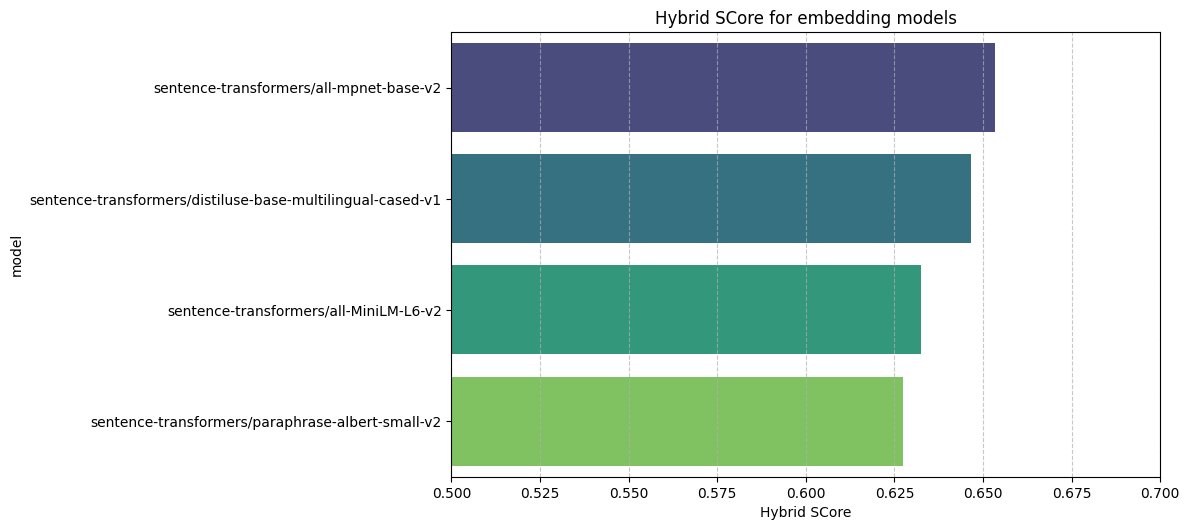

In [39]:
# Visualizzazione comparativa dei risultati
plt.figure(figsize=(12, 10))

# Ordina i risultati in base allo score ibrido
results_df_sorted = results_df.sort_values('hybrid_score', ascending=False)


#. Grafico a barre degli score ibridi
plt.subplot(2, 1, 2)
sns.barplot(
    x='hybrid_score', 
    y='model', 
    data=results_df_sorted,
    palette='viridis'
)
plt.title('Hybrid SCore for embedding models')
plt.xlabel('Hybrid SCore')
plt.xlim(0.5, 0.7)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('embedding_comparison_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [40]:
#  Seleziona il miglior modello di embedding
best_model_idx = results_df['hybrid_score'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'model']
best_model_score = results_df.loc[best_model_idx, 'hybrid_score']

print(f"\n=== Miglior modello di embedding ===")
print(f"► {best_model_name} (Hybrid Score: {best_model_score:.4f})")
print("Dettaglio metriche del miglior modello:")
# stampo tutte le metriche
for col in ['num_topics', 'outlier_percentage', 'topic_diversity', 'coherence', 'cosine_coherence','silhouette_score','davies_bouldin_score' , 'score','embedding_quality_score','hybrid_score']:
    print(f"  • {col}: {results_df.loc[best_model_idx, col]}")


=== Miglior modello di embedding ===
► sentence-transformers/all-mpnet-base-v2 (Hybrid Score: 0.6532)
Dettaglio metriche del miglior modello:
  • num_topics: 17
  • outlier_percentage: 0.126
  • topic_diversity: 0.9850057670126874
  • coherence: 0.37041735740270304
  • cosine_coherence: 0.4620906083959811
  • silhouette_score: 0.2390984147787094
  • davies_bouldin_score: 1.3473122410041471
  • score: 0.7091581420339765
  • embedding_quality_score: 0.5227841860015063
  • hybrid_score: 0.6532459552242355


# Evaluate Best Topic Model

Valutiamo su subset e con stesse metriche BErtopic e LDA

Utilizziamo preprocessing dei documenti svolto in precedenza

In [41]:
def compare_topic_models(docs_for_bert, docs_for_lda, n_topics=15):
    """
    Confronta le performance di BERTopic e LDA sugli stessi documenti preprocessati.
    Compatibile con diverse versioni di BERTopic.
    
    Args:
        docs_for_bert: Lista di documenti preprocessati per BERTopic
        docs_for_lda: Lista di documenti preprocessati per LDA
        n_topics: numero di topic da estrarre per LDA (BERTopic lo determina automaticamente)
        
    Returns:
        dict: Dizionario contenente i modelli e le metriche di valutazione
    """
    from bertopic import BERTopic
    from gensim import corpora
    from gensim.models import LdaModel
    from gensim.models.coherencemodel import CoherenceModel
    from sklearn.feature_extraction.text import CountVectorizer
    import numpy as np
    import time
    
    # Memorizza i risultati
    results = {
        "models": {},
        "metrics": {
            "bertopic": {},
            "lda": {}
        },
        "timing": {}
    }
    
    # 1. BERTopic
    print("Training BERTopic model...")
    start_time = time.time()
    
    # Configurazione di BERTopic semplice: non definisco umap e hdbscan. Serve solo per confronto di clustering con lda
    # Usa CountVectorizer per il preprocessing dei testi
    vectorizer = CountVectorizer(stop_words="english")
    bert_model = BERTopic(vectorizer_model=vectorizer)
    
    # Addestramento - usa i documenti già preprocessati per embedding
    topics, probs = bert_model.fit_transform(docs_for_bert)
    
    results["timing"]["bertopic"] = time.time() - start_time
    results["models"]["bertopic"] = bert_model
    
    # Metriche BERTopic
    topic_info = bert_model.get_topic_info()
    results["metrics"]["bertopic"]["n_topics"] = len(topic_info[topic_info['Topic'] != -1])
    
    # Calcolo della coerenza e diversità manualmente se i metodi non sono disponibili
    if hasattr(bert_model, 'get_topic_coherence'):
        results["metrics"]["bertopic"]["topic_coherence"] = bert_model.get_topic_coherence()
    else:
        # Calcolo manuale della coerenza
        print("Metodo get_topic_coherence() non disponibile, calcolo alternativo...")
        # Otteniamo i topic e i termini
        topics_to_eval = []
        for topic_id in topic_info['Topic']:
            if topic_id != -1:  # Escludiamo gli outlier
                topic_terms = [term for term, _ in bert_model.get_topic(topic_id)][:10]
                if topic_terms:  # Solo se ci sono termini
                    topics_to_eval.append(topic_terms)
        
        if topics_to_eval:
            # Creiamo un dizionario e un corpus dalla tokenizzazione dei documenti
            tokenized_docs = [doc.split() for doc in docs_for_bert]
            dictionary = corpora.Dictionary(tokenized_docs)
            
            # Calcoliamo la coerenza usando il modello di coerenza di gensim
            try:
                cm = CoherenceModel(topics=topics_to_eval, texts=tokenized_docs, 
                                  dictionary=dictionary, coherence='c_v')
                results["metrics"]["bertopic"]["topic_coherence"] = cm.get_coherence()
            except Exception as e:
                print(f"Errore nel calcolo della coerenza: {e}")
                results["metrics"]["bertopic"]["topic_coherence"] = 0.0
        else:
            results["metrics"]["bertopic"]["topic_coherence"] = 0.0
    
    if hasattr(bert_model, 'get_topic_diversity'):
        results["metrics"]["bertopic"]["topic_diversity"] = bert_model.get_topic_diversity()
    else:
        # Calcolo manuale della diversità
        print("Metodo get_topic_diversity() non disponibile, calcolo alternativo...")
        topic_sets = []
        for topic_id in topic_info['Topic']:
            if topic_id != -1:  # Escludiamo gli outlier
                terms = [term for term, _ in bert_model.get_topic(topic_id)][:20]
                topic_sets.append(set(terms))
        
        # Calcolo similarità di Jaccard tra coppie di topic
        jaccard_sims = []
        for i in range(len(topic_sets)):
            for j in range(i+1, len(topic_sets)):
                if topic_sets[i] and topic_sets[j]:  # Solo se entrambi i set hanno elementi
                    jaccard_sim = len(topic_sets[i].intersection(topic_sets[j])) / len(topic_sets[i].union(topic_sets[j]))
                    jaccard_sims.append(jaccard_sim)
        
        # La diversità è l'opposto della similarità media
        results["metrics"]["bertopic"]["topic_diversity"] = 1 - np.mean(jaccard_sims) if jaccard_sims else 0.0
    
    # 2. LDA (Gensim)
    print("Training LDA model...")
    start_time = time.time()
    
    # I documenti per LDA sono già preprocessati, li tokenizziamo
    tokenized_docs = [doc.split() for doc in docs_for_lda]
    
    # Creazione del dizionario e del corpus
    dictionary = corpora.Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]
    
    # Addestramento LDA
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=n_topics,
        random_state=11,
        passes=10,
        alpha='auto',
        eta='auto'
    )
    
    results["timing"]["lda"] = time.time() - start_time
    results["models"]["lda"] = lda_model
    results["models"]["lda_dict"] = dictionary
    results["models"]["lda_corpus"] = corpus
    
    # Metriche LDA
    # Coerenza
    try:
        coherence_model = CoherenceModel(model=lda_model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
        results["metrics"]["lda"]["topic_coherence"] = coherence_model.get_coherence()
    except Exception as e:
        print(f"Errore nel calcolo della coerenza LDA: {e}")
        results["metrics"]["lda"]["topic_coherence"] = 0.0
    
    # Diversità dei topic (calcolo manuale)
    topic_words = []
    for i in range(n_topics):
        topic_words.append([word for word, _ in lda_model.show_topic(i, topn=20)])
    
    # Calcolo Jaccard similarity tra ogni coppia di topic
    jaccard_sims = []
    for i in range(n_topics):
        for j in range(i+1, n_topics):
            set_i = set(topic_words[i])
            set_j = set(topic_words[j])
            jaccard_sims.append(len(set_i.intersection(set_j)) / len(set_i.union(set_j)))
    
    # La diversità è l'opposto della similarità media
    results["metrics"]["lda"]["topic_diversity"] = 1 - np.mean(jaccard_sims) if jaccard_sims else 0.0
    
    # Calcola altre metriche di valutazione
    try:
        perplexity = lda_model.log_perplexity(corpus)
        results["metrics"]["lda"]["perplexity"] = perplexity
    except Exception as e:
        print(f"Errore nel calcolo della perplexity: {e}")
        results["metrics"]["lda"]["perplexity"] = 0.0
    
    return results

In [24]:
def visualize_model_comparison(comparison_results):
    """
    Visualizza il confronto tra i modelli di topic modeling usando matplotlib.
    
    Args:
        comparison_results: output della funzione compare_topic_models
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    
    # Estrai metriche
    metrics = comparison_results["metrics"]
    bertopic_metrics = metrics["bertopic"]
    lda_metrics = metrics["lda"]
    
    # Crea un DataFrame per il confronto
    comparison_df = pd.DataFrame({
        'Metric': ['Topic Coherence', 'Topic Diversity', 'Training Time (s)'],
        'BERTopic': [
            bertopic_metrics.get('topic_coherence', 0),
            bertopic_metrics.get('topic_diversity', 0),
            comparison_results["timing"].get("bertopic", 0)
        ],
        'LDA': [
            lda_metrics.get('topic_coherence', 0),
            lda_metrics.get('topic_diversity', 0),
            comparison_results["timing"].get("lda", 0)
        ]
    })
    
    print("BERTopic vs LDA Comparison Metrics:")
    print(comparison_df)
    
    # Configura il plot principale
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Grafico a barre per confronto metriche
    metrics_plot = fig.add_subplot(2, 2, 1)
    
    # Grafico per coerenza e diversità
    metrics_df = comparison_df.iloc[0:2].copy()
    
    # Preparazione per il plot
    x = np.arange(len(metrics_df['Metric']))
    width = 0.35
    
    # Plot delle barre
    rects1 = metrics_plot.bar(x - width/2, metrics_df['BERTopic'], width, label='BERTopic', color='#1E88E5')
    rects2 = metrics_plot.bar(x + width/2, metrics_df['LDA'], width, label='LDA', color='#FFC107')
    
    # Aggiungi etichette e titolo
    metrics_plot.set_title('Topic Model Comparison: Coherence & Diversity', fontsize=14)
    metrics_plot.set_xlabel('Metrics')
    metrics_plot.set_ylabel('Score')
    metrics_plot.set_xticks(x)
    metrics_plot.set_xticklabels(metrics_df['Metric'])
    metrics_plot.legend()
    
    # Aggiungi etichette sui valori
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            metrics_plot.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 punti di offset verticale
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    add_labels(rects1)
    add_labels(rects2)
    
    # 2. Grafico a barre per i tempi di addestramento
    time_plot = fig.add_subplot(2, 2, 2)
    
    times = [comparison_results["timing"].get("bertopic", 0), 
             comparison_results["timing"].get("lda", 0)]
    models = ['BERTopic', 'LDA']
    colors = ['#1E88E5', '#FFC107']
    
    bars = time_plot.bar(models, times, color=colors)
    
    time_plot.set_title('Training Time Comparison', fontsize=14)
    time_plot.set_xlabel('Models')
    time_plot.set_ylabel('Time (seconds)')
    
    # Aggiungi etichette sui valori
    for bar in bars:
        height = bar.get_height()
        time_plot.annotate(f'{height:.2f}s',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 punti di offset verticale
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    # 3. Tabella dei top topic di BERTopic
    bert_plot = fig.add_subplot(2, 2, 3)
    bert_plot.axis('off')
    
    bertopic_model = comparison_results["models"]["bertopic"]
    bertopic_topics = bertopic_model.get_topic_info()
    bertopic_topics = bertopic_topics[bertopic_topics['Topic'] != -1].head(5)
    
    # Formatta i termini per la visualizzazione
    topic_terms = []
    for topic_id in bertopic_topics['Topic']:
        if topic_id == -1:  # Outlier topic
            terms = "Outlier"
        else:
            terms_weights = bertopic_model.get_topic(topic_id)
            terms = ", ".join([term for term, _ in terms_weights[:5]])
        topic_terms.append(terms)
    
    bert_table_data = []
    for i, (_, row) in enumerate(bertopic_topics.iterrows()):
        topic_id = row['Topic']
        count = row['Count']
        terms = topic_terms[i]
        bert_table_data.append([f"Topic {topic_id}", count, terms])
    
    bert_plot.set_title('BERTopic Top 5 Topics', fontsize=14)
    bert_plot.table(cellText=bert_table_data,
                   colLabels=['Topic ID', 'Count', 'Top Terms'],
                   loc='center',
                   cellLoc='center')
    
    # 4. Tabella dei top topic di LDA
    lda_plot = fig.add_subplot(2, 2, 4)
    lda_plot.axis('off')
    
    lda_model = comparison_results["models"]["lda"]
    
    lda_table_data = []
    for i in range(min(5, lda_model.num_topics)):
        terms = ", ".join([word for word, _ in lda_model.show_topic(i, topn=5)])
        lda_table_data.append([f"Topic {i}", terms])
    
    lda_plot.set_title('LDA Top 5 Topics', fontsize=14)
    lda_plot.table(cellText=lda_table_data,
                  colLabels=['Topic ID', 'Top Terms'],
                  loc='center',
                  cellLoc='center')
    
    # Aggiusta layout
    plt.tight_layout()
    
    # Stampa anche un riepilogo testuale
    print("\nRiepilogo:")
    bertopic_n_topics = len(bertopic_model.get_topic_info()[bertopic_model.get_topic_info()['Topic'] != -1])
    print(f"- BERTopic ha identificato {bertopic_n_topics} topic")
    print(f"- LDA è stato configurato con {lda_model.num_topics} topic")
    
    coherence_winner = "BERTopic" if bertopic_metrics.get('topic_coherence', 0) > lda_metrics.get('topic_coherence', 0) else "LDA"
    diversity_winner = "BERTopic" if bertopic_metrics.get('topic_diversity', 0) > lda_metrics.get('topic_diversity', 0) else "LDA"
    time_winner = "BERTopic" if comparison_results["timing"].get("bertopic", 0) < comparison_results["timing"].get("lda", 0) else "LDA"
    
    print(f"- Migliore coerenza: {coherence_winner}")
    print(f"- Migliore diversità: {diversity_winner}")
    print(f"- Più veloce: {time_winner}")
    
    # Valutazione complessiva
    bert_score = (bertopic_metrics.get('topic_coherence', 0) + bertopic_metrics.get('topic_diversity', 0)) / 2
    lda_score = (lda_metrics.get('topic_coherence', 0) + lda_metrics.get('topic_diversity', 0)) / 2
    
    overall_winner = "BERTopic" if bert_score > lda_score else "LDA"
    print(f"\nValutazione complessiva: {overall_winner} ha mostrato performance migliori")
    
    return plt, comparison_df

Training BERTopic model...


2025-05-12 12:24:04,413 - BERTopic - Transformed documents to Embeddings
2025-05-12 12:24:10,624 - BERTopic - Reduced dimensionality
2025-05-12 12:24:10,717 - BERTopic - Clustered reduced embeddings


Metodo get_topic_coherence() non disponibile, calcolo alternativo...
Metodo get_topic_diversity() non disponibile, calcolo alternativo...
Training LDA model...
BERTopic vs LDA Comparison Metrics:
              Metric   BERTopic        LDA
0    Topic Coherence   0.515611   0.433210
1    Topic Diversity   0.990962   0.908680
2  Training Time (s)  47.214719  19.873425

Riepilogo:
- BERTopic ha identificato 23 topic
- LDA è stato configurato con 15 topic
- Migliore coerenza: BERTopic
- Migliore diversità: BERTopic
- Più veloce: LDA

Valutazione complessiva: BERTopic ha mostrato performance migliori


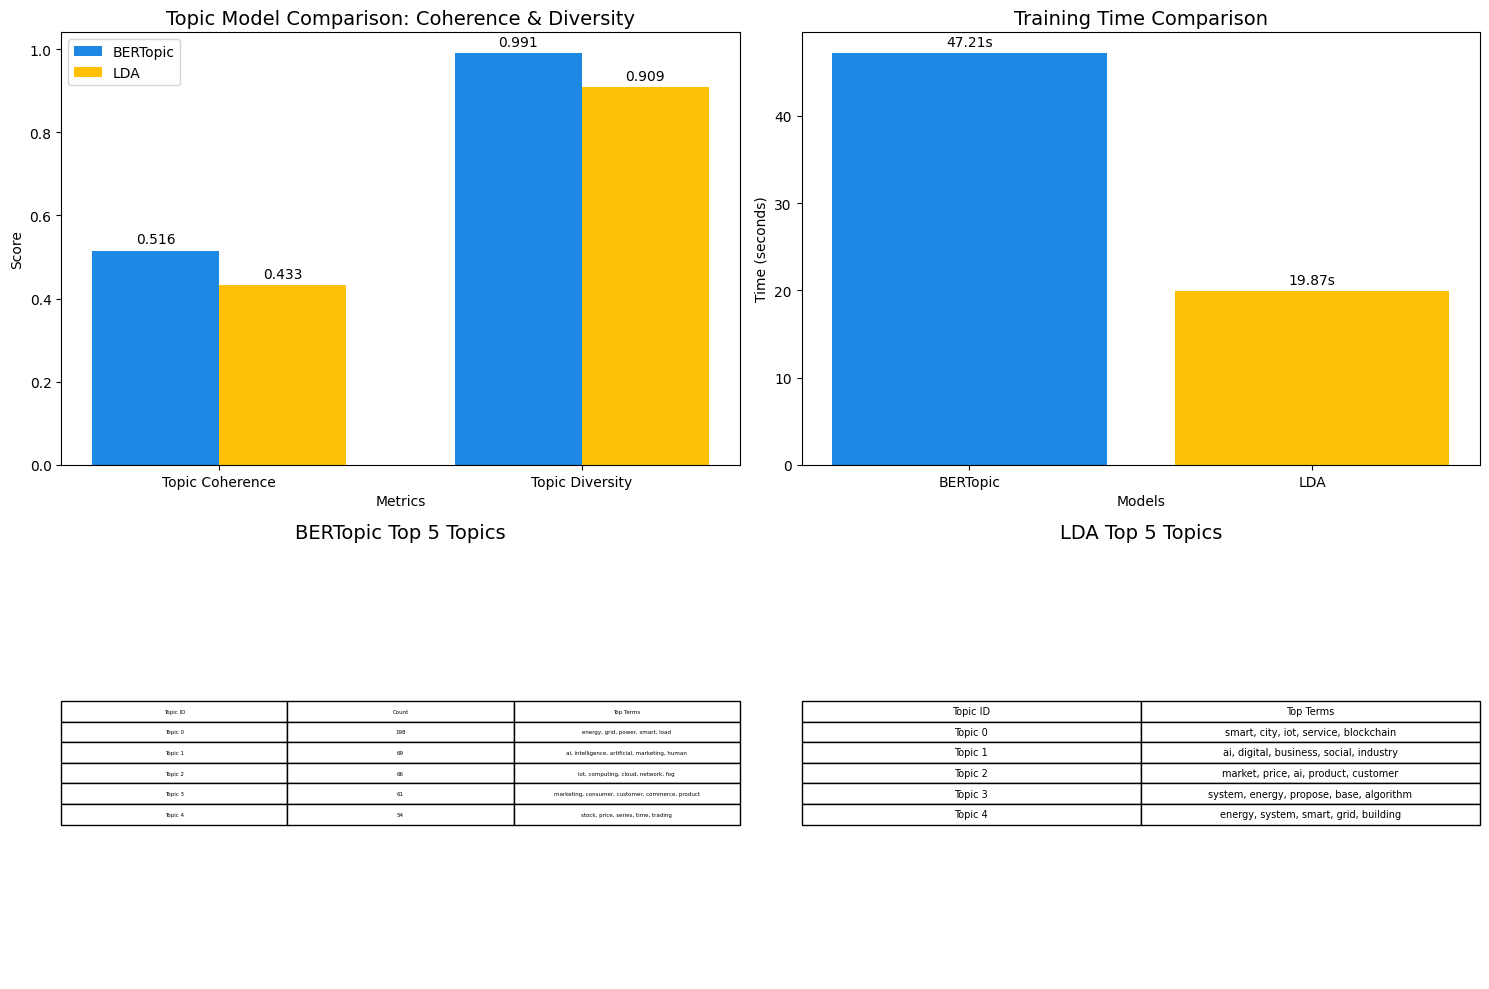

In [58]:
# Esegui il confronto
comparison_results = compare_topic_models(
    docs_for_bert=subset_topic_texts,
    docs_for_lda=subset_topic_texts,
    n_topics=15
)

# Visualizza il confronto
plt, comparison_df = visualize_model_comparison(comparison_results)

# Salva il grafico su file se necessario
plt.savefig("model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Topic recognition using Bert model

## Embeddings di tutto il dataset

Generare tutti gli embeddings con il miglior embedding model la prima volta impiega molto. Carichiamo al prof file con embeddings!

In [42]:
# 1. Seleziona il miglior modello di embedding
best_model_idx = results_df['hybrid_score'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'model']
best_model_score = results_df.loc[best_model_idx, 'hybrid_score']

print(f"\n=== Miglior modello di embedding ===")
print(f"► {best_model_name} (Hybrid Score: {best_model_score:.4f})")
print("Dettaglio metriche del miglior modello:")
for col in ['num_topics', 'outlier_percentage', 'topic_diversity', 'coherence', 'cosine_coherence','silhouette_score','davies_bouldin_score' , 'score','embedding_quality_score','hybrid_score']:
    print(f"  • {col}: {results_df.loc[best_model_idx, col]}")

# 2. Verifica se esistono già embeddings completi
embedding_file = 'embeddings.pkl'
model_file = 'embedding_model.pkl'

embeddings_exist = os.path.exists(embedding_file)
model_exists = os.path.exists(model_file)

# Verifica che entrambi i file necessari esistano
if embeddings_exist and model_exists:
    print(f"\nTrovati embeddings completi e modello salvato")
    try:
        # Carica gli embeddings e il modello
        best_embeddings = joblib.load(embedding_file)
        best_embedding_model = joblib.load(model_file)
        
        # Verifica la dimensione degli embeddings
        expected_size = len(df)
        actual_size = len(best_embeddings)
        
        if actual_size == expected_size:
            print(f"Embeddings caricati correttamente: {actual_size} documenti")
            
            # Opzionale: stampa informazioni sul modello per verifica
            print(f"Modello caricato: {best_embedding_model.__class__.__name__}")
            
            # Se il modello è SentenceTransformer, possiamo stampare il nome
            if hasattr(best_embedding_model, 'get_sentence_embedding_dimension'):
                print(f"Dimensione embeddings: {best_embedding_model.get_sentence_embedding_dimension()}")
        else:
            print(f"ATTENZIONE: Dimensione degli embeddings ({actual_size}) diversa da quella del dataset ({expected_size})")
            print("Gli embeddings esistenti potrebbero essere obsoleti. Rigenerazione necessaria.")
            # Imposta le variabili a None per forzare la rigenerazione
            best_embeddings = None
            best_embedding_model = None
    except Exception as e:
        print(f"Errore nel caricamento degli embeddings o del modello: {e}")
        best_embeddings = None
        best_embedding_model = None
else:
    print("\nFile di embeddings completi non trovati o incompleti.")
    best_embeddings = None
    best_embedding_model = None

#pulizia dei testi ( necessaria sia per generare gli embeddings ( se necessario), che per il sample nell'ottimizzazione bayesiana)
# Prepara tutti i testi per embedding e topic modeling
all_embedding_texts = []
all_topic_texts = []

print("Preparazione dei testi per embedding e topic modeling...")
# Applica la pulizia a tutti i documenti
for _, row in df.iterrows():
    # Versione per embedding (preprocessing minimo)
    title_emb = minimal_preprocessing(row['title'])
    abstract_emb = minimal_preprocessing(row['abstract'])
    embedding_text = f"{title_emb} {abstract_emb}"
    all_embedding_texts.append(embedding_text)
    
    # Versione per topic modeling (preprocessing completo)
    title_topic = enhanced_text_cleaning(row['title'])
    abstract_topic = enhanced_text_cleaning(row['abstract'])
    topic_text = f"{title_topic} {abstract_topic}"
    all_topic_texts.append(topic_text)

print(f"Preparati {len(all_embedding_texts)} documenti per embedding e topic modeling")



# 3. Se necessario, genera nuovi embeddings per l'intero dataset
if best_embeddings is None or best_embedding_model is None:
    print(f"\n=== Generazione embeddings per l'intero dataset con {best_model_name} ===")
    
    
    # Carica il miglior modello
    best_embedding_model = SentenceTransformer(best_model_name)
    print(f"Modello {best_model_name} caricato con successo")
    
    # Genera embeddings per l'intero dataset
    print("Generazione degli embeddings per l'intero dataset...")
    batch_size = 32
    all_embeddings = []
    
    # Processa in batch per non saturare la memoria
    for i in tqdm(range(0, len(all_embedding_texts), batch_size), desc="Batch Processing"):
        batch_texts = all_embedding_texts[i:i+batch_size]
        batch_embeddings = best_embedding_model.encode(batch_texts, convert_to_tensor=True)
        
        # Normalizza gli embeddings
        batch_embeddings = torch.nn.functional.normalize(batch_embeddings, p=2, dim=1)
        
        # Convertili in numpy per concatenarli più facilmente
        all_embeddings.append(batch_embeddings.cpu().numpy())
    
    # Concatena tutti gli embeddings
    best_embeddings = np.vstack(all_embeddings)
    print(f"Generati embeddings per {len(best_embeddings)} documenti")
    
    # Salva gli embeddings e il modello per uso futuro
    print("Salvataggio degli embeddings e del modello...")
    joblib.dump(best_embeddings, embedding_file)
    joblib.dump(best_embedding_model, model_file)
    
    print("Embeddings e modello salvati con successo!")
else:
    print("Utilizzando gli embeddings e il modello esistenti.")


=== Miglior modello di embedding ===
► sentence-transformers/all-mpnet-base-v2 (Hybrid Score: 0.6532)
Dettaglio metriche del miglior modello:
  • num_topics: 17
  • outlier_percentage: 0.126
  • topic_diversity: 0.9850057670126874
  • coherence: 0.37041735740270304
  • cosine_coherence: 0.4620906083959811
  • silhouette_score: 0.2390984147787094
  • davies_bouldin_score: 1.3473122410041471
  • score: 0.7091581420339765
  • embedding_quality_score: 0.5227841860015063
  • hybrid_score: 0.6532459552242355

Trovati embeddings completi e modello salvato
Embeddings caricati correttamente: 6432 documenti
Modello caricato: SentenceTransformer
Dimensione embeddings: 768
Preparazione dei testi per embedding e topic modeling...
Preparati 6432 documenti per embedding e topic modeling
Utilizzando gli embeddings e il modello esistenti.


## HYPERPARAMETER TUNING

### Comparison Bayesian - Grid Search

In [60]:
# CONFRONTO TRA OTTIMIZZAZIONE BAYESIANA E GRID SEARCH PER TOPIC MODELING
import time
from sklearn.model_selection import ParameterGrid
import optuna
import umap
import hdbscan
from bertopic import BERTopic

# Funzione di valutazione separata e riutilizzabile
def evaluate_bertopic_config(params, sample_texts, sample_embeddings, method_name=""):
    """
    Valuta una configurazione di parametri per BERTopic in modo riutilizzabile
    sia per Grid Search che per Bayesian Optimization.
    
    Args:
        params: Dizionario di parametri da valutare
        sample_texts: Lista di testi di esempio
        sample_embeddings: Array di embedding corrispondenti
        method_name: Nome del metodo di ottimizzazione (per logging)
        
    Returns:
        dict: Risultati dettagliati della valutazione
    """
    start_time = time.time()
    
    # Estrai parametri
    min_topic_size = params['min_topic_size']
    nr_topics = params['nr_topics']
    n_gram_range = (1, params['max_ngram'])
    n_neighbors = params['n_neighbors']
    n_components = params['n_components']
    min_dist = params['min_dist']
    min_cluster_size = params.get('min_cluster_size', 15)  # Valore predefinito se non specificato
    min_samples = params.get('min_samples', 10)  # Valore predefinito se non specificato
    
    # Crea il modello UMAP
    dimensionality_reduction = umap.UMAP(
        n_neighbors=n_neighbors,
        n_components=n_components,
        min_dist=min_dist,
        metric='cosine',
        random_state=11
    )
    
    # Crea il modello HDBSCAN
    hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric='euclidean',
        prediction_data=True
    )
    
    # Crea il modello BERTopic
    model = BERTopic(
        embedding_model=best_embedding_model,
        umap_model=dimensionality_reduction,
        hdbscan_model=hdbscan_model,
        min_topic_size=min_topic_size,
        nr_topics=nr_topics,
        n_gram_range=n_gram_range,
        verbose=False  
    )
    
    try:
        # Addestramento del modello
        topics, probs = model.fit_transform(sample_texts, embeddings=sample_embeddings)
        
        # Ottieni informazioni sui topic
        topic_info = model.get_topic_info()
        
        # Calcola metriche
        num_topics = len(topic_info[topic_info['Topic'] != -1])
        outlier_count = topic_info.loc[topic_info['Topic'] == -1, 'Count'].values[0] if -1 in topic_info['Topic'].values else 0
        outlier_percentage = outlier_count / len(sample_texts)
        
        # Calcola la diversità dei topic
        topic_diversity = calculate_topic_diversity(model, topics)
        
        # Calcola metriche di coerenza
        mean_coherence, cosine_coherence = calculate_coherence_metrics(model, topics, sample_embeddings)
        
        # Calcola punteggio combinato
        score = calculate_combined_score(topic_diversity, outlier_percentage, mean_coherence, cosine_coherence, num_topics)
        
        duration = time.time() - start_time
        
        # Crea il risultato
        result = {
            'score': score,
            'num_topics': num_topics,
            'outlier_percentage': outlier_percentage,
            'diversity': topic_diversity,
            'coherence': mean_coherence,
            'cosine_coherence': cosine_coherence,
            'duration': duration
        }
        
        # Logging
        if method_name:
            print(f"[{method_name}] Valutazione completata in {duration:.2f}s - Score: {score:.4f}, Topics: {num_topics}")
        
        return result
    
    except Exception as e:
        duration = time.time() - start_time
        print(f"Errore durante la valutazione: {str(e)}")
        return {
            'score': -1.0,
            'num_topics': 0,
            'outlier_percentage': 1.0,
            'diversity': 0.0,
            'coherence': 0.0,
            'cosine_coherence': 0.0,
            'duration': duration
        }

# Funzioni di supporto per il calcolo delle metriche 
def calculate_topic_diversity(model, topics):
    unique_topics = [t for t in set(topics) if t != -1]
    
    # Se c'è solo un topic o nessuno, la diversità è 0
    if len(unique_topics) <= 1:
        return 0.0
    
    # Raccogli tutte le parole importanti per ciascun topic
    topic_word_sets = {}
    for topic_id in unique_topics:
        words = [word for word, _ in model.get_topic(topic_id)[:20]]  # Prendi le top 20 parole
        topic_word_sets[topic_id] = set(words)
    
    # Calcola sovrapposizione media (Jaccard similarity)
    similarities = []
    for i, topic_id1 in enumerate(unique_topics):
        for j, topic_id2 in enumerate(unique_topics[i+1:], i+1):
            set1 = topic_word_sets[topic_id1]
            set2 = topic_word_sets[topic_id2]
            
            # Jaccard similarity: |A ∩ B| / |A ∪ B|
            if len(set1) > 0 and len(set2) > 0:
                intersection = len(set1.intersection(set2))
                union = len(set1.union(set2))
                similarity = intersection / union if union > 0 else 0
                similarities.append(similarity)
    
    # La diversità è il complemento della similarità media
    avg_similarity = np.mean(similarities) if similarities else 0
    return 1 - avg_similarity

def calculate_coherence_metrics(model, topics, embeddings):
    unique_topics = [t for t in set(topics) if t != -1]
    
    # Calcola coerenza (proxy semplificato)
    coherence_scores = []
    for topic_id in unique_topics:
        top_words = model.get_topic(topic_id)
        if top_words:
            coherence = sum(weight for _, weight in top_words[:10])
            coherence_scores.append(coherence)
    
    mean_coherence = np.mean(coherence_scores) if coherence_scores else 0
    
    # Calcola coerenza basata su similarità coseno
    cosine_coherence = 0
    if len(unique_topics) > 1:
        try:
            # Estrai gli indici dei documenti per ogni topic
            topic_to_docs = {}
            for i, t in enumerate(topics):
                if t != -1:  # Ignora outlier
                    if t not in topic_to_docs:
                        topic_to_docs[t] = []
                    topic_to_docs[t].append(i)
            
            # Calcola la similarità coseno media per ogni topic
            topic_coherence_scores = []
            for t, doc_indices in topic_to_docs.items():
                if len(doc_indices) >= 2:  # Servono almeno 2 documenti per calcolare la similarità
                    # Limita a massimo 30 documenti per efficienza
                    if len(doc_indices) > 30:
                        doc_indices = np.random.choice(doc_indices, 30, replace=False)
                    
                    # Estrai gli embeddings per questo topic
                    topic_embeddings = embeddings[doc_indices]
                    
                    # Calcola la matrice di similarità coseno
                    sim_matrix = np.dot(topic_embeddings, topic_embeddings.T)
                    
                    # Rimuovi la diagonale (similarità di un documento con se stesso)
                    np.fill_diagonal(sim_matrix, 0)
                    
                    # Calcola la similarità media
                    avg_sim = sim_matrix.sum() / (len(doc_indices) * (len(doc_indices) - 1))
                    topic_coherence_scores.append(avg_sim)
            
            # Media delle coerenze di tutti i topic
            cosine_coherence = np.mean(topic_coherence_scores) if topic_coherence_scores else 0
        except Exception as e:
            print(f"Errore nel calcolo della coerenza coseno: {e}")
            cosine_coherence = 0
    
    return mean_coherence, cosine_coherence

def calculate_combined_score(topic_diversity, outlier_percentage, mean_coherence, cosine_coherence, num_topics):
    if num_topics < 5:
        # Penalizza fortemente i modelli con meno di 5 topic
        penalty_factor = 0.5  # Riduce lo score del 50%
        score = (
            0.30 * topic_diversity +         # Diversità
            0.20 * (1 - outlier_percentage) + # Copertura
            0.25 * mean_coherence +          # Coerenza
            0.25 * cosine_coherence          # Coerenza coseno
              ) * penalty_factor
    else:
        # Calcolo normale per modelli con almeno 5 topic
        score = (
            0.30 * topic_diversity +         # Diversità
            0.20 * (1 - outlier_percentage) + # Copertura
            0.25 * mean_coherence +          # Coerenza
            0.25 * cosine_coherence          # Coerenza coseno
        )
    return score


# Funzione principale per eseguire il confronto
def run_comparison(all_topic_texts, best_embeddings, best_embedding_model, n_samples=1000):
    print(f"Preparazione subset di {n_samples} documenti per il confronto...")
    
    # Usa seed fisso per riproducibilità
    np.random.seed(11)
    
    # Seleziona 1000 indici casuali
    indices = np.random.choice(len(all_topic_texts), n_samples, replace=False)
    
    # Utilizza gli stessi indici sia per i testi che per gli embeddings
    sample_texts = [all_topic_texts[i] for i in indices]
    sample_embeddings = best_embeddings[indices]
    
    print(f"Subset creato: {len(sample_texts)} documenti con embeddings di dimensione {sample_embeddings.shape}")
    
    # Definizione dei parametri per grid search (ridotti per maggiore efficienza)
    param_grid = {
        'min_topic_size': [10, 20],
        'nr_topics': ['10', '20'],
        'max_ngram': [1, 2],
        'n_neighbors': [10, 30],
        'n_components': [10, 20],
        'min_dist': [0.1, 0.3]
    }
    
    grid = list(ParameterGrid(param_grid))
    print(f"Grid search: valutazione di {len(grid)} combinazioni di parametri...")
    
    # Esecuzione Grid Search
    grid_start_time = time.time()
    grid_results = []
    
    for i, params in enumerate(grid):
        print(f"Valutazione combinazione {i+1}/{len(grid)}...")
        # Usa la funzione riutilizzabile con il nome del metodo
        result = evaluate_bertopic_config(params, sample_texts, sample_embeddings, method_name="Grid Search")
        result.update(params)  # Aggiungi i parametri ai risultati
        grid_results.append(result)
    
    grid_duration = time.time() - grid_start_time
    
    # Trova il miglior risultato della grid search
    best_grid_result = max(grid_results, key=lambda x: x['score'])
    
    # Esecuzione Bayesian Optimization
    print("Avvio ottimizzazione bayesiana...")
    bayes_start_time = time.time()
    
    # Adatta la funzione obiettivo per optuna
    def objective(trial):
        params = {
            'min_topic_size': trial.suggest_int('min_topic_size', 5, 30),
            'nr_topics': trial.suggest_categorical('nr_topics', ['10', '25']),
            'max_ngram': trial.suggest_int('max_ngram', 1, 3),
            'n_neighbors': trial.suggest_int('n_neighbors', 5, 40),
            'n_components': trial.suggest_int('n_components', 5, 30),
            'min_dist': trial.suggest_float('min_dist', 0.01, 0.4),
            'min_cluster_size': trial.suggest_int('min_cluster_size', 15, 30),
            'min_samples': trial.suggest_int('min_samples', 5, 20)
        }
        
        # Usa la funzione riutilizzabile con il nome del metodo
        result = evaluate_bertopic_config(params, sample_texts, sample_embeddings, method_name="Bayesian Opt")
        
        # Salva le metriche dettagliate per l'analisi
        trial.set_user_attr("num_topics", result['num_topics'])
        trial.set_user_attr("outlier_percentage", result['outlier_percentage'])
        trial.set_user_attr("diversity", result['diversity'])
        trial.set_user_attr("coherence", result['coherence'])
        trial.set_user_attr("duration", result['duration'])
        
        return result['score']
    
    # Crea lo studio di optuna
    study = optuna.create_study(direction='maximize', 
                                sampler=optuna.samplers.TPESampler(seed=11))
    
    # Esegui l'ottimizzazione per lo stesso numero di valutazioni della grid search
    n_trials = min(len(grid), 30)  # Limita per efficienza
    study.optimize(objective, n_trials=n_trials)
    
    bayes_duration = time.time() - bayes_start_time
    
    # Raccogli risultati dell'ottimizzazione bayesiana
    best_bayes_params = study.best_params
    best_bayes_trial = study.best_trial
    best_bayes_score = study.best_value
    best_bayes_metrics = {
        'score': best_bayes_score,
        'num_topics': best_bayes_trial.user_attrs["num_topics"],
        'outlier_percentage': best_bayes_trial.user_attrs["outlier_percentage"],
        'diversity': best_bayes_trial.user_attrs["diversity"],
        'coherence': best_bayes_trial.user_attrs["coherence"],
        'duration': best_bayes_trial.user_attrs.get("duration", 0)
    }
    
    # Crea un DataFrame con tutti i risultati della grid search per visualizzazione
    grid_df = pd.DataFrame(grid_results)
    
    # Crea un DataFrame con i risultati delle prove bayesiane
    bayes_df = pd.DataFrame([
        {
            'trial': trial.number,
            'score': trial.value,
            'num_topics': trial.user_attrs.get("num_topics", 0),
            'outlier_percentage': trial.user_attrs.get("outlier_percentage", 1.0),
            'diversity': trial.user_attrs.get("diversity", 0.0),
            'coherence': trial.user_attrs.get("coherence", 0.0),
            'duration': trial.user_attrs.get("duration", 0),
            **trial.params
        }
        for trial in study.trials
    ])
    
    # Confronto delle performance
    print("\n=== CONFRONTO DEI RISULTATI ===")
    print(f"Grid Search: {len(grid)} combinazioni valutate in {grid_duration:.2f} secondi")
    print(f"Ottimizzazione Bayesiana: {n_trials} valutazioni in {bayes_duration:.2f} secondi")
    
    print("\n=== MIGLIORI PARAMETRI ===")
    print("Grid Search:")
    for param, value in best_grid_result.items():
        if param not in ['score', 'num_topics', 'outlier_percentage', 'diversity', 'coherence', 'cosine_coherence', 'duration']:
            print(f"  {param}: {value}")
    
    print("\nOttimizzazione Bayesiana:")
    for param, value in best_bayes_params.items():
        print(f"  {param}: {value}")
    
    print("\n=== MIGLIORI METRICHE ===")
    print(f"Grid Search: Score={best_grid_result['score']:.4f}, "
          f"Topics={best_grid_result['num_topics']}, "
          f"Outliers={best_grid_result['outlier_percentage']:.2%}, "
          f"Diversity={best_grid_result['diversity']:.4f}, "
          f"Coherence={best_grid_result['coherence']:.4f}")
    
    print(f"Bayesian: Score={best_bayes_score:.4f}, "
          f"Topics={best_bayes_metrics['num_topics']}, "
          f"Outliers={best_bayes_metrics['outlier_percentage']:.2%}, "
          f"Diversity={best_bayes_metrics['diversity']:.4f}, "
          f"Coherence={best_bayes_metrics['coherence']:.4f}")
    
    # Crea visualizzazioni
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Confronto efficienza
    methods = ['Grid Search', 'Bayesian Opt']
    times = [grid_duration / len(grid), bayes_duration / n_trials]
    axes[0, 0].bar(methods, times)
    axes[0, 0].set_title('Tempo medio per valutazione (secondi)')
    axes[0, 0].set_ylabel('Secondi')
    
    # 2. Confronto score
    best_scores = [best_grid_result['score'], best_bayes_score]
    axes[0, 1].bar(methods, best_scores)
    axes[0, 1].set_title('Miglior score')
    
    # 3. Progressione Bayesian Optimization
    if not bayes_df.empty:
        trial_numbers = bayes_df['trial'].values
        scores = bayes_df['score'].values
        axes[1, 0].plot(trial_numbers, scores, 'o-')
        axes[1, 0].set_title('Progressione dell\'ottimizzazione bayesiana')
        axes[1, 0].set_xlabel('Numero prova')
        axes[1, 0].set_ylabel('Score')
        
        # Aggiungi linea per il miglior risultato di grid search
        axes[1, 0].axhline(y=best_grid_result['score'], color='r', linestyle='-', 
                        label=f'Miglior Grid Search: {best_grid_result["score"]:.4f}')
        axes[1, 0].legend()
    
    # 4. Confronto distribuzione
    if not bayes_df.empty and not grid_df.empty:
        sns.kdeplot(grid_df['score'].dropna(), label='Grid Search', ax=axes[1, 1])
        sns.kdeplot(bayes_df['score'].dropna(), label='Bayesian Opt', ax=axes[1, 1])
        axes[1, 1].set_title('Distribuzione degli score')
        axes[1, 1].set_xlabel('Score')
        axes[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig('bayesian_vs_grid_comparison.png')
    plt.close()
    
    return {
        'grid_search': {
            'best_result': best_grid_result,
            'duration': grid_duration,
            'evaluations': len(grid)
        },
        'bayesian_opt': {
            'best_params': best_bayes_params,
            'best_metrics': best_bayes_metrics,
            'duration': bayes_duration,
            'evaluations': n_trials
        },
        'comparison_figure': 'bayesian_vs_grid_comparison.png'
    }



# Esegui il confronto utilizzando gli embeddings esistenti
comparison_results = run_comparison(all_topic_texts, best_embeddings, best_embedding_model, n_samples=1000)

Preparazione subset di 1000 documenti per il confronto...
Subset creato: 1000 documenti con embeddings di dimensione (1000, 768)
Grid search: valutazione di 64 combinazioni di parametri...
Valutazione combinazione 1/64...


2025-05-12 16:02:06,239 - BERTopic - Reduced dimensionality
2025-05-12 16:02:06,373 - BERTopic - Clustered reduced embeddings
2025-05-12 16:02:06,970 - BERTopic - Reduced number of topics from 15 to 15


[Grid Search] Valutazione completata in 4.75s - Score: 0.6438, Topics: 14
Valutazione combinazione 2/64...


2025-05-12 16:02:10,026 - BERTopic - Reduced dimensionality
2025-05-12 16:02:10,072 - BERTopic - Clustered reduced embeddings
2025-05-12 16:02:10,513 - BERTopic - Reduced number of topics from 15 to 15


[Grid Search] Valutazione completata in 3.53s - Score: 0.6414, Topics: 14
Valutazione combinazione 3/64...


2025-05-12 16:02:14,243 - BERTopic - Reduced dimensionality
2025-05-12 16:02:14,287 - BERTopic - Clustered reduced embeddings
2025-05-12 16:02:14,731 - BERTopic - Reduced number of topics from 12 to 7


[Grid Search] Valutazione completata in 4.18s - Score: 0.6062, Topics: 6
Valutazione combinazione 4/64...


2025-05-12 16:02:18,380 - BERTopic - Reduced dimensionality
2025-05-12 16:02:18,420 - BERTopic - Clustered reduced embeddings
2025-05-12 16:02:18,808 - BERTopic - Reduced number of topics from 12 to 7


[Grid Search] Valutazione completata in 4.06s - Score: 0.6083, Topics: 6
Valutazione combinazione 5/64...


2025-05-12 16:02:22,251 - BERTopic - Reduced dimensionality
2025-05-12 16:02:22,305 - BERTopic - Clustered reduced embeddings
2025-05-12 16:02:22,724 - BERTopic - Reduced number of topics from 14 to 14


[Grid Search] Valutazione completata in 3.95s - Score: 0.6381, Topics: 13
Valutazione combinazione 6/64...


2025-05-12 16:02:26,049 - BERTopic - Reduced dimensionality
2025-05-12 16:02:26,105 - BERTopic - Clustered reduced embeddings
2025-05-12 16:02:26,538 - BERTopic - Reduced number of topics from 14 to 14


[Grid Search] Valutazione completata in 3.82s - Score: 0.6380, Topics: 13
Valutazione combinazione 7/64...


2025-05-12 16:02:31,422 - BERTopic - Reduced dimensionality
2025-05-12 16:02:31,527 - BERTopic - Clustered reduced embeddings
2025-05-12 16:02:32,197 - BERTopic - Reduced number of topics from 13 to 13


[Grid Search] Valutazione completata in 5.71s - Score: 0.6139, Topics: 12
Valutazione combinazione 8/64...


2025-05-12 16:02:37,806 - BERTopic - Reduced dimensionality
2025-05-12 16:02:37,871 - BERTopic - Clustered reduced embeddings
2025-05-12 16:02:38,411 - BERTopic - Reduced number of topics from 13 to 13


[Grid Search] Valutazione completata in 6.22s - Score: 0.6142, Topics: 12
Valutazione combinazione 9/64...


2025-05-12 16:02:42,128 - BERTopic - Reduced dimensionality
2025-05-12 16:02:42,179 - BERTopic - Clustered reduced embeddings
2025-05-12 16:02:42,688 - BERTopic - Reduced number of topics from 15 to 15


[Grid Search] Valutazione completata in 4.32s - Score: 0.6408, Topics: 14
Valutazione combinazione 10/64...


2025-05-12 16:02:46,356 - BERTopic - Reduced dimensionality
2025-05-12 16:02:46,410 - BERTopic - Clustered reduced embeddings
2025-05-12 16:02:46,985 - BERTopic - Reduced number of topics from 15 to 15


[Grid Search] Valutazione completata in 4.30s - Score: 0.6422, Topics: 14
Valutazione combinazione 11/64...


2025-05-12 16:02:53,574 - BERTopic - Reduced dimensionality
2025-05-12 16:02:53,672 - BERTopic - Clustered reduced embeddings
2025-05-12 16:02:54,500 - BERTopic - Reduced number of topics from 12 to 7


[Grid Search] Valutazione completata in 7.47s - Score: 0.6074, Topics: 6
Valutazione combinazione 12/64...


2025-05-12 16:03:01,904 - BERTopic - Reduced dimensionality
2025-05-12 16:03:01,962 - BERTopic - Clustered reduced embeddings
2025-05-12 16:03:02,778 - BERTopic - Reduced number of topics from 12 to 7


[Grid Search] Valutazione completata in 8.29s - Score: 0.6063, Topics: 6
Valutazione combinazione 13/64...


2025-05-12 16:03:09,512 - BERTopic - Reduced dimensionality
2025-05-12 16:03:09,608 - BERTopic - Clustered reduced embeddings
2025-05-12 16:03:10,357 - BERTopic - Reduced number of topics from 14 to 14


[Grid Search] Valutazione completata in 7.68s - Score: 0.6395, Topics: 13
Valutazione combinazione 14/64...


2025-05-12 16:03:17,410 - BERTopic - Reduced dimensionality
2025-05-12 16:03:17,504 - BERTopic - Clustered reduced embeddings
2025-05-12 16:03:18,350 - BERTopic - Reduced number of topics from 14 to 14


[Grid Search] Valutazione completata in 8.00s - Score: 0.6385, Topics: 13
Valutazione combinazione 15/64...


2025-05-12 16:03:27,409 - BERTopic - Reduced dimensionality
2025-05-12 16:03:27,506 - BERTopic - Clustered reduced embeddings
2025-05-12 16:03:28,307 - BERTopic - Reduced number of topics from 13 to 13


[Grid Search] Valutazione completata in 9.87s - Score: 0.6134, Topics: 12
Valutazione combinazione 16/64...


2025-05-12 16:03:36,915 - BERTopic - Reduced dimensionality
2025-05-12 16:03:36,988 - BERTopic - Clustered reduced embeddings
2025-05-12 16:03:37,758 - BERTopic - Reduced number of topics from 13 to 13


[Grid Search] Valutazione completata in 9.48s - Score: 0.6146, Topics: 12
Valutazione combinazione 17/64...


2025-05-12 16:03:43,339 - BERTopic - Reduced dimensionality
2025-05-12 16:03:43,413 - BERTopic - Clustered reduced embeddings
2025-05-12 16:03:44,209 - BERTopic - Reduced number of topics from 16 to 9


[Grid Search] Valutazione completata in 6.42s - Score: 0.5856, Topics: 8
Valutazione combinazione 18/64...


2025-05-12 16:03:49,699 - BERTopic - Reduced dimensionality
2025-05-12 16:03:49,816 - BERTopic - Clustered reduced embeddings
2025-05-12 16:03:50,638 - BERTopic - Reduced number of topics from 16 to 9


[Grid Search] Valutazione completata in 6.42s - Score: 0.5840, Topics: 8
Valutazione combinazione 19/64...


2025-05-12 16:03:57,394 - BERTopic - Reduced dimensionality
2025-05-12 16:03:57,441 - BERTopic - Clustered reduced embeddings
2025-05-12 16:03:57,838 - BERTopic - Reduced number of topics from 3 to 3


[Grid Search] Valutazione completata in 7.06s - Score: 0.3343, Topics: 2
Valutazione combinazione 20/64...


2025-05-12 16:04:01,470 - BERTopic - Reduced dimensionality
2025-05-12 16:04:01,518 - BERTopic - Clustered reduced embeddings
2025-05-12 16:04:01,893 - BERTopic - Reduced number of topics from 3 to 3


[Grid Search] Valutazione completata in 4.06s - Score: 0.3298, Topics: 2
Valutazione combinazione 21/64...


2025-05-12 16:04:05,278 - BERTopic - Reduced dimensionality
2025-05-12 16:04:05,341 - BERTopic - Clustered reduced embeddings
2025-05-12 16:04:05,739 - BERTopic - Reduced number of topics from 13 to 8


[Grid Search] Valutazione completata in 3.87s - Score: 0.6041, Topics: 7
Valutazione combinazione 22/64...


2025-05-12 16:04:09,131 - BERTopic - Reduced dimensionality
2025-05-12 16:04:09,196 - BERTopic - Clustered reduced embeddings
2025-05-12 16:04:09,582 - BERTopic - Reduced number of topics from 13 to 8


[Grid Search] Valutazione completata in 3.84s - Score: 0.6064, Topics: 7
Valutazione combinazione 23/64...


2025-05-12 16:04:14,212 - BERTopic - Reduced dimensionality
2025-05-12 16:04:14,282 - BERTopic - Clustered reduced embeddings
2025-05-12 16:04:14,668 - BERTopic - Reduced number of topics from 11 to 11


[Grid Search] Valutazione completata in 5.10s - Score: 0.6045, Topics: 10
Valutazione combinazione 24/64...


2025-05-12 16:04:19,134 - BERTopic - Reduced dimensionality
2025-05-12 16:04:19,193 - BERTopic - Clustered reduced embeddings
2025-05-12 16:04:19,585 - BERTopic - Reduced number of topics from 11 to 11


[Grid Search] Valutazione completata in 4.90s - Score: 0.6027, Topics: 10
Valutazione combinazione 25/64...


2025-05-12 16:04:22,404 - BERTopic - Reduced dimensionality
2025-05-12 16:04:22,450 - BERTopic - Clustered reduced embeddings
2025-05-12 16:04:22,842 - BERTopic - Reduced number of topics from 16 to 9


[Grid Search] Valutazione completata in 3.25s - Score: 0.5855, Topics: 8
Valutazione combinazione 26/64...


2025-05-12 16:04:25,735 - BERTopic - Reduced dimensionality
2025-05-12 16:04:25,779 - BERTopic - Clustered reduced embeddings
2025-05-12 16:04:26,164 - BERTopic - Reduced number of topics from 16 to 9


[Grid Search] Valutazione completata in 3.32s - Score: 0.5863, Topics: 8
Valutazione combinazione 27/64...


2025-05-12 16:04:29,708 - BERTopic - Reduced dimensionality
2025-05-12 16:04:29,753 - BERTopic - Clustered reduced embeddings
2025-05-12 16:04:30,128 - BERTopic - Reduced number of topics from 3 to 3


[Grid Search] Valutazione completata in 3.93s - Score: 0.3343, Topics: 2
Valutazione combinazione 28/64...


2025-05-12 16:04:33,651 - BERTopic - Reduced dimensionality
2025-05-12 16:04:33,692 - BERTopic - Clustered reduced embeddings
2025-05-12 16:04:34,071 - BERTopic - Reduced number of topics from 3 to 3


[Grid Search] Valutazione completata in 3.94s - Score: 0.3362, Topics: 2
Valutazione combinazione 29/64...


2025-05-12 16:04:37,398 - BERTopic - Reduced dimensionality
2025-05-12 16:04:37,461 - BERTopic - Clustered reduced embeddings
2025-05-12 16:04:37,850 - BERTopic - Reduced number of topics from 13 to 8


[Grid Search] Valutazione completata in 3.81s - Score: 0.6045, Topics: 7
Valutazione combinazione 30/64...


2025-05-12 16:04:41,483 - BERTopic - Reduced dimensionality
2025-05-12 16:04:41,615 - BERTopic - Clustered reduced embeddings
2025-05-12 16:04:42,209 - BERTopic - Reduced number of topics from 13 to 8


[Grid Search] Valutazione completata in 4.47s - Score: 0.6062, Topics: 7
Valutazione combinazione 31/64...


2025-05-12 16:04:49,321 - BERTopic - Reduced dimensionality
2025-05-12 16:04:49,418 - BERTopic - Clustered reduced embeddings
2025-05-12 16:04:50,119 - BERTopic - Reduced number of topics from 11 to 11


[Grid Search] Valutazione completata in 8.02s - Score: 0.6022, Topics: 10
Valutazione combinazione 32/64...


2025-05-12 16:05:01,093 - BERTopic - Reduced dimensionality
2025-05-12 16:05:01,251 - BERTopic - Clustered reduced embeddings
2025-05-12 16:05:02,341 - BERTopic - Reduced number of topics from 11 to 11


[Grid Search] Valutazione completata in 12.11s - Score: 0.6040, Topics: 10
Valutazione combinazione 33/64...


2025-05-12 16:05:07,573 - BERTopic - Reduced dimensionality
2025-05-12 16:05:07,668 - BERTopic - Clustered reduced embeddings
2025-05-12 16:05:10,670 - BERTopic - Reduced number of topics from 15 to 15


[Grid Search] Valutazione completata in 8.59s - Score: 0.6033, Topics: 14
Valutazione combinazione 34/64...


2025-05-12 16:05:16,391 - BERTopic - Reduced dimensionality
2025-05-12 16:05:16,500 - BERTopic - Clustered reduced embeddings
2025-05-12 16:05:18,079 - BERTopic - Reduced number of topics from 15 to 15


[Grid Search] Valutazione completata in 7.17s - Score: 0.6028, Topics: 14
Valutazione combinazione 35/64...


2025-05-12 16:05:22,033 - BERTopic - Reduced dimensionality
2025-05-12 16:05:22,071 - BERTopic - Clustered reduced embeddings
2025-05-12 16:05:23,496 - BERTopic - Reduced number of topics from 12 to 7


[Grid Search] Valutazione completata in 5.38s - Score: 0.5607, Topics: 6
Valutazione combinazione 36/64...


2025-05-12 16:05:27,164 - BERTopic - Reduced dimensionality
2025-05-12 16:05:27,230 - BERTopic - Clustered reduced embeddings
2025-05-12 16:05:28,606 - BERTopic - Reduced number of topics from 12 to 7


[Grid Search] Valutazione completata in 5.07s - Score: 0.5647, Topics: 6
Valutazione combinazione 37/64...


2025-05-12 16:05:32,162 - BERTopic - Reduced dimensionality
2025-05-12 16:05:32,209 - BERTopic - Clustered reduced embeddings
2025-05-12 16:05:33,586 - BERTopic - Reduced number of topics from 14 to 14


[Grid Search] Valutazione completata in 5.02s - Score: 0.5989, Topics: 13
Valutazione combinazione 38/64...


2025-05-12 16:05:37,091 - BERTopic - Reduced dimensionality
2025-05-12 16:05:37,166 - BERTopic - Clustered reduced embeddings
2025-05-12 16:05:38,870 - BERTopic - Reduced number of topics from 14 to 14


[Grid Search] Valutazione completata in 5.35s - Score: 0.5988, Topics: 13
Valutazione combinazione 39/64...


2025-05-12 16:05:43,911 - BERTopic - Reduced dimensionality
2025-05-12 16:05:43,970 - BERTopic - Clustered reduced embeddings
2025-05-12 16:05:45,612 - BERTopic - Reduced number of topics from 13 to 13


[Grid Search] Valutazione completata in 6.68s - Score: 0.5732, Topics: 12
Valutazione combinazione 40/64...


2025-05-12 16:05:50,642 - BERTopic - Reduced dimensionality
2025-05-12 16:05:50,692 - BERTopic - Clustered reduced embeddings
2025-05-12 16:05:52,163 - BERTopic - Reduced number of topics from 13 to 13


[Grid Search] Valutazione completata in 6.55s - Score: 0.5740, Topics: 12
Valutazione combinazione 41/64...


2025-05-12 16:05:55,287 - BERTopic - Reduced dimensionality
2025-05-12 16:05:55,329 - BERTopic - Clustered reduced embeddings
2025-05-12 16:05:56,855 - BERTopic - Reduced number of topics from 15 to 15


[Grid Search] Valutazione completata in 4.69s - Score: 0.6026, Topics: 14
Valutazione combinazione 42/64...


2025-05-12 16:05:59,888 - BERTopic - Reduced dimensionality
2025-05-12 16:05:59,928 - BERTopic - Clustered reduced embeddings
2025-05-12 16:06:01,494 - BERTopic - Reduced number of topics from 15 to 15


[Grid Search] Valutazione completata in 4.63s - Score: 0.6037, Topics: 14
Valutazione combinazione 43/64...


2025-05-12 16:06:05,422 - BERTopic - Reduced dimensionality
2025-05-12 16:06:05,461 - BERTopic - Clustered reduced embeddings
2025-05-12 16:06:07,077 - BERTopic - Reduced number of topics from 12 to 7


[Grid Search] Valutazione completata in 5.53s - Score: 0.5601, Topics: 6
Valutazione combinazione 44/64...


2025-05-12 16:06:10,888 - BERTopic - Reduced dimensionality
2025-05-12 16:06:10,924 - BERTopic - Clustered reduced embeddings
2025-05-12 16:06:12,334 - BERTopic - Reduced number of topics from 12 to 7


[Grid Search] Valutazione completata in 5.30s - Score: 0.5637, Topics: 6
Valutazione combinazione 45/64...


2025-05-12 16:06:15,886 - BERTopic - Reduced dimensionality
2025-05-12 16:06:15,968 - BERTopic - Clustered reduced embeddings
2025-05-12 16:06:17,433 - BERTopic - Reduced number of topics from 14 to 14


[Grid Search] Valutazione completata in 5.14s - Score: 0.5972, Topics: 13
Valutazione combinazione 46/64...


2025-05-12 16:06:21,031 - BERTopic - Reduced dimensionality
2025-05-12 16:06:21,112 - BERTopic - Clustered reduced embeddings
2025-05-12 16:06:22,528 - BERTopic - Reduced number of topics from 14 to 14


[Grid Search] Valutazione completata in 5.04s - Score: 0.5998, Topics: 13
Valutazione combinazione 47/64...


2025-05-12 16:06:27,267 - BERTopic - Reduced dimensionality
2025-05-12 16:06:27,336 - BERTopic - Clustered reduced embeddings
2025-05-12 16:06:28,726 - BERTopic - Reduced number of topics from 13 to 13


[Grid Search] Valutazione completata in 6.17s - Score: 0.5740, Topics: 12
Valutazione combinazione 48/64...


2025-05-12 16:06:33,351 - BERTopic - Reduced dimensionality
2025-05-12 16:06:33,436 - BERTopic - Clustered reduced embeddings
2025-05-12 16:06:34,818 - BERTopic - Reduced number of topics from 13 to 13


[Grid Search] Valutazione completata in 6.13s - Score: 0.5732, Topics: 12
Valutazione combinazione 49/64...


2025-05-12 16:06:37,842 - BERTopic - Reduced dimensionality
2025-05-12 16:06:37,924 - BERTopic - Clustered reduced embeddings
2025-05-12 16:06:39,429 - BERTopic - Reduced number of topics from 16 to 9


[Grid Search] Valutazione completata in 4.60s - Score: 0.5461, Topics: 8
Valutazione combinazione 50/64...


2025-05-12 16:06:42,401 - BERTopic - Reduced dimensionality
2025-05-12 16:06:42,477 - BERTopic - Clustered reduced embeddings
2025-05-12 16:06:43,955 - BERTopic - Reduced number of topics from 16 to 9


[Grid Search] Valutazione completata in 4.48s - Score: 0.5462, Topics: 8
Valutazione combinazione 51/64...


2025-05-12 16:06:47,796 - BERTopic - Reduced dimensionality
2025-05-12 16:06:47,858 - BERTopic - Clustered reduced embeddings
2025-05-12 16:06:49,269 - BERTopic - Reduced number of topics from 3 to 3


[Grid Search] Valutazione completata in 5.25s - Score: 0.3032, Topics: 2
Valutazione combinazione 52/64...


2025-05-12 16:06:54,770 - BERTopic - Reduced dimensionality
2025-05-12 16:06:54,835 - BERTopic - Clustered reduced embeddings
2025-05-12 16:06:57,335 - BERTopic - Reduced number of topics from 3 to 3


[Grid Search] Valutazione completata in 8.18s - Score: 0.3048, Topics: 2
Valutazione combinazione 53/64...


2025-05-12 16:07:03,509 - BERTopic - Reduced dimensionality
2025-05-12 16:07:03,614 - BERTopic - Clustered reduced embeddings
2025-05-12 16:07:06,125 - BERTopic - Reduced number of topics from 13 to 8


[Grid Search] Valutazione completata in 8.87s - Score: 0.5617, Topics: 7
Valutazione combinazione 54/64...


2025-05-12 16:07:12,208 - BERTopic - Reduced dimensionality
2025-05-12 16:07:12,312 - BERTopic - Clustered reduced embeddings
2025-05-12 16:07:14,477 - BERTopic - Reduced number of topics from 13 to 8


[Grid Search] Valutazione completata in 8.26s - Score: 0.5612, Topics: 7
Valutazione combinazione 55/64...


2025-05-12 16:07:22,519 - BERTopic - Reduced dimensionality
2025-05-12 16:07:22,613 - BERTopic - Clustered reduced embeddings
2025-05-12 16:07:24,952 - BERTopic - Reduced number of topics from 11 to 11


[Grid Search] Valutazione completata in 10.61s - Score: 0.5581, Topics: 10
Valutazione combinazione 56/64...


2025-05-12 16:07:32,815 - BERTopic - Reduced dimensionality
2025-05-12 16:07:32,910 - BERTopic - Clustered reduced embeddings
2025-05-12 16:07:35,238 - BERTopic - Reduced number of topics from 11 to 11


[Grid Search] Valutazione completata in 10.21s - Score: 0.5563, Topics: 10
Valutazione combinazione 57/64...


2025-05-12 16:07:39,889 - BERTopic - Reduced dimensionality
2025-05-12 16:07:39,948 - BERTopic - Clustered reduced embeddings
2025-05-12 16:07:42,210 - BERTopic - Reduced number of topics from 16 to 9


[Grid Search] Valutazione completata in 6.93s - Score: 0.5455, Topics: 8
Valutazione combinazione 58/64...


2025-05-12 16:07:46,266 - BERTopic - Reduced dimensionality
2025-05-12 16:07:46,353 - BERTopic - Clustered reduced embeddings
2025-05-12 16:07:48,481 - BERTopic - Reduced number of topics from 16 to 9


[Grid Search] Valutazione completata in 6.25s - Score: 0.5441, Topics: 8
Valutazione combinazione 59/64...


2025-05-12 16:07:53,852 - BERTopic - Reduced dimensionality
2025-05-12 16:07:53,939 - BERTopic - Clustered reduced embeddings
2025-05-12 16:07:56,015 - BERTopic - Reduced number of topics from 3 to 3


[Grid Search] Valutazione completata in 7.49s - Score: 0.3038, Topics: 2
Valutazione combinazione 60/64...


2025-05-12 16:08:01,464 - BERTopic - Reduced dimensionality
2025-05-12 16:08:01,506 - BERTopic - Clustered reduced embeddings
2025-05-12 16:08:03,698 - BERTopic - Reduced number of topics from 3 to 3


[Grid Search] Valutazione completata in 7.62s - Score: 0.3052, Topics: 2
Valutazione combinazione 61/64...


2025-05-12 16:08:08,932 - BERTopic - Reduced dimensionality
2025-05-12 16:08:09,037 - BERTopic - Clustered reduced embeddings
2025-05-12 16:08:11,370 - BERTopic - Reduced number of topics from 13 to 8


[Grid Search] Valutazione completata in 7.80s - Score: 0.5608, Topics: 7
Valutazione combinazione 62/64...


2025-05-12 16:08:16,358 - BERTopic - Reduced dimensionality
2025-05-12 16:08:16,447 - BERTopic - Clustered reduced embeddings
2025-05-12 16:08:18,569 - BERTopic - Reduced number of topics from 13 to 8


[Grid Search] Valutazione completata in 7.19s - Score: 0.5627, Topics: 7
Valutazione combinazione 63/64...


2025-05-12 16:08:25,967 - BERTopic - Reduced dimensionality
2025-05-12 16:08:26,070 - BERTopic - Clustered reduced embeddings
2025-05-12 16:08:28,012 - BERTopic - Reduced number of topics from 11 to 11


[Grid Search] Valutazione completata in 9.45s - Score: 0.5586, Topics: 10
Valutazione combinazione 64/64...


2025-05-12 16:08:35,183 - BERTopic - Reduced dimensionality
2025-05-12 16:08:35,288 - BERTopic - Clustered reduced embeddings
2025-05-12 16:08:37,647 - BERTopic - Reduced number of topics from 11 to 11
[I 2025-05-12 16:08:37,987] A new study created in memory with name: no-name-c3957cac-6541-4ded-bd0a-a6cc434d10fa


[Grid Search] Valutazione completata in 9.64s - Score: 0.5579, Topics: 10
Avvio ottimizzazione bayesiana...


2025-05-12 16:08:44,668 - BERTopic - Reduced dimensionality
2025-05-12 16:08:44,746 - BERTopic - Clustered reduced embeddings
2025-05-12 16:08:49,438 - BERTopic - Reduced number of topics from 3 to 3
[I 2025-05-12 16:08:49,873] Trial 0 finished with value: 0.308476091065674 and parameters: {'min_topic_size': 9, 'nr_topics': '25', 'max_ngram': 3, 'n_neighbors': 20, 'n_components': 17, 'min_dist': 0.014984517690337373, 'min_cluster_size': 22, 'min_samples': 20}. Best is trial 0 with value: 0.308476091065674.


[Bayesian Opt] Valutazione completata in 11.76s - Score: 0.3085, Topics: 2


2025-05-12 16:08:55,673 - BERTopic - Reduced dimensionality
2025-05-12 16:08:55,745 - BERTopic - Clustered reduced embeddings
2025-05-12 16:09:00,043 - BERTopic - Reduced number of topics from 11 to 11
[I 2025-05-12 16:09:00,569] Trial 1 finished with value: 0.5592877815509961 and parameters: {'min_topic_size': 27, 'nr_topics': '10', 'max_ngram': 3, 'n_neighbors': 35, 'n_components': 9, 'min_dist': 0.2566102653911635, 'min_cluster_size': 15, 'min_samples': 6}. Best is trial 1 with value: 0.5592877815509961.


[Bayesian Opt] Valutazione completata in 10.67s - Score: 0.5593, Topics: 10


2025-05-12 16:09:06,071 - BERTopic - Reduced dimensionality
2025-05-12 16:09:06,160 - BERTopic - Clustered reduced embeddings
2025-05-12 16:09:10,399 - BERTopic - Reduced number of topics from 10 to 10
[I 2025-05-12 16:09:10,939] Trial 2 finished with value: 0.56725116572287 and parameters: {'min_topic_size': 13, 'nr_topics': '25', 'max_ngram': 3, 'n_neighbors': 17, 'n_components': 13, 'min_dist': 0.05354788047791755, 'min_cluster_size': 16, 'min_samples': 16}. Best is trial 2 with value: 0.56725116572287.


[Bayesian Opt] Valutazione completata in 10.35s - Score: 0.5673, Topics: 9


2025-05-12 16:09:18,934 - BERTopic - Reduced dimensionality
2025-05-12 16:09:19,081 - BERTopic - Clustered reduced embeddings
2025-05-12 16:09:21,450 - BERTopic - Reduced number of topics from 7 to 7
[I 2025-05-12 16:09:21,770] Trial 3 finished with value: 0.535949546264581 and parameters: {'min_topic_size': 20, 'nr_topics': '25', 'max_ngram': 2, 'n_neighbors': 35, 'n_components': 23, 'min_dist': 0.2448049799870416, 'min_cluster_size': 23, 'min_samples': 20}. Best is trial 2 with value: 0.56725116572287.


[Bayesian Opt] Valutazione completata in 10.81s - Score: 0.5359, Topics: 6


2025-05-12 16:09:26,357 - BERTopic - Reduced dimensionality
2025-05-12 16:09:26,425 - BERTopic - Clustered reduced embeddings
2025-05-12 16:09:30,757 - BERTopic - Reduced number of topics from 14 to 14
[I 2025-05-12 16:09:31,327] Trial 4 finished with value: 0.5986196071583738 and parameters: {'min_topic_size': 30, 'nr_topics': '10', 'max_ngram': 3, 'n_neighbors': 7, 'n_components': 14, 'min_dist': 0.03730889302355595, 'min_cluster_size': 20, 'min_samples': 6}. Best is trial 4 with value: 0.5986196071583738.


[Bayesian Opt] Valutazione completata in 9.54s - Score: 0.5986, Topics: 13


2025-05-12 16:09:38,257 - BERTopic - Reduced dimensionality
2025-05-12 16:09:38,340 - BERTopic - Clustered reduced embeddings
2025-05-12 16:09:42,870 - BERTopic - Reduced number of topics from 11 to 11
[I 2025-05-12 16:09:43,416] Trial 5 finished with value: 0.5498549252313416 and parameters: {'min_topic_size': 12, 'nr_topics': '25', 'max_ngram': 3, 'n_neighbors': 25, 'n_components': 21, 'min_dist': 0.1509785814592487, 'min_cluster_size': 17, 'min_samples': 11}. Best is trial 4 with value: 0.5986196071583738.


[Bayesian Opt] Valutazione completata in 12.07s - Score: 0.5499, Topics: 10


2025-05-12 16:09:50,318 - BERTopic - Reduced dimensionality
2025-05-12 16:09:50,439 - BERTopic - Clustered reduced embeddings
2025-05-12 16:09:54,321 - BERTopic - Reduced number of topics from 6 to 6
[I 2025-05-12 16:09:54,738] Trial 6 finished with value: 0.5123061993343043 and parameters: {'min_topic_size': 24, 'nr_topics': '10', 'max_ngram': 3, 'n_neighbors': 15, 'n_components': 23, 'min_dist': 0.2965204111527557, 'min_cluster_size': 29, 'min_samples': 11}. Best is trial 4 with value: 0.5986196071583738.


[Bayesian Opt] Valutazione completata in 11.30s - Score: 0.5123, Topics: 5


2025-05-12 16:10:02,405 - BERTopic - Reduced dimensionality
2025-05-12 16:10:02,488 - BERTopic - Clustered reduced embeddings
2025-05-12 16:10:04,841 - BERTopic - Reduced number of topics from 6 to 6
[I 2025-05-12 16:10:05,052] Trial 7 finished with value: 0.5489172461320777 and parameters: {'min_topic_size': 14, 'nr_topics': '10', 'max_ngram': 2, 'n_neighbors': 34, 'n_components': 21, 'min_dist': 0.38340318060212253, 'min_cluster_size': 20, 'min_samples': 16}. Best is trial 4 with value: 0.5986196071583738.


[Bayesian Opt] Valutazione completata in 10.31s - Score: 0.5489, Topics: 5


2025-05-12 16:10:09,420 - BERTopic - Reduced dimensionality
2025-05-12 16:10:09,488 - BERTopic - Clustered reduced embeddings
2025-05-12 16:10:11,923 - BERTopic - Reduced number of topics from 8 to 8
[I 2025-05-12 16:10:12,293] Trial 8 finished with value: 0.5755365818230176 and parameters: {'min_topic_size': 29, 'nr_topics': '25', 'max_ngram': 2, 'n_neighbors': 21, 'n_components': 6, 'min_dist': 0.017543911296314624, 'min_cluster_size': 27, 'min_samples': 12}. Best is trial 4 with value: 0.5986196071583738.


[Bayesian Opt] Valutazione completata in 7.23s - Score: 0.5755, Topics: 7


2025-05-12 16:10:18,300 - BERTopic - Reduced dimensionality
2025-05-12 16:10:18,425 - BERTopic - Clustered reduced embeddings
2025-05-12 16:10:20,667 - BERTopic - Reduced number of topics from 4 to 4
[I 2025-05-12 16:10:21,038] Trial 9 finished with value: 0.27038574708541646 and parameters: {'min_topic_size': 21, 'nr_topics': '10', 'max_ngram': 2, 'n_neighbors': 11, 'n_components': 25, 'min_dist': 0.3348845893479267, 'min_cluster_size': 26, 'min_samples': 19}. Best is trial 4 with value: 0.5986196071583738.


[Bayesian Opt] Valutazione completata in 8.73s - Score: 0.2704, Topics: 3


2025-05-12 16:10:25,433 - BERTopic - Reduced dimensionality
2025-05-12 16:10:25,525 - BERTopic - Clustered reduced embeddings
2025-05-12 16:10:26,268 - BERTopic - Reduced number of topics from 18 to 9
[I 2025-05-12 16:10:26,394] Trial 10 finished with value: 0.6019587239484476 and parameters: {'min_topic_size': 6, 'nr_topics': '10', 'max_ngram': 1, 'n_neighbors': 6, 'n_components': 14, 'min_dist': 0.134767287514647, 'min_cluster_size': 19, 'min_samples': 6}. Best is trial 10 with value: 0.6019587239484476.


[Bayesian Opt] Valutazione completata in 5.24s - Score: 0.6020, Topics: 8


2025-05-12 16:10:31,429 - BERTopic - Reduced dimensionality
2025-05-12 16:10:31,543 - BERTopic - Clustered reduced embeddings
2025-05-12 16:10:32,236 - BERTopic - Reduced number of topics from 14 to 8
[I 2025-05-12 16:10:32,417] Trial 11 finished with value: 0.6014535435330659 and parameters: {'min_topic_size': 6, 'nr_topics': '10', 'max_ngram': 1, 'n_neighbors': 6, 'n_components': 30, 'min_dist': 0.1129162529862158, 'min_cluster_size': 19, 'min_samples': 5}. Best is trial 10 with value: 0.6019587239484476.


[Bayesian Opt] Valutazione completata in 5.94s - Score: 0.6015, Topics: 7


2025-05-12 16:10:37,741 - BERTopic - Reduced dimensionality
2025-05-12 16:10:37,861 - BERTopic - Clustered reduced embeddings
2025-05-12 16:10:38,467 - BERTopic - Reduced number of topics from 14 to 10
[I 2025-05-12 16:10:38,618] Trial 12 finished with value: 0.6113477311016811 and parameters: {'min_topic_size': 5, 'nr_topics': '10', 'max_ngram': 1, 'n_neighbors': 6, 'n_components': 30, 'min_dist': 0.147745471642722, 'min_cluster_size': 19, 'min_samples': 8}. Best is trial 12 with value: 0.6113477311016811.


[Bayesian Opt] Valutazione completata in 6.14s - Score: 0.6113, Topics: 9


2025-05-12 16:10:43,290 - BERTopic - Reduced dimensionality
2025-05-12 16:10:43,400 - BERTopic - Clustered reduced embeddings
2025-05-12 16:10:44,080 - BERTopic - Reduced number of topics from 3 to 3
[I 2025-05-12 16:10:44,144] Trial 13 finished with value: 0.3127231484886445 and parameters: {'min_topic_size': 5, 'nr_topics': '10', 'max_ngram': 1, 'n_neighbors': 5, 'n_components': 30, 'min_dist': 0.1634321772566842, 'min_cluster_size': 18, 'min_samples': 8}. Best is trial 12 with value: 0.6113477311016811.


[Bayesian Opt] Valutazione completata in 5.47s - Score: 0.3127, Topics: 2


2025-05-12 16:10:48,964 - BERTopic - Reduced dimensionality
2025-05-12 16:10:49,031 - BERTopic - Clustered reduced embeddings
2025-05-12 16:10:49,648 - BERTopic - Reduced number of topics from 10 to 7
[I 2025-05-12 16:10:49,851] Trial 14 finished with value: 0.6149632460991742 and parameters: {'min_topic_size': 9, 'nr_topics': '10', 'max_ngram': 1, 'n_neighbors': 12, 'n_components': 12, 'min_dist': 0.09923999094046909, 'min_cluster_size': 23, 'min_samples': 8}. Best is trial 14 with value: 0.6149632460991742.


[Bayesian Opt] Valutazione completata in 5.67s - Score: 0.6150, Topics: 6


2025-05-12 16:10:54,442 - BERTopic - Reduced dimensionality
2025-05-12 16:10:54,523 - BERTopic - Clustered reduced embeddings
2025-05-12 16:10:55,286 - BERTopic - Reduced number of topics from 9 to 9
[I 2025-05-12 16:10:55,493] Trial 15 finished with value: 0.612168285986029 and parameters: {'min_topic_size': 10, 'nr_topics': '10', 'max_ngram': 1, 'n_neighbors': 12, 'n_components': 9, 'min_dist': 0.097651306932914, 'min_cluster_size': 23, 'min_samples': 9}. Best is trial 14 with value: 0.6149632460991742.


[Bayesian Opt] Valutazione completata in 5.59s - Score: 0.6122, Topics: 8


2025-05-12 16:11:01,143 - BERTopic - Reduced dimensionality
2025-05-12 16:11:01,230 - BERTopic - Clustered reduced embeddings
2025-05-12 16:11:01,798 - BERTopic - Reduced number of topics from 3 to 3
[I 2025-05-12 16:11:01,890] Trial 16 finished with value: 0.3349204429847836 and parameters: {'min_topic_size': 16, 'nr_topics': '10', 'max_ngram': 1, 'n_neighbors': 27, 'n_components': 9, 'min_dist': 0.08871853955393735, 'min_cluster_size': 25, 'min_samples': 9}. Best is trial 14 with value: 0.6149632460991742.


[Bayesian Opt] Valutazione completata in 6.33s - Score: 0.3349, Topics: 2


2025-05-12 16:11:06,038 - BERTopic - Reduced dimensionality
2025-05-12 16:11:06,093 - BERTopic - Clustered reduced embeddings
2025-05-12 16:11:06,815 - BERTopic - Reduced number of topics from 6 to 6
[I 2025-05-12 16:11:06,944] Trial 17 finished with value: 0.5850256706916783 and parameters: {'min_topic_size': 10, 'nr_topics': '10', 'max_ngram': 1, 'n_neighbors': 12, 'n_components': 5, 'min_dist': 0.21044757432267547, 'min_cluster_size': 23, 'min_samples': 14}. Best is trial 14 with value: 0.6149632460991742.


[Bayesian Opt] Valutazione completata in 4.97s - Score: 0.5850, Topics: 5


2025-05-12 16:11:11,780 - BERTopic - Reduced dimensionality
2025-05-12 16:11:11,818 - BERTopic - Clustered reduced embeddings
2025-05-12 16:11:14,075 - BERTopic - Reduced number of topics from 7 to 7
[I 2025-05-12 16:11:14,424] Trial 18 finished with value: 0.583763160691562 and parameters: {'min_topic_size': 9, 'nr_topics': '10', 'max_ngram': 2, 'n_neighbors': 13, 'n_components': 10, 'min_dist': 0.0820604244313781, 'min_cluster_size': 30, 'min_samples': 9}. Best is trial 14 with value: 0.6149632460991742.


[Bayesian Opt] Valutazione completata in 7.40s - Score: 0.5838, Topics: 6


2025-05-12 16:11:20,850 - BERTopic - Reduced dimensionality
2025-05-12 16:11:20,943 - BERTopic - Clustered reduced embeddings
2025-05-12 16:11:21,636 - BERTopic - Reduced number of topics from 8 to 8
[I 2025-05-12 16:11:21,800] Trial 19 finished with value: 0.6016756769286108 and parameters: {'min_topic_size': 18, 'nr_topics': '10', 'max_ngram': 1, 'n_neighbors': 28, 'n_components': 17, 'min_dist': 0.1924083568190925, 'min_cluster_size': 24, 'min_samples': 10}. Best is trial 14 with value: 0.6149632460991742.


[Bayesian Opt] Valutazione completata in 7.32s - Score: 0.6017, Topics: 7


2025-05-12 16:11:27,034 - BERTopic - Reduced dimensionality
2025-05-12 16:11:27,128 - BERTopic - Clustered reduced embeddings
2025-05-12 16:11:27,732 - BERTopic - Reduced number of topics from 3 to 3
[I 2025-05-12 16:11:27,793] Trial 20 finished with value: 0.3341211192915541 and parameters: {'min_topic_size': 11, 'nr_topics': '10', 'max_ngram': 1, 'n_neighbors': 18, 'n_components': 12, 'min_dist': 0.07286208156991167, 'min_cluster_size': 21, 'min_samples': 14}. Best is trial 14 with value: 0.6149632460991742.


[Bayesian Opt] Valutazione completata in 5.93s - Score: 0.3341, Topics: 2


2025-05-12 16:11:33,976 - BERTopic - Reduced dimensionality
2025-05-12 16:11:34,085 - BERTopic - Clustered reduced embeddings
2025-05-12 16:11:34,748 - BERTopic - Reduced number of topics from 8 to 8
[I 2025-05-12 16:11:34,951] Trial 21 finished with value: 0.6087039568712123 and parameters: {'min_topic_size': 8, 'nr_topics': '10', 'max_ngram': 1, 'n_neighbors': 10, 'n_components': 27, 'min_dist': 0.11465116026386231, 'min_cluster_size': 22, 'min_samples': 8}. Best is trial 14 with value: 0.6149632460991742.


[Bayesian Opt] Valutazione completata in 7.08s - Score: 0.6087, Topics: 7


2025-05-12 16:11:38,972 - BERTopic - Reduced dimensionality
2025-05-12 16:11:39,042 - BERTopic - Clustered reduced embeddings
2025-05-12 16:11:39,689 - BERTopic - Reduced number of topics from 8 to 8
[I 2025-05-12 16:11:39,888] Trial 22 finished with value: 0.6013664091744114 and parameters: {'min_topic_size': 7, 'nr_topics': '10', 'max_ngram': 1, 'n_neighbors': 9, 'n_components': 8, 'min_dist': 0.19232935492513598, 'min_cluster_size': 27, 'min_samples': 8}. Best is trial 14 with value: 0.6149632460991742.


[Bayesian Opt] Valutazione completata in 4.87s - Score: 0.6014, Topics: 7


2025-05-12 16:11:45,116 - BERTopic - Reduced dimensionality
2025-05-12 16:11:45,199 - BERTopic - Clustered reduced embeddings
2025-05-12 16:11:45,988 - BERTopic - Reduced number of topics from 10 to 7
[I 2025-05-12 16:11:46,146] Trial 23 finished with value: 0.6062055866546885 and parameters: {'min_topic_size': 15, 'nr_topics': '10', 'max_ngram': 1, 'n_neighbors': 15, 'n_components': 11, 'min_dist': 0.10846778124244871, 'min_cluster_size': 24, 'min_samples': 7}. Best is trial 14 with value: 0.6149632460991742.


[Bayesian Opt] Valutazione completata in 6.18s - Score: 0.6062, Topics: 6


2025-05-12 16:11:51,245 - BERTopic - Reduced dimensionality
2025-05-12 16:11:51,317 - BERTopic - Clustered reduced embeddings
2025-05-12 16:11:53,546 - BERTopic - Reduced number of topics from 11 to 11
[I 2025-05-12 16:11:53,998] Trial 24 finished with value: 0.5709604365594915 and parameters: {'min_topic_size': 5, 'nr_topics': '10', 'max_ngram': 2, 'n_neighbors': 9, 'n_components': 16, 'min_dist': 0.16257283551646529, 'min_cluster_size': 21, 'min_samples': 10}. Best is trial 14 with value: 0.6149632460991742.


[Bayesian Opt] Valutazione completata in 7.79s - Score: 0.5710, Topics: 10


2025-05-12 16:11:58,634 - BERTopic - Reduced dimensionality
2025-05-12 16:11:58,702 - BERTopic - Clustered reduced embeddings
2025-05-12 16:11:59,384 - BERTopic - Reduced number of topics from 7 to 7
[I 2025-05-12 16:11:59,555] Trial 25 finished with value: 0.6247744199193411 and parameters: {'min_topic_size': 12, 'nr_topics': '10', 'max_ngram': 1, 'n_neighbors': 15, 'n_components': 7, 'min_dist': 0.06143434944177138, 'min_cluster_size': 25, 'min_samples': 13}. Best is trial 25 with value: 0.6247744199193411.


[Bayesian Opt] Valutazione completata in 5.47s - Score: 0.6248, Topics: 6


2025-05-12 16:12:04,054 - BERTopic - Reduced dimensionality
2025-05-12 16:12:04,128 - BERTopic - Clustered reduced embeddings
2025-05-12 16:12:04,795 - BERTopic - Reduced number of topics from 3 to 3
[I 2025-05-12 16:12:04,878] Trial 26 finished with value: 0.3362489641365285 and parameters: {'min_topic_size': 12, 'nr_topics': '25', 'max_ngram': 1, 'n_neighbors': 17, 'n_components': 6, 'min_dist': 0.053053493544459325, 'min_cluster_size': 25, 'min_samples': 13}. Best is trial 25 with value: 0.6247744199193411.


[Bayesian Opt] Valutazione completata in 5.26s - Score: 0.3362, Topics: 2


2025-05-12 16:12:09,242 - BERTopic - Reduced dimensionality
2025-05-12 16:12:09,316 - BERTopic - Clustered reduced embeddings
2025-05-12 16:12:11,617 - BERTopic - Reduced number of topics from 8 to 8
[I 2025-05-12 16:12:12,021] Trial 27 finished with value: 0.5596381311276885 and parameters: {'min_topic_size': 17, 'nr_topics': '10', 'max_ngram': 2, 'n_neighbors': 14, 'n_components': 7, 'min_dist': 0.06847057179573049, 'min_cluster_size': 28, 'min_samples': 16}. Best is trial 25 with value: 0.6247744199193411.


[Bayesian Opt] Valutazione completata in 7.10s - Score: 0.5596, Topics: 7


2025-05-12 16:12:17,697 - BERTopic - Reduced dimensionality
2025-05-12 16:12:17,768 - BERTopic - Clustered reduced embeddings
2025-05-12 16:12:18,383 - BERTopic - Reduced number of topics from 9 to 9
[I 2025-05-12 16:12:18,519] Trial 28 finished with value: 0.6050118210751216 and parameters: {'min_topic_size': 11, 'nr_topics': '10', 'max_ngram': 1, 'n_neighbors': 24, 'n_components': 11, 'min_dist': 0.1001594103372208, 'min_cluster_size': 24, 'min_samples': 12}. Best is trial 25 with value: 0.6247744199193411.


[Bayesian Opt] Valutazione completata in 6.43s - Score: 0.6050, Topics: 8


2025-05-12 16:12:24,475 - BERTopic - Reduced dimensionality
2025-05-12 16:12:24,536 - BERTopic - Clustered reduced embeddings
2025-05-12 16:12:25,330 - BERTopic - Reduced number of topics from 10 to 10
[I 2025-05-12 16:12:25,534] Trial 29 finished with value: 0.6167206368290112 and parameters: {'min_topic_size': 9, 'nr_topics': '25', 'max_ngram': 1, 'n_neighbors': 19, 'n_components': 15, 'min_dist': 0.013351008487798438, 'min_cluster_size': 22, 'min_samples': 14}. Best is trial 25 with value: 0.6247744199193411.


[Bayesian Opt] Valutazione completata in 6.94s - Score: 0.6167, Topics: 9

=== CONFRONTO DEI RISULTATI ===
Grid Search: 64 combinazioni valutate in 395.59 secondi
Ottimizzazione Bayesiana: 30 valutazioni in 227.56 secondi

=== MIGLIORI PARAMETRI ===
Grid Search:
  max_ngram: 1
  min_dist: 0.1
  min_topic_size: 10
  n_components: 10
  n_neighbors: 10
  nr_topics: 10

Ottimizzazione Bayesiana:
  min_topic_size: 12
  nr_topics: 10
  max_ngram: 1
  n_neighbors: 15
  n_components: 7
  min_dist: 0.06143434944177138
  min_cluster_size: 25
  min_samples: 13

=== MIGLIORI METRICHE ===
Grid Search: Score=0.6438, Topics=14, Outliers=24.00%, Diversity=0.9805, Coherence=0.3900
Bayesian: Score=0.6248, Topics=6, Outliers=24.40%, Diversity=0.9485, Coherence=0.3902


###

### Implementing Bayesian Optimization

Abbiamo provato con grid search utilizzando una serie di combinazioni di parametri possibili. Tuttavia abbiamo valutato fosse migliore utilizzare la tecnica di ottimizzazione Bayesiana, che risulta più efficiente nella ricerca dei parametri, nonostante risultati simili. Per ogni ottimizzazione utilizzziamo un subset random di articoli di circa 2000 elementi. Fittiamo il modello sull'intero dataset.

In [ ]:
# Ottimizzazione bayesiana di BERTopic migliorata
print(f"\n=== Ottimizzazione Bayesiana di BERTopic con il modello {best_model_name} ===")

# Funzione per valutare la stabilità dei topic
def evaluate_topic_stability(model, texts, embeddings, n_splits=3):
    """Valuta la stabilità dei topic usando una validazione incrociata."""
    from sklearn.model_selection import KFold
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=11)
    
    topic_assignments = []
    for train_idx, test_idx in kf.split(texts):
        # Subset per training
        train_texts = [texts[i] for i in train_idx]
        train_embeddings = embeddings[train_idx]
        
        # Subset per testing
        test_texts = [texts[i] for i in test_idx]
        test_embeddings = embeddings[test_idx]
        
        # Clone del modello
        temp_model = model.fit(train_texts, embeddings=train_embeddings)
        
        # Trasforma test set
        test_topics, _ = temp_model.transform(test_texts, embeddings=test_embeddings)
        
        # Salva assignments
        topic_assignments.append(test_topics)
    
    # Calcola stabilità (come inverso del rate di outlier)
    outlier_rates = []
    for assignments in topic_assignments:
        outlier_rate = np.mean(assignments == -1)
        outlier_rates.append(outlier_rate)
    
    stability = 1.0 - np.mean(outlier_rates)
    return stability

# Calcolo di una metrica di coerenza più robusta
def compute_coherence(topic_model, texts, top_n=10):
    """Calcola una metrica di coerenza basata sulla co-occorrenza di parole."""
    from sklearn.feature_extraction.text import CountVectorizer
    
    # Estrai le top parole per ogni topic
    unique_topics = topic_model.get_topic_info()[topic_model.get_topic_info()['Topic'] != -1]['Topic'].tolist()
    top_words_per_topic = {}
    
    for topic_id in unique_topics:
        top_words = [word for word, _ in topic_model.get_topic(topic_id)[:top_n]]
        top_words_per_topic[topic_id] = top_words
    
    # Costruisci una matrice documento-termine
    cv = CountVectorizer(min_df=10, max_df=0.9)
    dtm = cv.fit_transform(texts)
    vocab = cv.get_feature_names_out()
    
    # Converte parole in indici
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    
    # Calcola punteggi di coerenza
    coherence_scores = []
    
    for topic_id, top_words in top_words_per_topic.items():
        # Converte parole in indici nel vocabolario
        valid_words = [w for w in top_words if w in word_to_idx]
        
        # Se non ci sono parole valide, salta
        if len(valid_words) < 2:
            continue
            
        # Calcola co-occorrenze
        topic_coherence = 0.0
        for i, word1 in enumerate(valid_words[:-1]):
            word1_idx = word_to_idx[word1]
            for word2 in valid_words[i+1:]:
                if word2 in word_to_idx:
                    word2_idx = word_to_idx[word2]
                    # Conta documenti con entrambe le parole
                    co_doc_count = dtm[:, word1_idx].multiply(dtm[:, word2_idx]).count_nonzero()
                    # Normalization
                    word1_doc_count = dtm[:, word1_idx].count_nonzero()
                    word2_doc_count = dtm[:, word2_idx].count_nonzero()
                    
                    # PMI (Pointwise Mutual Information)
                    if co_doc_count > 0:
                        pmi = np.log((co_doc_count * len(texts)) / 
                                    (word1_doc_count * word2_doc_count))
                        topic_coherence += max(0, pmi)  # Usa solo PMI positivo
        
        # Normalizza per il numero di coppie
        n_pairs = len(valid_words) * (len(valid_words) - 1) / 2
        if n_pairs > 0:
            topic_coherence /= n_pairs
            coherence_scores.append(topic_coherence)
    
    return np.mean(coherence_scores) if coherence_scores else 0.0

# Definizione della funzione obiettivo per l'ottimizzazione bayesiana
def bertopic_objective(trial):
    """
    Funzione obiettivo migliorata per l'ottimizzazione bayesiana di BERTopic.
    
    Args:
        trial: Oggetto trial di Optuna
        
    Returns:
        float: Punteggio combinato di coerenza, diversità e copertura
    """
    # Parametri da ottimizzare con range ampliati
    min_topic_size = trial.suggest_int('min_topic_size', 3, 40)
    nr_topics = trial.suggest_categorical('nr_topics', ['auto', '8', '10', '12', '15', '20', '30'])
    
    # Parametri per n_gram_range
    min_ngram = 1
    max_ngram = trial.suggest_int('max_ngram', 1, 3)
    n_gram_range = (min_ngram, max_ngram)
    
    # Parametri per UMAP
    n_neighbors = trial.suggest_int('n_neighbors', 5, 50)
    n_components = trial.suggest_int('n_components', 5, 30)
    min_dist = trial.suggest_float('min_dist', 0.01, 0.4)
    
    # Parametri per HDBSCAN con range ampliati
    min_cluster_size = trial.suggest_int('min_cluster_size', 10, 100)
    min_samples = trial.suggest_int('min_samples', 3, 25)
    
    print(f"\nValutazione combinazione: min_topic_size={min_topic_size}, nr_topics={nr_topics}, "
          f"n_gram_range={n_gram_range}, n_neighbors={n_neighbors}, n_components={n_components}")
    
    # Utilizziamo un subset per velocizzare l'ottimizzazione
    subset_size = min(2000, len(all_topic_texts))
    indices = np.random.choice(len(all_topic_texts), subset_size, replace=False)
    
    sample_texts = [all_topic_texts[i] for i in indices]
    sample_embeddings = best_embeddings[indices]
    
    # Crea il modello BERTopic con i parametri da ottimizzare
    dimensionality_reduction = umap.UMAP(
        n_neighbors=n_neighbors,
        n_components=n_components,
        min_dist=min_dist,
        metric='cosine',
        random_state=11
    )
    
    # Crea un modello di clustering HDBSCAN
    hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric='euclidean', 
        prediction_data=True
    )
    
    # Vectorizer per controllo più preciso
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer_model = CountVectorizer(ngram_range=n_gram_range, stop_words="english")
    
    model = BERTopic(
        embedding_model=best_embedding_model,
        umap_model=dimensionality_reduction,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        min_topic_size=min_topic_size,
        nr_topics=nr_topics,
        n_gram_range=n_gram_range,
        verbose=True
    )
    
    try:
        # Addestramento del modello
        topics, probs = model.fit_transform(sample_texts, embeddings=sample_embeddings)
        
        # Ottieni informazioni sui topic
        topic_info = model.get_topic_info()
        
        # Calcola metriche
        num_topics = len(topic_info[topic_info['Topic'] != -1])
        outlier_count = topic_info.loc[topic_info['Topic'] == -1, 'Count'].values[0] if -1 in topic_info['Topic'].values else 0
        outlier_percentage = outlier_count / len(sample_texts)
        
        # Salva il numero reale di topic come attributo della trial
        trial.set_user_attr('real_num_topics', num_topics)

        # Calcola la diversità dei topic (codice esistente)
        topic_vectors = []
        unique_topics = [t for t in set(topics) if t != -1]
        
        # Estrai vettori per ogni topic
        for topic_id in unique_topics:
            topic_words = model.get_topic(topic_id)
            if topic_words:
                topic_vec = {word: weight for word, weight in topic_words}
                topic_vectors.append(topic_vec)
        
        # Calcola diversità come complemento della similarità media
        topic_diversity = 0
        if len(unique_topics) > 1:
            # Calcola la similarità utilizzando la matrice di parole-topic
            from collections import Counter
            
            # Raccogli tutte le parole importanti per ciascun topic
            topic_word_sets = {}
            for topic_id in unique_topics:
                words = [word for word, _ in model.get_topic(topic_id)[:20]]  # Prendi le top 20 parole
                topic_word_sets[topic_id] = set(words)
            
            # Calcola sovrapposizione media (Jaccard similarity)
            similarities = []
            for i, topic_id1 in enumerate(unique_topics):
                for j, topic_id2 in enumerate(unique_topics[i+1:], i+1):
                    set1 = topic_word_sets[topic_id1]
                    set2 = topic_word_sets[topic_id2]
                    
                    # Jaccard similarity: |A ∩ B| / |A ∪ B|
                    if len(set1) > 0 and len(set2) > 0:
                        intersection = len(set1.intersection(set2))
                        union = len(set1.union(set2))
                        similarity = intersection / union if union > 0 else 0
                        similarities.append(similarity)
            
            # La diversità è il complemento della similarità media
            avg_similarity = np.mean(similarities) if similarities else 0
            topic_diversity = 1 - avg_similarity
        
        # Calcola coerenza (proxy semplificato) - codice esistente
        coherence_scores = []
        for topic_id in unique_topics:
            # Utilizziamo c-TF-IDF scores come proxy di coerenza
            top_words = model.get_topic(topic_id)
            if top_words:
                coherence = sum(weight for _, weight in top_words[:10])
                coherence_scores.append(coherence)
        
        mean_coherence = np.mean(coherence_scores) if coherence_scores else 0
        
        # Calcola coerenza basata su similarità coseno - codice esistente
        cosine_coherence = 0
        if num_topics > 1:
            try:
                # Estrai gli indici dei documenti per ogni topic
                topic_to_docs = {}
                for i, t in enumerate(topics):
                    if t != -1:  # Ignora outlier
                        if t not in topic_to_docs:
                            topic_to_docs[t] = []
                        topic_to_docs[t].append(i)
                
                # Calcola la similarità coseno media per ogni topic
                topic_coherence_scores = []
                for t, doc_indices in topic_to_docs.items():
                    if len(doc_indices) >= 2:  # Servono almeno 2 documenti per calcolare la similarità
                        # Limita a massimo 30 documenti per efficienza
                        if len(doc_indices) > 30:
                            doc_indices = np.random.choice(doc_indices, 30, replace=False)
                        
                        # Estrai gli embeddings per questo topic
                        topic_embeddings = sample_embeddings[doc_indices]
                        
                        # Calcola la matrice di similarità coseno
                        sim_matrix = np.dot(topic_embeddings, topic_embeddings.T)
                        
                        # Rimuovi la diagonale (similarità di un documento con se stesso)
                        np.fill_diagonal(sim_matrix, 0)
                        
                        # Calcola la similarità media
                        avg_sim = sim_matrix.sum() / (len(doc_indices) * (len(doc_indices) - 1))
                        topic_coherence_scores.append(avg_sim)
                
                # Media delle coerenze di tutti i topic
                cosine_coherence = np.mean(topic_coherence_scores) if topic_coherence_scores else 0
            except Exception as e:
                print(f"Errore nel calcolo della coerenza coseno: {e}")
                cosine_coherence = 0

        # Calcola punteggio combinato con penalità graduali per pochi topic
        if num_topics < 5:
            # Penalizza fortemente i modelli con meno di 5 topic
            penalty_factor = 0.5  # Riduce lo score del 50%
            score = (
                0.30 * topic_diversity +         # Diversità
                0.20 * (1 - outlier_percentage) + # Copertura
                0.25 * mean_coherence          +  # Coerenza
                0.25 * cosine_coherence         # Coerenza coseno
                  ) * penalty_factor
            print(f"Applicata penalità per numero insufficiente di topic (solo {num_topics})")
        else:
            # Calcolo normale per modelli con almeno 5 topic
            score = (
                0.30 * topic_diversity +         # Diversità
                0.20 * (1 - outlier_percentage) + # Copertura
                0.25 * mean_coherence      +      # Coerenza
                0.25 * cosine_coherence         # Coerenza coseno
            )
        
        print(f"Risultati: num_topics={num_topics}, outlier_pct={outlier_percentage:.2f}, "
              f"diversity={topic_diversity:.2f}, coherence={mean_coherence:.2f}, score={score:.4f}")
        
        return score
    
    except Exception as e:
        print(f"Errore durante la valutazione dei parametri: {str(e)}")
        return -1.0  # Valore di fallback in caso di errore


# Esegui l'ottimizzazione bayesiana
import optuna
print("\nAvvio dell'ottimizzazione bayesiana per BERTopic...")

study = optuna.create_study(direction='maximize', 
                           sampler=optuna.samplers.TPESampler(seed=11))
study.optimize(bertopic_objective, n_trials=100)

best_params = study.best_params
best_trial_number = study.best_trial.number
best_score = study.best_value

# Estrai il numero reale di topic dalla migliore trial
real_num_topics = None
for trial in study.trials:
    if trial.number == best_trial_number:
        if hasattr(trial, 'user_attrs') and 'real_num_topics' in trial.user_attrs:
            real_num_topics = trial.user_attrs['real_num_topics']
            break

# Se non troviamo il valore nei user_attrs, usa un valore predefinito leggermente più alto
if real_num_topics is None:
    real_num_topics = 10  # Valore di fallback più ragionevole
    print(f"Numero reale di topic non trovato nei metadati della trial. Utilizzo del valore di fallback: {real_num_topics}")


print("\n" + "="*80)
print(f"MIGLIORI PARAMETRI TROVATI (Score: {best_score:.4f})")
print("="*80)
for param, value in best_params.items():
    print(f"{param}: {value}")

print(f"Numero reale di topic trovato nella migliore trial: {real_num_topics}")




=== Ottimizzazione Bayesiana di BERTopic con il modello sentence-transformers/all-mpnet-base-v2 ===


[I 2025-05-12 22:27:49,436] A new study created in memory with name: no-name-079ac6e7-e9d7-4993-b349-76a467f9986a



Avvio dell'ottimizzazione bayesiana per BERTopic...

Valutazione combinazione: min_topic_size=9, nr_topics=10, n_gram_range=(1, 3), n_neighbors=44, n_components=23


2025-05-12 22:28:13,115 - BERTopic - Reduced dimensionality
2025-05-12 22:28:13,581 - BERTopic - Clustered reduced embeddings
2025-05-12 22:28:27,615 - BERTopic - Reduced number of topics from 3 to 3
[I 2025-05-12 22:28:28,548] Trial 0 finished with value: 0.2770051079548175 and parameters: {'min_topic_size': 9, 'nr_topics': '10', 'max_ngram': 3, 'n_neighbors': 44, 'n_components': 23, 'min_dist': 0.05240706802890023, 'min_cluster_size': 91, 'min_samples': 22}. Best is trial 0 with value: 0.2770051079548175.


Applicata penalità per numero insufficiente di topic (solo 2)
Risultati: num_topics=2, outlier_pct=0.05, diversity=0.95, coherence=0.11, score=0.2770

Valutazione combinazione: min_topic_size=9, nr_topics=30, n_gram_range=(1, 2), n_neighbors=19, n_components=7


2025-05-12 22:28:55,660 - BERTopic - Reduced dimensionality
2025-05-12 22:28:55,912 - BERTopic - Clustered reduced embeddings
2025-05-12 22:29:05,091 - BERTopic - Reduced number of topics from 4 to 4
[I 2025-05-12 22:29:05,878] Trial 1 finished with value: 0.30402962155612706 and parameters: {'min_topic_size': 9, 'nr_topics': '30', 'max_ngram': 2, 'n_neighbors': 19, 'n_components': 7, 'min_dist': 0.04274172589560225, 'min_cluster_size': 74, 'min_samples': 16}. Best is trial 1 with value: 0.30402962155612706.


Applicata penalità per numero insufficiente di topic (solo 3)
Risultati: num_topics=3, outlier_pct=0.06, diversity=0.98, coherence=0.20, score=0.3040

Valutazione combinazione: min_topic_size=5, nr_topics=30, n_gram_range=(1, 3), n_neighbors=20, n_components=11


2025-05-12 22:29:35,718 - BERTopic - Reduced dimensionality
2025-05-12 22:29:36,078 - BERTopic - Clustered reduced embeddings
2025-05-12 22:29:52,756 - BERTopic - Reduced number of topics from 21 to 9
[I 2025-05-12 22:29:54,407] Trial 2 finished with value: 0.5392485345758905 and parameters: {'min_topic_size': 5, 'nr_topics': '30', 'max_ngram': 3, 'n_neighbors': 20, 'n_components': 11, 'min_dist': 0.320609944055299, 'min_cluster_size': 15, 'min_samples': 11}. Best is trial 2 with value: 0.5392485345758905.


Risultati: num_topics=8, outlier_pct=0.53, diversity=0.99, coherence=0.20, score=0.5392

Valutazione combinazione: min_topic_size=5, nr_topics=15, n_gram_range=(1, 2), n_neighbors=21, n_components=9


2025-05-12 22:30:22,832 - BERTopic - Reduced dimensionality
2025-05-12 22:30:23,147 - BERTopic - Clustered reduced embeddings
2025-05-12 22:30:32,658 - BERTopic - Reduced number of topics from 5 to 5
[I 2025-05-12 22:30:33,534] Trial 3 finished with value: 0.28792299614233147 and parameters: {'min_topic_size': 5, 'nr_topics': '15', 'max_ngram': 2, 'n_neighbors': 21, 'n_components': 9, 'min_dist': 0.18013396412941277, 'min_cluster_size': 76, 'min_samples': 4}. Best is trial 2 with value: 0.5392485345758905.


Applicata penalità per numero insufficiente di topic (solo 4)
Risultati: num_topics=4, outlier_pct=0.16, diversity=0.95, coherence=0.20, score=0.2879

Valutazione combinazione: min_topic_size=3, nr_topics=15, n_gram_range=(1, 3), n_neighbors=40, n_components=21


2025-05-12 22:30:54,894 - BERTopic - Reduced dimensionality
2025-05-12 22:30:55,241 - BERTopic - Clustered reduced embeddings
2025-05-12 22:31:04,518 - BERTopic - Reduced number of topics from 7 to 7
[I 2025-05-12 22:31:05,366] Trial 4 finished with value: 0.523498581306717 and parameters: {'min_topic_size': 3, 'nr_topics': '15', 'max_ngram': 3, 'n_neighbors': 40, 'n_components': 21, 'min_dist': 0.3262769638424763, 'min_cluster_size': 68, 'min_samples': 25}. Best is trial 2 with value: 0.5392485345758905.


Risultati: num_topics=6, outlier_pct=0.47, diversity=0.98, coherence=0.15, score=0.5235

Valutazione combinazione: min_topic_size=15, nr_topics=8, n_gram_range=(1, 1), n_neighbors=39, n_components=16


2025-05-12 22:31:20,667 - BERTopic - Reduced dimensionality
2025-05-12 22:31:20,884 - BERTopic - Clustered reduced embeddings
2025-05-12 22:31:22,221 - BERTopic - Reduced number of topics from 8 to 8
[I 2025-05-12 22:31:22,519] Trial 5 finished with value: 0.5937939499312268 and parameters: {'min_topic_size': 15, 'nr_topics': '8', 'max_ngram': 1, 'n_neighbors': 39, 'n_components': 16, 'min_dist': 0.2529052629846659, 'min_cluster_size': 77, 'min_samples': 12}. Best is trial 5 with value: 0.5937939499312268.


Risultati: num_topics=7, outlier_pct=0.48, diversity=0.98, coherence=0.40, score=0.5938

Valutazione combinazione: min_topic_size=16, nr_topics=15, n_gram_range=(1, 1), n_neighbors=40, n_components=13


2025-05-12 22:31:37,355 - BERTopic - Reduced dimensionality
2025-05-12 22:31:37,510 - BERTopic - Clustered reduced embeddings
2025-05-12 22:31:38,761 - BERTopic - Reduced number of topics from 9 to 9
[I 2025-05-12 22:31:39,066] Trial 6 finished with value: 0.5883543348499933 and parameters: {'min_topic_size': 16, 'nr_topics': '15', 'max_ngram': 1, 'n_neighbors': 40, 'n_components': 13, 'min_dist': 0.18080409036448353, 'min_cluster_size': 39, 'min_samples': 16}. Best is trial 5 with value: 0.5937939499312268.


Risultati: num_topics=8, outlier_pct=0.44, diversity=0.98, coherence=0.36, score=0.5884

Valutazione combinazione: min_topic_size=28, nr_topics=12, n_gram_range=(1, 1), n_neighbors=8, n_components=13


2025-05-12 22:31:50,169 - BERTopic - Reduced dimensionality
2025-05-12 22:31:50,344 - BERTopic - Clustered reduced embeddings
2025-05-12 22:31:51,639 - BERTopic - Reduced number of topics from 6 to 6
[I 2025-05-12 22:31:51,936] Trial 7 finished with value: 0.5703037244725231 and parameters: {'min_topic_size': 28, 'nr_topics': '12', 'max_ngram': 1, 'n_neighbors': 8, 'n_components': 13, 'min_dist': 0.28662739693086, 'min_cluster_size': 98, 'min_samples': 17}. Best is trial 5 with value: 0.5937939499312268.


Risultati: num_topics=5, outlier_pct=0.44, diversity=0.98, coherence=0.34, score=0.5703

Valutazione combinazione: min_topic_size=13, nr_topics=15, n_gram_range=(1, 2), n_neighbors=47, n_components=23


2025-05-12 22:32:22,553 - BERTopic - Reduced dimensionality
2025-05-12 22:32:23,231 - BERTopic - Clustered reduced embeddings
2025-05-12 22:32:31,993 - BERTopic - Reduced number of topics from 5 to 5
[I 2025-05-12 22:32:33,073] Trial 8 finished with value: 0.26070368523794046 and parameters: {'min_topic_size': 13, 'nr_topics': '15', 'max_ngram': 2, 'n_neighbors': 47, 'n_components': 23, 'min_dist': 0.20262607044206732, 'min_cluster_size': 55, 'min_samples': 17}. Best is trial 5 with value: 0.5937939499312268.


Applicata penalità per numero insufficiente di topic (solo 4)
Risultati: num_topics=4, outlier_pct=0.49, diversity=0.97, coherence=0.22, score=0.2607

Valutazione combinazione: min_topic_size=20, nr_topics=8, n_gram_range=(1, 3), n_neighbors=19, n_components=29


2025-05-12 22:33:08,026 - BERTopic - Reduced dimensionality
2025-05-12 22:33:08,409 - BERTopic - Clustered reduced embeddings
2025-05-12 22:33:24,510 - BERTopic - Reduced number of topics from 6 to 6
[I 2025-05-12 22:33:26,131] Trial 9 finished with value: 0.541789802758776 and parameters: {'min_topic_size': 20, 'nr_topics': '8', 'max_ngram': 3, 'n_neighbors': 19, 'n_components': 29, 'min_dist': 0.10295497948358887, 'min_cluster_size': 48, 'min_samples': 25}. Best is trial 5 with value: 0.5937939499312268.


Risultati: num_topics=5, outlier_pct=0.28, diversity=0.93, coherence=0.14, score=0.5418

Valutazione combinazione: min_topic_size=40, nr_topics=8, n_gram_range=(1, 1), n_neighbors=30, n_components=17


2025-05-12 22:33:41,323 - BERTopic - Reduced dimensionality
2025-05-12 22:33:41,531 - BERTopic - Clustered reduced embeddings
2025-05-12 22:33:42,767 - BERTopic - Reduced number of topics from 17 to 9
[I 2025-05-12 22:33:43,120] Trial 10 finished with value: 0.5852152913009099 and parameters: {'min_topic_size': 40, 'nr_topics': '8', 'max_ngram': 1, 'n_neighbors': 30, 'n_components': 17, 'min_dist': 0.3973645109739216, 'min_cluster_size': 25, 'min_samples': 9}. Best is trial 5 with value: 0.5937939499312268.


Risultati: num_topics=8, outlier_pct=0.53, diversity=0.98, coherence=0.42, score=0.5852

Valutazione combinazione: min_topic_size=19, nr_topics=auto, n_gram_range=(1, 1), n_neighbors=35, n_components=15


2025-05-12 22:33:57,954 - BERTopic - Reduced dimensionality
2025-05-12 22:33:58,113 - BERTopic - Clustered reduced embeddings
2025-05-12 22:33:59,328 - BERTopic - Reduced number of topics from 14 to 9
[I 2025-05-12 22:33:59,663] Trial 11 finished with value: 0.5896669105818577 and parameters: {'min_topic_size': 19, 'nr_topics': 'auto', 'max_ngram': 1, 'n_neighbors': 35, 'n_components': 15, 'min_dist': 0.14751900312684035, 'min_cluster_size': 39, 'min_samples': 12}. Best is trial 5 with value: 0.5937939499312268.


Risultati: num_topics=8, outlier_pct=0.43, diversity=0.98, coherence=0.37, score=0.5897

Valutazione combinazione: min_topic_size=26, nr_topics=auto, n_gram_range=(1, 1), n_neighbors=32, n_components=17


2025-05-12 22:34:15,193 - BERTopic - Reduced dimensionality
2025-05-12 22:34:15,361 - BERTopic - Clustered reduced embeddings
2025-05-12 22:34:16,478 - BERTopic - Reduced number of topics from 3 to 3
[I 2025-05-12 22:34:16,691] Trial 12 finished with value: 0.3056007955394707 and parameters: {'min_topic_size': 26, 'nr_topics': 'auto', 'max_ngram': 1, 'n_neighbors': 32, 'n_components': 17, 'min_dist': 0.2584470244894562, 'min_cluster_size': 37, 'min_samples': 10}. Best is trial 5 with value: 0.5937939499312268.


Applicata penalità per numero insufficiente di topic (solo 2)
Risultati: num_topics=2, outlier_pct=0.19, diversity=0.89, coherence=0.37, score=0.3056

Valutazione combinazione: min_topic_size=23, nr_topics=20, n_gram_range=(1, 1), n_neighbors=34, n_components=16


2025-05-12 22:34:32,119 - BERTopic - Reduced dimensionality
2025-05-12 22:34:32,266 - BERTopic - Clustered reduced embeddings
2025-05-12 22:34:33,560 - BERTopic - Reduced number of topics from 2 to 2
[I 2025-05-12 22:34:33,755] Trial 13 finished with value: 0.32850981927947287 and parameters: {'min_topic_size': 23, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 34, 'n_components': 16, 'min_dist': 0.11959241656801238, 'min_cluster_size': 62, 'min_samples': 5}. Best is trial 5 with value: 0.5937939499312268.


Applicata penalità per numero insufficiente di topic (solo 2)
Risultati: num_topics=2, outlier_pct=0.00, diversity=0.89, coherence=0.43, score=0.3285

Valutazione combinazione: min_topic_size=31, nr_topics=auto, n_gram_range=(1, 1), n_neighbors=37, n_components=20


2025-05-12 22:34:52,288 - BERTopic - Reduced dimensionality
2025-05-12 22:34:52,454 - BERTopic - Clustered reduced embeddings
2025-05-12 22:34:53,642 - BERTopic - Reduced number of topics from 5 to 5
[I 2025-05-12 22:34:53,895] Trial 14 finished with value: 0.2837169262389868 and parameters: {'min_topic_size': 31, 'nr_topics': 'auto', 'max_ngram': 1, 'n_neighbors': 37, 'n_components': 20, 'min_dist': 0.1085871248100174, 'min_cluster_size': 88, 'min_samples': 13}. Best is trial 5 with value: 0.5937939499312268.


Applicata penalità per numero insufficiente di topic (solo 4)
Risultati: num_topics=4, outlier_pct=0.34, diversity=0.98, coherence=0.31, score=0.2837

Valutazione combinazione: min_topic_size=18, nr_topics=auto, n_gram_range=(1, 2), n_neighbors=50, n_components=5


2025-05-12 22:35:06,444 - BERTopic - Reduced dimensionality
2025-05-12 22:35:06,542 - BERTopic - Clustered reduced embeddings
2025-05-12 22:35:10,994 - BERTopic - Reduced number of topics from 3 to 3
[I 2025-05-12 22:35:11,300] Trial 15 finished with value: 0.2990941177822704 and parameters: {'min_topic_size': 18, 'nr_topics': 'auto', 'max_ngram': 2, 'n_neighbors': 50, 'n_components': 5, 'min_dist': 0.23127399780341543, 'min_cluster_size': 43, 'min_samples': 8}. Best is trial 5 with value: 0.5937939499312268.


Applicata penalità per numero insufficiente di topic (solo 2)
Risultati: num_topics=2, outlier_pct=0.15, diversity=1.00, coherence=0.20, score=0.2991

Valutazione combinazione: min_topic_size=13, nr_topics=8, n_gram_range=(1, 1), n_neighbors=27, n_components=27


2025-05-12 22:35:30,160 - BERTopic - Reduced dimensionality
2025-05-12 22:35:30,471 - BERTopic - Clustered reduced embeddings
2025-05-12 22:35:32,090 - BERTopic - Reduced number of topics from 17 to 11
[I 2025-05-12 22:35:32,410] Trial 16 finished with value: 0.6036011593663351 and parameters: {'min_topic_size': 13, 'nr_topics': '8', 'max_ngram': 1, 'n_neighbors': 27, 'n_components': 27, 'min_dist': 0.15360092407694012, 'min_cluster_size': 26, 'min_samples': 13}. Best is trial 16 with value: 0.6036011593663351.


Risultati: num_topics=10, outlier_pct=0.41, diversity=0.98, coherence=0.39, score=0.6036

Valutazione combinazione: min_topic_size=12, nr_topics=8, n_gram_range=(1, 2), n_neighbors=26, n_components=29


2025-05-12 22:36:02,220 - BERTopic - Reduced dimensionality
2025-05-12 22:36:02,970 - BERTopic - Clustered reduced embeddings
2025-05-12 22:36:13,276 - BERTopic - Reduced number of topics from 12 to 7
[I 2025-05-12 22:36:14,427] Trial 17 finished with value: 0.518982536543423 and parameters: {'min_topic_size': 12, 'nr_topics': '8', 'max_ngram': 2, 'n_neighbors': 26, 'n_components': 29, 'min_dist': 0.3834172911433227, 'min_cluster_size': 19, 'min_samples': 20}. Best is trial 16 with value: 0.6036011593663351.


Risultati: num_topics=6, outlier_pct=0.59, diversity=0.99, coherence=0.23, score=0.5190

Valutazione combinazione: min_topic_size=14, nr_topics=8, n_gram_range=(1, 1), n_neighbors=11, n_components=25


2025-05-12 22:36:47,869 - BERTopic - Reduced dimensionality
2025-05-12 22:36:48,446 - BERTopic - Clustered reduced embeddings
2025-05-12 22:36:51,421 - BERTopic - Reduced number of topics from 17 to 17
[I 2025-05-12 22:36:52,319] Trial 18 finished with value: 0.6105325185137 and parameters: {'min_topic_size': 14, 'nr_topics': '8', 'max_ngram': 1, 'n_neighbors': 11, 'n_components': 25, 'min_dist': 0.2576739829884387, 'min_cluster_size': 28, 'min_samples': 7}. Best is trial 18 with value: 0.6105325185137.


Risultati: num_topics=16, outlier_pct=0.35, diversity=0.98, coherence=0.36, score=0.6105

Valutazione combinazione: min_topic_size=9, nr_topics=8, n_gram_range=(1, 2), n_neighbors=8, n_components=26


2025-05-12 22:37:18,822 - BERTopic - Reduced dimensionality
2025-05-12 22:37:19,219 - BERTopic - Clustered reduced embeddings
2025-05-12 22:37:27,137 - BERTopic - Reduced number of topics from 19 to 12
[I 2025-05-12 22:37:28,150] Trial 19 finished with value: 0.5684066863402796 and parameters: {'min_topic_size': 9, 'nr_topics': '8', 'max_ngram': 2, 'n_neighbors': 8, 'n_components': 26, 'min_dist': 0.30646085325358097, 'min_cluster_size': 28, 'min_samples': 7}. Best is trial 18 with value: 0.6105325185137.


Risultati: num_topics=11, outlier_pct=0.42, diversity=0.99, coherence=0.24, score=0.5684

Valutazione combinazione: min_topic_size=23, nr_topics=20, n_gram_range=(1, 1), n_neighbors=13, n_components=26


2025-05-12 22:37:56,704 - BERTopic - Reduced dimensionality
2025-05-12 22:37:57,266 - BERTopic - Clustered reduced embeddings
2025-05-12 22:38:01,279 - BERTopic - Reduced number of topics from 62 to 36
[I 2025-05-12 22:38:02,333] Trial 20 finished with value: 0.6648481813698011 and parameters: {'min_topic_size': 23, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 13, 'n_components': 26, 'min_dist': 0.14583527547813857, 'min_cluster_size': 10, 'min_samples': 3}. Best is trial 20 with value: 0.6648481813698011.


Risultati: num_topics=35, outlier_pct=0.26, diversity=0.99, coherence=0.43, score=0.6648

Valutazione combinazione: min_topic_size=24, nr_topics=20, n_gram_range=(1, 1), n_neighbors=13, n_components=26


2025-05-12 22:38:28,629 - BERTopic - Reduced dimensionality
2025-05-12 22:38:28,981 - BERTopic - Clustered reduced embeddings
2025-05-12 22:38:30,916 - BERTopic - Reduced number of topics from 41 to 16
[I 2025-05-12 22:38:31,418] Trial 21 finished with value: 0.6350790436909455 and parameters: {'min_topic_size': 24, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 13, 'n_components': 26, 'min_dist': 0.15431526057354733, 'min_cluster_size': 10, 'min_samples': 6}. Best is trial 20 with value: 0.6648481813698011.


Risultati: num_topics=15, outlier_pct=0.32, diversity=0.99, coherence=0.42, score=0.6351

Valutazione combinazione: min_topic_size=32, nr_topics=20, n_gram_range=(1, 1), n_neighbors=11, n_components=25


2025-05-12 22:38:47,112 - BERTopic - Reduced dimensionality
2025-05-12 22:38:47,357 - BERTopic - Clustered reduced embeddings
2025-05-12 22:38:49,839 - BERTopic - Reduced number of topics from 53 to 14
[I 2025-05-12 22:38:50,344] Trial 22 finished with value: 0.660380491862779 and parameters: {'min_topic_size': 32, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 11, 'n_components': 25, 'min_dist': 0.0739068892065664, 'min_cluster_size': 11, 'min_samples': 3}. Best is trial 20 with value: 0.6648481813698011.


Risultati: num_topics=13, outlier_pct=0.17, diversity=0.99, coherence=0.44, score=0.6604

Valutazione combinazione: min_topic_size=33, nr_topics=20, n_gram_range=(1, 1), n_neighbors=14, n_components=30


2025-05-12 22:39:23,807 - BERTopic - Reduced dimensionality
2025-05-12 22:39:24,498 - BERTopic - Clustered reduced embeddings
2025-05-12 22:39:28,912 - BERTopic - Reduced number of topics from 52 to 27
[I 2025-05-12 22:39:29,959] Trial 23 finished with value: 0.6701435917589497 and parameters: {'min_topic_size': 33, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 14, 'n_components': 30, 'min_dist': 0.020105298618987667, 'min_cluster_size': 11, 'min_samples': 3}. Best is trial 23 with value: 0.6701435917589497.


Risultati: num_topics=26, outlier_pct=0.14, diversity=0.99, coherence=0.40, score=0.6701

Valutazione combinazione: min_topic_size=34, nr_topics=20, n_gram_range=(1, 1), n_neighbors=14, n_components=30


2025-05-12 22:39:52,498 - BERTopic - Reduced dimensionality
2025-05-12 22:39:52,739 - BERTopic - Clustered reduced embeddings
2025-05-12 22:39:54,629 - BERTopic - Reduced number of topics from 60 to 28
[I 2025-05-12 22:39:55,089] Trial 24 finished with value: 0.6734420146595202 and parameters: {'min_topic_size': 34, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 14, 'n_components': 30, 'min_dist': 0.014170074563441304, 'min_cluster_size': 10, 'min_samples': 3}. Best is trial 24 with value: 0.6734420146595202.


Risultati: num_topics=27, outlier_pct=0.18, diversity=0.99, coherence=0.43, score=0.6734

Valutazione combinazione: min_topic_size=38, nr_topics=20, n_gram_range=(1, 2), n_neighbors=15, n_components=29


2025-05-12 22:40:19,290 - BERTopic - Reduced dimensionality
2025-05-12 22:40:19,597 - BERTopic - Clustered reduced embeddings
2025-05-12 22:40:26,748 - BERTopic - Reduced number of topics from 34 to 22
[I 2025-05-12 22:40:28,131] Trial 25 finished with value: 0.6107679889130962 and parameters: {'min_topic_size': 38, 'nr_topics': '20', 'max_ngram': 2, 'n_neighbors': 15, 'n_components': 29, 'min_dist': 0.02120549511658834, 'min_cluster_size': 17, 'min_samples': 3}. Best is trial 24 with value: 0.6734420146595202.


Risultati: num_topics=21, outlier_pct=0.18, diversity=0.99, coherence=0.22, score=0.6108

Valutazione combinazione: min_topic_size=35, nr_topics=20, n_gram_range=(1, 1), n_neighbors=5, n_components=28


2025-05-12 22:40:51,650 - BERTopic - Reduced dimensionality
2025-05-12 22:40:51,989 - BERTopic - Clustered reduced embeddings
2025-05-12 22:40:54,840 - BERTopic - Reduced number of topics from 36 to 20
[I 2025-05-12 22:40:55,617] Trial 26 finished with value: 0.643979702235965 and parameters: {'min_topic_size': 35, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 5, 'n_components': 28, 'min_dist': 0.024879181534347122, 'min_cluster_size': 21, 'min_samples': 5}. Best is trial 24 with value: 0.6734420146595202.


Risultati: num_topics=19, outlier_pct=0.15, diversity=0.99, coherence=0.35, score=0.6440

Valutazione combinazione: min_topic_size=30, nr_topics=20, n_gram_range=(1, 1), n_neighbors=16, n_components=30


2025-05-12 22:41:28,536 - BERTopic - Reduced dimensionality
2025-05-12 22:41:28,955 - BERTopic - Clustered reduced embeddings
2025-05-12 22:41:31,287 - BERTopic - Reduced number of topics from 15 to 4
[I 2025-05-12 22:41:31,697] Trial 27 finished with value: 0.3051569158167558 and parameters: {'min_topic_size': 30, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 16, 'n_components': 30, 'min_dist': 0.07803074869162159, 'min_cluster_size': 33, 'min_samples': 3}. Best is trial 24 with value: 0.6734420146595202.


Applicata penalità per numero insufficiente di topic (solo 3)
Risultati: num_topics=3, outlier_pct=0.11, diversity=0.96, coherence=0.33, score=0.3052

Valutazione combinazione: min_topic_size=34, nr_topics=20, n_gram_range=(1, 2), n_neighbors=24, n_components=30


2025-05-12 22:42:05,574 - BERTopic - Reduced dimensionality
2025-05-12 22:42:05,896 - BERTopic - Clustered reduced embeddings
2025-05-12 22:42:16,786 - BERTopic - Reduced number of topics from 39 to 27
[I 2025-05-12 22:42:18,567] Trial 28 finished with value: 0.6103351074761731 and parameters: {'min_topic_size': 34, 'nr_topics': '20', 'max_ngram': 2, 'n_neighbors': 24, 'n_components': 30, 'min_dist': 0.06945797985248651, 'min_cluster_size': 11, 'min_samples': 5}. Best is trial 24 with value: 0.6734420146595202.


Risultati: num_topics=26, outlier_pct=0.27, diversity=0.99, coherence=0.25, score=0.6103

Valutazione combinazione: min_topic_size=36, nr_topics=10, n_gram_range=(1, 1), n_neighbors=16, n_components=23


2025-05-12 22:42:46,525 - BERTopic - Reduced dimensionality
2025-05-12 22:42:46,842 - BERTopic - Clustered reduced embeddings
2025-05-12 22:42:49,325 - BERTopic - Reduced number of topics from 35 to 25
[I 2025-05-12 22:42:50,059] Trial 29 finished with value: 0.6381165313096026 and parameters: {'min_topic_size': 36, 'nr_topics': '10', 'max_ngram': 1, 'n_neighbors': 16, 'n_components': 23, 'min_dist': 0.013351008487798438, 'min_cluster_size': 17, 'min_samples': 8}. Best is trial 24 with value: 0.6734420146595202.


Risultati: num_topics=24, outlier_pct=0.27, diversity=0.99, coherence=0.38, score=0.6381

Valutazione combinazione: min_topic_size=26, nr_topics=12, n_gram_range=(1, 1), n_neighbors=23, n_components=21


2025-05-12 22:43:14,365 - BERTopic - Reduced dimensionality
2025-05-12 22:43:14,563 - BERTopic - Clustered reduced embeddings
2025-05-12 22:43:16,250 - BERTopic - Reduced number of topics from 25 to 17
[I 2025-05-12 22:43:16,705] Trial 30 finished with value: 0.6465180503304381 and parameters: {'min_topic_size': 26, 'nr_topics': '12', 'max_ngram': 1, 'n_neighbors': 23, 'n_components': 21, 'min_dist': 0.037612400669246045, 'min_cluster_size': 23, 'min_samples': 6}. Best is trial 24 with value: 0.6734420146595202.


Risultati: num_topics=16, outlier_pct=0.24, diversity=0.99, coherence=0.40, score=0.6465

Valutazione combinazione: min_topic_size=32, nr_topics=20, n_gram_range=(1, 1), n_neighbors=11, n_components=25


2025-05-12 22:43:33,510 - BERTopic - Reduced dimensionality
2025-05-12 22:43:34,085 - BERTopic - Clustered reduced embeddings
2025-05-12 22:43:36,575 - BERTopic - Reduced number of topics from 55 to 39
[I 2025-05-12 22:43:37,284] Trial 31 finished with value: 0.6658304143256587 and parameters: {'min_topic_size': 32, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 11, 'n_components': 25, 'min_dist': 0.06918959251326044, 'min_cluster_size': 11, 'min_samples': 3}. Best is trial 24 with value: 0.6734420146595202.


Risultati: num_topics=38, outlier_pct=0.18, diversity=0.99, coherence=0.39, score=0.6658

Valutazione combinazione: min_topic_size=29, nr_topics=20, n_gram_range=(1, 1), n_neighbors=5, n_components=27


2025-05-12 22:43:55,827 - BERTopic - Reduced dimensionality
2025-05-12 22:43:56,122 - BERTopic - Clustered reduced embeddings
2025-05-12 22:43:58,003 - BERTopic - Reduced number of topics from 78 to 36
[I 2025-05-12 22:43:58,552] Trial 32 finished with value: 0.6815615272297584 and parameters: {'min_topic_size': 29, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 5, 'n_components': 27, 'min_dist': 0.05786479322399888, 'min_cluster_size': 10, 'min_samples': 3}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=35, outlier_pct=0.16, diversity=0.99, coherence=0.45, score=0.6816

Valutazione combinazione: min_topic_size=29, nr_topics=20, n_gram_range=(1, 1), n_neighbors=5, n_components=24


2025-05-12 22:44:16,889 - BERTopic - Reduced dimensionality
2025-05-12 22:44:17,102 - BERTopic - Clustered reduced embeddings
2025-05-12 22:44:19,043 - BERTopic - Reduced number of topics from 46 to 20
[I 2025-05-12 22:44:19,501] Trial 33 finished with value: 0.6483349474034671 and parameters: {'min_topic_size': 29, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 5, 'n_components': 24, 'min_dist': 0.058846288340981046, 'min_cluster_size': 15, 'min_samples': 4}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=19, outlier_pct=0.13, diversity=0.99, coherence=0.36, score=0.6483

Valutazione combinazione: min_topic_size=33, nr_topics=30, n_gram_range=(1, 2), n_neighbors=8, n_components=28


2025-05-12 22:44:34,823 - BERTopic - Reduced dimensionality
2025-05-12 22:44:35,026 - BERTopic - Clustered reduced embeddings
2025-05-12 22:44:40,222 - BERTopic - Reduced number of topics from 30 to 21
[I 2025-05-12 22:44:41,120] Trial 34 finished with value: 0.5989404398957466 and parameters: {'min_topic_size': 33, 'nr_topics': '30', 'max_ngram': 2, 'n_neighbors': 8, 'n_components': 28, 'min_dist': 0.05604303103232325, 'min_cluster_size': 21, 'min_samples': 5}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=20, outlier_pct=0.24, diversity=0.99, coherence=0.22, score=0.5989

Valutazione combinazione: min_topic_size=37, nr_topics=20, n_gram_range=(1, 1), n_neighbors=18, n_components=27


2025-05-12 22:44:59,009 - BERTopic - Reduced dimensionality
2025-05-12 22:44:59,234 - BERTopic - Clustered reduced embeddings
2025-05-12 22:45:00,854 - BERTopic - Reduced number of topics from 35 to 22
[I 2025-05-12 22:45:01,271] Trial 35 finished with value: 0.6515674428985535 and parameters: {'min_topic_size': 37, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 18, 'n_components': 27, 'min_dist': 0.09602648492360127, 'min_cluster_size': 15, 'min_samples': 4}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=21, outlier_pct=0.23, diversity=0.99, coherence=0.40, score=0.6516

Valutazione combinazione: min_topic_size=40, nr_topics=10, n_gram_range=(1, 1), n_neighbors=11, n_components=19


2025-05-12 22:45:15,576 - BERTopic - Reduced dimensionality
2025-05-12 22:45:15,767 - BERTopic - Clustered reduced embeddings
2025-05-12 22:45:17,490 - BERTopic - Reduced number of topics from 21 to 14
[I 2025-05-12 22:45:17,870] Trial 36 finished with value: 0.6183621524551404 and parameters: {'min_topic_size': 40, 'nr_topics': '10', 'max_ngram': 1, 'n_neighbors': 11, 'n_components': 19, 'min_dist': 0.03852101412293199, 'min_cluster_size': 33, 'min_samples': 7}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=13, outlier_pct=0.21, diversity=0.99, coherence=0.33, score=0.6184

Valutazione combinazione: min_topic_size=27, nr_topics=20, n_gram_range=(1, 3), n_neighbors=7, n_components=23


2025-05-12 22:45:31,106 - BERTopic - Reduced dimensionality
2025-05-12 22:45:31,258 - BERTopic - Clustered reduced embeddings
2025-05-12 22:45:43,246 - BERTopic - Reduced number of topics from 22 to 8
[I 2025-05-12 22:45:44,830] Trial 37 finished with value: 0.5617875914807323 and parameters: {'min_topic_size': 27, 'nr_topics': '20', 'max_ngram': 3, 'n_neighbors': 7, 'n_components': 23, 'min_dist': 0.011803129974225338, 'min_cluster_size': 30, 'min_samples': 10}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=7, outlier_pct=0.17, diversity=0.98, coherence=0.13, score=0.5618

Valutazione combinazione: min_topic_size=33, nr_topics=30, n_gram_range=(1, 2), n_neighbors=22, n_components=30


2025-05-12 22:46:15,826 - BERTopic - Reduced dimensionality
2025-05-12 22:46:16,233 - BERTopic - Clustered reduced embeddings
2025-05-12 22:46:24,578 - BERTopic - Reduced number of topics from 27 to 13
[I 2025-05-12 22:46:25,932] Trial 38 finished with value: 0.5921998837942885 and parameters: {'min_topic_size': 33, 'nr_topics': '30', 'max_ngram': 2, 'n_neighbors': 22, 'n_components': 30, 'min_dist': 0.044248836113625754, 'min_cluster_size': 21, 'min_samples': 6}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=12, outlier_pct=0.26, diversity=0.98, coherence=0.23, score=0.5922

Valutazione combinazione: min_topic_size=30, nr_topics=20, n_gram_range=(1, 1), n_neighbors=13, n_components=28


2025-05-12 22:46:56,612 - BERTopic - Reduced dimensionality
2025-05-12 22:46:57,080 - BERTopic - Clustered reduced embeddings
2025-05-12 22:46:59,802 - BERTopic - Reduced number of topics from 22 to 14
[I 2025-05-12 22:47:00,393] Trial 39 finished with value: 0.6147140269476794 and parameters: {'min_topic_size': 30, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 13, 'n_components': 28, 'min_dist': 0.11981530388710895, 'min_cluster_size': 14, 'min_samples': 20}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=13, outlier_pct=0.46, diversity=0.98, coherence=0.44, score=0.6147

Valutazione combinazione: min_topic_size=38, nr_topics=12, n_gram_range=(1, 1), n_neighbors=10, n_components=21


2025-05-12 22:47:28,309 - BERTopic - Reduced dimensionality
2025-05-12 22:47:28,624 - BERTopic - Clustered reduced embeddings
2025-05-12 22:47:31,083 - BERTopic - Reduced number of topics from 12 to 5
[I 2025-05-12 22:47:31,548] Trial 40 finished with value: 0.2972454023173454 and parameters: {'min_topic_size': 38, 'nr_topics': '12', 'max_ngram': 1, 'n_neighbors': 10, 'n_components': 21, 'min_dist': 0.0902561584348191, 'min_cluster_size': 50, 'min_samples': 4}. Best is trial 32 with value: 0.6815615272297584.


Applicata penalità per numero insufficiente di topic (solo 4)
Risultati: num_topics=4, outlier_pct=0.24, diversity=0.97, coherence=0.36, score=0.2972

Valutazione combinazione: min_topic_size=24, nr_topics=20, n_gram_range=(1, 1), n_neighbors=14, n_components=26


2025-05-12 22:48:01,828 - BERTopic - Reduced dimensionality
2025-05-12 22:48:02,296 - BERTopic - Clustered reduced embeddings
2025-05-12 22:48:05,360 - BERTopic - Reduced number of topics from 57 to 29
[I 2025-05-12 22:48:06,346] Trial 41 finished with value: 0.6666100533981838 and parameters: {'min_topic_size': 24, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 14, 'n_components': 26, 'min_dist': 0.13705942650558767, 'min_cluster_size': 10, 'min_samples': 3}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=28, outlier_pct=0.24, diversity=0.99, coherence=0.44, score=0.6666

Valutazione combinazione: min_topic_size=28, nr_topics=20, n_gram_range=(1, 1), n_neighbors=18, n_components=27


2025-05-12 22:48:30,933 - BERTopic - Reduced dimensionality
2025-05-12 22:48:31,215 - BERTopic - Clustered reduced embeddings
2025-05-12 22:48:33,427 - BERTopic - Reduced number of topics from 43 to 24
[I 2025-05-12 22:48:34,021] Trial 42 finished with value: 0.6418583871437856 and parameters: {'min_topic_size': 28, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 18, 'n_components': 27, 'min_dist': 0.05122147609929439, 'min_cluster_size': 14, 'min_samples': 3}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=23, outlier_pct=0.22, diversity=0.99, coherence=0.37, score=0.6419

Valutazione combinazione: min_topic_size=32, nr_topics=20, n_gram_range=(1, 1), n_neighbors=15, n_components=24


2025-05-12 22:48:49,687 - BERTopic - Reduced dimensionality
2025-05-12 22:48:49,874 - BERTopic - Clustered reduced embeddings
2025-05-12 22:48:51,287 - BERTopic - Reduced number of topics from 52 to 30
[I 2025-05-12 22:48:51,683] Trial 43 finished with value: 0.6593745318044828 and parameters: {'min_topic_size': 32, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 15, 'n_components': 24, 'min_dist': 0.08327481147624813, 'min_cluster_size': 10, 'min_samples': 4}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=29, outlier_pct=0.23, diversity=0.99, coherence=0.40, score=0.6594

Valutazione combinazione: min_topic_size=35, nr_topics=15, n_gram_range=(1, 1), n_neighbors=20, n_components=10


2025-05-12 22:49:05,481 - BERTopic - Reduced dimensionality
2025-05-12 22:49:05,680 - BERTopic - Clustered reduced embeddings
2025-05-12 22:49:07,855 - BERTopic - Reduced number of topics from 32 to 11
[I 2025-05-12 22:49:08,317] Trial 44 finished with value: 0.641105058709298 and parameters: {'min_topic_size': 35, 'nr_topics': '15', 'max_ngram': 1, 'n_neighbors': 20, 'n_components': 10, 'min_dist': 0.031131989531408343, 'min_cluster_size': 18, 'min_samples': 5}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=10, outlier_pct=0.18, diversity=0.99, coherence=0.40, score=0.6411

Valutazione combinazione: min_topic_size=21, nr_topics=20, n_gram_range=(1, 1), n_neighbors=6, n_components=30


2025-05-12 22:49:28,543 - BERTopic - Reduced dimensionality
2025-05-12 22:49:28,921 - BERTopic - Clustered reduced embeddings
2025-05-12 22:49:31,852 - BERTopic - Reduced number of topics from 31 to 19
[I 2025-05-12 22:49:32,565] Trial 45 finished with value: 0.6480434334834564 and parameters: {'min_topic_size': 21, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 6, 'n_components': 30, 'min_dist': 0.13578904557589816, 'min_cluster_size': 23, 'min_samples': 3}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=18, outlier_pct=0.20, diversity=0.99, coherence=0.39, score=0.6480

Valutazione combinazione: min_topic_size=25, nr_topics=20, n_gram_range=(1, 1), n_neighbors=10, n_components=28


2025-05-12 22:50:00,635 - BERTopic - Reduced dimensionality
2025-05-12 22:50:01,134 - BERTopic - Clustered reduced embeddings
2025-05-12 22:50:04,418 - BERTopic - Reduced number of topics from 34 to 13
[I 2025-05-12 22:50:04,933] Trial 46 finished with value: 0.6491416484820864 and parameters: {'min_topic_size': 25, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 10, 'n_components': 28, 'min_dist': 0.1896347367456142, 'min_cluster_size': 14, 'min_samples': 8}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=12, outlier_pct=0.34, diversity=0.99, coherence=0.49, score=0.6491

Valutazione combinazione: min_topic_size=29, nr_topics=10, n_gram_range=(1, 1), n_neighbors=43, n_components=25


2025-05-12 22:50:40,641 - BERTopic - Reduced dimensionality
2025-05-12 22:50:41,321 - BERTopic - Clustered reduced embeddings
2025-05-12 22:50:43,970 - BERTopic - Reduced number of topics from 7 to 7
[I 2025-05-12 22:50:44,592] Trial 47 finished with value: 0.5825120339626534 and parameters: {'min_topic_size': 29, 'nr_topics': '10', 'max_ngram': 1, 'n_neighbors': 43, 'n_components': 25, 'min_dist': 0.06179723121459173, 'min_cluster_size': 67, 'min_samples': 15}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=6, outlier_pct=0.36, diversity=0.98, coherence=0.34, score=0.5825

Valutazione combinazione: min_topic_size=32, nr_topics=20, n_gram_range=(1, 1), n_neighbors=9, n_components=22


2025-05-12 22:51:10,416 - BERTopic - Reduced dimensionality
2025-05-12 22:51:10,819 - BERTopic - Clustered reduced embeddings
2025-05-12 22:51:13,511 - BERTopic - Reduced number of topics from 3 to 3
[I 2025-05-12 22:51:13,754] Trial 48 finished with value: 0.31258039633994644 and parameters: {'min_topic_size': 32, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 9, 'n_components': 22, 'min_dist': 0.17016276866548932, 'min_cluster_size': 88, 'min_samples': 6}. Best is trial 32 with value: 0.6815615272297584.


Applicata penalità per numero insufficiente di topic (solo 2)
Risultati: num_topics=2, outlier_pct=0.04, diversity=1.00, coherence=0.29, score=0.3126

Valutazione combinazione: min_topic_size=28, nr_topics=30, n_gram_range=(1, 3), n_neighbors=13, n_components=29


2025-05-12 22:51:43,995 - BERTopic - Reduced dimensionality
2025-05-12 22:51:44,651 - BERTopic - Clustered reduced embeddings
2025-05-12 22:51:59,823 - BERTopic - Reduced number of topics from 20 to 14
[I 2025-05-12 22:52:02,152] Trial 49 finished with value: 0.5657517414243721 and parameters: {'min_topic_size': 28, 'nr_topics': '30', 'max_ngram': 3, 'n_neighbors': 13, 'n_components': 29, 'min_dist': 0.11683166065379907, 'min_cluster_size': 32, 'min_samples': 4}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=13, outlier_pct=0.27, diversity=0.98, coherence=0.16, score=0.5658

Valutazione combinazione: min_topic_size=31, nr_topics=15, n_gram_range=(1, 2), n_neighbors=17, n_components=27


2025-05-12 22:52:34,659 - BERTopic - Reduced dimensionality
2025-05-12 22:52:35,059 - BERTopic - Clustered reduced embeddings
2025-05-12 22:52:43,918 - BERTopic - Reduced number of topics from 11 to 11
[I 2025-05-12 22:52:45,648] Trial 50 finished with value: 0.5727602289612308 and parameters: {'min_topic_size': 31, 'nr_topics': '15', 'max_ngram': 2, 'n_neighbors': 17, 'n_components': 27, 'min_dist': 0.010025050595050263, 'min_cluster_size': 81, 'min_samples': 9}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=10, outlier_pct=0.27, diversity=0.98, coherence=0.20, score=0.5728

Valutazione combinazione: min_topic_size=24, nr_topics=20, n_gram_range=(1, 1), n_neighbors=14, n_components=26


2025-05-12 22:53:16,430 - BERTopic - Reduced dimensionality
2025-05-12 22:53:16,965 - BERTopic - Clustered reduced embeddings
2025-05-12 22:53:19,839 - BERTopic - Reduced number of topics from 48 to 30
[I 2025-05-12 22:53:20,610] Trial 51 finished with value: 0.6297028755049918 and parameters: {'min_topic_size': 24, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 14, 'n_components': 26, 'min_dist': 0.21466576622910782, 'min_cluster_size': 10, 'min_samples': 3}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=29, outlier_pct=0.33, diversity=0.99, coherence=0.39, score=0.6297

Valutazione combinazione: min_topic_size=22, nr_topics=20, n_gram_range=(1, 1), n_neighbors=12, n_components=24


2025-05-12 22:53:49,061 - BERTopic - Reduced dimensionality
2025-05-12 22:53:49,529 - BERTopic - Clustered reduced embeddings
2025-05-12 22:53:52,455 - BERTopic - Reduced number of topics from 34 to 19
[I 2025-05-12 22:53:53,163] Trial 52 finished with value: 0.616959964603755 and parameters: {'min_topic_size': 22, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 12, 'n_components': 24, 'min_dist': 0.13328881008001123, 'min_cluster_size': 18, 'min_samples': 4}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=18, outlier_pct=0.35, diversity=0.99, coherence=0.39, score=0.6170

Valutazione combinazione: min_topic_size=19, nr_topics=20, n_gram_range=(1, 1), n_neighbors=9, n_components=26


2025-05-12 22:54:21,362 - BERTopic - Reduced dimensionality
2025-05-12 22:54:21,878 - BERTopic - Clustered reduced embeddings
2025-05-12 22:54:25,860 - BERTopic - Reduced number of topics from 43 to 15
[I 2025-05-12 22:54:26,544] Trial 53 finished with value: 0.6303251340258341 and parameters: {'min_topic_size': 19, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 9, 'n_components': 26, 'min_dist': 0.09956160516040274, 'min_cluster_size': 14, 'min_samples': 3}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=14, outlier_pct=0.24, diversity=0.99, coherence=0.38, score=0.6303

Valutazione combinazione: min_topic_size=26, nr_topics=20, n_gram_range=(1, 1), n_neighbors=7, n_components=29


2025-05-12 22:54:54,570 - BERTopic - Reduced dimensionality
2025-05-12 22:54:55,072 - BERTopic - Clustered reduced embeddings
2025-05-12 22:54:58,482 - BERTopic - Reduced number of topics from 22 to 7
[I 2025-05-12 22:54:59,021] Trial 54 finished with value: 0.6238570479616834 and parameters: {'min_topic_size': 26, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 7, 'n_components': 29, 'min_dist': 0.04499227180094666, 'min_cluster_size': 24, 'min_samples': 5}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=6, outlier_pct=0.15, diversity=0.96, coherence=0.35, score=0.6239

Valutazione combinazione: min_topic_size=17, nr_topics=auto, n_gram_range=(1, 1), n_neighbors=20, n_components=19


2025-05-12 22:55:30,039 - BERTopic - Reduced dimensionality
2025-05-12 22:55:30,455 - BERTopic - Clustered reduced embeddings
2025-05-12 22:55:33,637 - BERTopic - Reduced number of topics from 4 to 4
[I 2025-05-12 22:55:34,181] Trial 55 finished with value: 0.28468219171051856 and parameters: {'min_topic_size': 17, 'nr_topics': 'auto', 'max_ngram': 1, 'n_neighbors': 20, 'n_components': 19, 'min_dist': 0.16842859201962607, 'min_cluster_size': 100, 'min_samples': 24}. Best is trial 32 with value: 0.6815615272297584.


Applicata penalità per numero insufficiente di topic (solo 3)
Risultati: num_topics=3, outlier_pct=0.33, diversity=1.00, coherence=0.29, score=0.2847

Valutazione combinazione: min_topic_size=22, nr_topics=20, n_gram_range=(1, 1), n_neighbors=14, n_components=25


2025-05-12 22:56:08,399 - BERTopic - Reduced dimensionality
2025-05-12 22:56:08,928 - BERTopic - Clustered reduced embeddings
2025-05-12 22:56:12,579 - BERTopic - Reduced number of topics from 30 to 15
[I 2025-05-12 22:56:13,478] Trial 56 finished with value: 0.6407096290273109 and parameters: {'min_topic_size': 22, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 14, 'n_components': 25, 'min_dist': 0.13487389289260499, 'min_cluster_size': 13, 'min_samples': 6}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=14, outlier_pct=0.27, diversity=0.99, coherence=0.43, score=0.6407

Valutazione combinazione: min_topic_size=34, nr_topics=12, n_gram_range=(1, 1), n_neighbors=12, n_components=28


2025-05-12 22:56:43,099 - BERTopic - Reduced dimensionality
2025-05-12 22:56:43,378 - BERTopic - Clustered reduced embeddings
2025-05-12 22:56:45,731 - BERTopic - Reduced number of topics from 34 to 23
[I 2025-05-12 22:56:46,213] Trial 57 finished with value: 0.6373943374002236 and parameters: {'min_topic_size': 34, 'nr_topics': '12', 'max_ngram': 1, 'n_neighbors': 12, 'n_components': 28, 'min_dist': 0.030937863516336053, 'min_cluster_size': 19, 'min_samples': 4}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=22, outlier_pct=0.21, diversity=0.99, coherence=0.37, score=0.6374

Valutazione combinazione: min_topic_size=24, nr_topics=20, n_gram_range=(1, 1), n_neighbors=16, n_components=27


2025-05-12 22:57:16,485 - BERTopic - Reduced dimensionality
2025-05-12 22:57:16,732 - BERTopic - Clustered reduced embeddings
2025-05-12 22:57:18,274 - BERTopic - Reduced number of topics from 17 to 9
[I 2025-05-12 22:57:18,686] Trial 58 finished with value: 0.621148503643211 and parameters: {'min_topic_size': 24, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 16, 'n_components': 27, 'min_dist': 0.23490651725662923, 'min_cluster_size': 27, 'min_samples': 7}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=8, outlier_pct=0.30, diversity=0.98, coherence=0.39, score=0.6211

Valutazione combinazione: min_topic_size=30, nr_topics=20, n_gram_range=(1, 1), n_neighbors=30, n_components=29


2025-05-12 22:57:43,065 - BERTopic - Reduced dimensionality
2025-05-12 22:57:43,350 - BERTopic - Clustered reduced embeddings
2025-05-12 22:57:46,147 - BERTopic - Reduced number of topics from 13 to 8
[I 2025-05-12 22:57:46,599] Trial 59 finished with value: 0.5901195656516182 and parameters: {'min_topic_size': 30, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 30, 'n_components': 29, 'min_dist': 0.06517609355965949, 'min_cluster_size': 58, 'min_samples': 3}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=7, outlier_pct=0.30, diversity=0.97, coherence=0.33, score=0.5901

Valutazione combinazione: min_topic_size=20, nr_topics=20, n_gram_range=(1, 1), n_neighbors=25, n_components=14


2025-05-12 22:58:05,045 - BERTopic - Reduced dimensionality
2025-05-12 22:58:05,430 - BERTopic - Clustered reduced embeddings
2025-05-12 22:58:07,616 - BERTopic - Reduced number of topics from 22 to 8
[I 2025-05-12 22:58:07,886] Trial 60 finished with value: 0.6124291847718609 and parameters: {'min_topic_size': 20, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 25, 'n_components': 14, 'min_dist': 0.36200675920116476, 'min_cluster_size': 10, 'min_samples': 19}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=7, outlier_pct=0.51, diversity=0.98, coherence=0.48, score=0.6124

Valutazione combinazione: min_topic_size=32, nr_topics=20, n_gram_range=(1, 1), n_neighbors=11, n_components=25


2025-05-12 22:58:24,224 - BERTopic - Reduced dimensionality
2025-05-12 22:58:24,547 - BERTopic - Clustered reduced embeddings
2025-05-12 22:58:26,659 - BERTopic - Reduced number of topics from 56 to 29
[I 2025-05-12 22:58:27,227] Trial 61 finished with value: 0.6575459212847286 and parameters: {'min_topic_size': 32, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 11, 'n_components': 25, 'min_dist': 0.07510857094238975, 'min_cluster_size': 12, 'min_samples': 3}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=28, outlier_pct=0.19, diversity=0.99, coherence=0.40, score=0.6575

Valutazione combinazione: min_topic_size=36, nr_topics=20, n_gram_range=(1, 1), n_neighbors=9, n_components=26


2025-05-12 22:58:45,947 - BERTopic - Reduced dimensionality
2025-05-12 22:58:46,161 - BERTopic - Clustered reduced embeddings
2025-05-12 22:58:47,773 - BERTopic - Reduced number of topics from 35 to 21
[I 2025-05-12 22:58:48,474] Trial 62 finished with value: 0.6407562017126648 and parameters: {'min_topic_size': 36, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 9, 'n_components': 26, 'min_dist': 0.07714219151648609, 'min_cluster_size': 17, 'min_samples': 5}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=20, outlier_pct=0.22, diversity=0.99, coherence=0.37, score=0.6408

Valutazione combinazione: min_topic_size=34, nr_topics=20, n_gram_range=(1, 1), n_neighbors=5, n_components=22


2025-05-12 22:59:03,368 - BERTopic - Reduced dimensionality
2025-05-12 22:59:03,852 - BERTopic - Clustered reduced embeddings
2025-05-12 22:59:06,609 - BERTopic - Reduced number of topics from 55 to 38
[I 2025-05-12 22:59:07,481] Trial 63 finished with value: 0.665266021329066 and parameters: {'min_topic_size': 34, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 5, 'n_components': 22, 'min_dist': 0.11102732424629708, 'min_cluster_size': 12, 'min_samples': 3}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=37, outlier_pct=0.14, diversity=0.99, coherence=0.39, score=0.6653

Valutazione combinazione: min_topic_size=34, nr_topics=20, n_gram_range=(1, 1), n_neighbors=5, n_components=23


2025-05-12 22:59:20,743 - BERTopic - Reduced dimensionality
2025-05-12 22:59:20,919 - BERTopic - Clustered reduced embeddings
2025-05-12 22:59:22,516 - BERTopic - Reduced number of topics from 42 to 11
[I 2025-05-12 22:59:22,760] Trial 64 finished with value: 0.6390368877863106 and parameters: {'min_topic_size': 34, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 5, 'n_components': 23, 'min_dist': 0.10792801704383438, 'min_cluster_size': 17, 'min_samples': 4}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=10, outlier_pct=0.20, diversity=0.98, coherence=0.40, score=0.6390

Valutazione combinazione: min_topic_size=37, nr_topics=auto, n_gram_range=(1, 1), n_neighbors=7, n_components=22


2025-05-12 22:59:38,988 - BERTopic - Reduced dimensionality
2025-05-12 22:59:39,212 - BERTopic - Clustered reduced embeddings
2025-05-12 22:59:40,993 - BERTopic - Reduced number of topics from 24 to 10
[I 2025-05-12 22:59:41,308] Trial 65 finished with value: 0.6111894721333156 and parameters: {'min_topic_size': 37, 'nr_topics': 'auto', 'max_ngram': 1, 'n_neighbors': 7, 'n_components': 22, 'min_dist': 0.16092077692752602, 'min_cluster_size': 21, 'min_samples': 5}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=9, outlier_pct=0.31, diversity=0.98, coherence=0.38, score=0.6112

Valutazione combinazione: min_topic_size=39, nr_topics=20, n_gram_range=(1, 1), n_neighbors=14, n_components=24


2025-05-12 23:00:02,974 - BERTopic - Reduced dimensionality
2025-05-12 23:00:03,215 - BERTopic - Clustered reduced embeddings
2025-05-12 23:00:06,347 - BERTopic - Reduced number of topics from 44 to 26
[I 2025-05-12 23:00:06,922] Trial 66 finished with value: 0.6433563270095393 and parameters: {'min_topic_size': 39, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 14, 'n_components': 24, 'min_dist': 0.08973612101134099, 'min_cluster_size': 12, 'min_samples': 3}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=25, outlier_pct=0.24, diversity=0.99, coherence=0.38, score=0.6434

Valutazione combinazione: min_topic_size=31, nr_topics=15, n_gram_range=(1, 1), n_neighbors=18, n_components=7


2025-05-12 23:00:25,555 - BERTopic - Reduced dimensionality
2025-05-12 23:00:25,738 - BERTopic - Clustered reduced embeddings
2025-05-12 23:00:28,000 - BERTopic - Reduced number of topics from 46 to 22
[I 2025-05-12 23:00:28,687] Trial 67 finished with value: 0.6458297257507587 and parameters: {'min_topic_size': 31, 'nr_topics': '15', 'max_ngram': 1, 'n_neighbors': 18, 'n_components': 7, 'min_dist': 0.14692438215153292, 'min_cluster_size': 10, 'min_samples': 6}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=21, outlier_pct=0.33, diversity=0.99, coherence=0.45, score=0.6458

Valutazione combinazione: min_topic_size=35, nr_topics=10, n_gram_range=(1, 1), n_neighbors=6, n_components=30


2025-05-12 23:00:47,281 - BERTopic - Reduced dimensionality
2025-05-12 23:00:47,525 - BERTopic - Clustered reduced embeddings
2025-05-12 23:00:48,923 - BERTopic - Reduced number of topics from 32 to 10
[I 2025-05-12 23:00:49,387] Trial 68 finished with value: 0.6332025645107623 and parameters: {'min_topic_size': 35, 'nr_topics': '10', 'max_ngram': 1, 'n_neighbors': 6, 'n_components': 30, 'min_dist': 0.02316449542424867, 'min_cluster_size': 20, 'min_samples': 4}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=9, outlier_pct=0.14, diversity=0.99, coherence=0.34, score=0.6332

Valutazione combinazione: min_topic_size=27, nr_topics=8, n_gram_range=(1, 1), n_neighbors=10, n_components=28


2025-05-12 23:01:10,551 - BERTopic - Reduced dimensionality
2025-05-12 23:01:10,770 - BERTopic - Clustered reduced embeddings
2025-05-12 23:01:13,078 - BERTopic - Reduced number of topics from 34 to 20
[I 2025-05-12 23:01:13,500] Trial 69 finished with value: 0.6386462591519315 and parameters: {'min_topic_size': 27, 'nr_topics': '8', 'max_ngram': 1, 'n_neighbors': 10, 'n_components': 28, 'min_dist': 0.12670444701063893, 'min_cluster_size': 16, 'min_samples': 5}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=19, outlier_pct=0.31, diversity=0.99, coherence=0.43, score=0.6386

Valutazione combinazione: min_topic_size=29, nr_topics=20, n_gram_range=(1, 1), n_neighbors=8, n_components=22


2025-05-12 23:01:30,817 - BERTopic - Reduced dimensionality
2025-05-12 23:01:31,038 - BERTopic - Clustered reduced embeddings
2025-05-12 23:01:33,119 - BERTopic - Reduced number of topics from 46 to 28
[I 2025-05-12 23:01:33,618] Trial 70 finished with value: 0.6507587962483596 and parameters: {'min_topic_size': 29, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 8, 'n_components': 22, 'min_dist': 0.05070467234274402, 'min_cluster_size': 14, 'min_samples': 7}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=27, outlier_pct=0.22, diversity=0.99, coherence=0.39, score=0.6508

Valutazione combinazione: min_topic_size=33, nr_topics=20, n_gram_range=(1, 1), n_neighbors=12, n_components=27


2025-05-12 23:01:51,057 - BERTopic - Reduced dimensionality
2025-05-12 23:01:51,398 - BERTopic - Clustered reduced embeddings
2025-05-12 23:01:52,967 - BERTopic - Reduced number of topics from 50 to 36
[I 2025-05-12 23:01:53,567] Trial 71 finished with value: 0.652205784366609 and parameters: {'min_topic_size': 33, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 12, 'n_components': 27, 'min_dist': 0.11034418086597933, 'min_cluster_size': 12, 'min_samples': 3}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=35, outlier_pct=0.22, diversity=0.99, coherence=0.38, score=0.6522

Valutazione combinazione: min_topic_size=31, nr_topics=20, n_gram_range=(1, 1), n_neighbors=16, n_components=25


2025-05-12 23:02:13,361 - BERTopic - Reduced dimensionality
2025-05-12 23:02:13,541 - BERTopic - Clustered reduced embeddings
2025-05-12 23:02:15,081 - BERTopic - Reduced number of topics from 44 to 29
[I 2025-05-12 23:02:15,492] Trial 72 finished with value: 0.657750901796934 and parameters: {'min_topic_size': 31, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 16, 'n_components': 25, 'min_dist': 0.06394159990917252, 'min_cluster_size': 10, 'min_samples': 4}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=28, outlier_pct=0.19, diversity=0.99, coherence=0.38, score=0.6578

Valutazione combinazione: min_topic_size=36, nr_topics=20, n_gram_range=(1, 2), n_neighbors=11, n_components=26


2025-05-12 23:02:34,186 - BERTopic - Reduced dimensionality
2025-05-12 23:02:34,481 - BERTopic - Clustered reduced embeddings
2025-05-12 23:02:42,113 - BERTopic - Reduced number of topics from 40 to 16
[I 2025-05-12 23:02:43,615] Trial 73 finished with value: 0.6230395032791334 and parameters: {'min_topic_size': 36, 'nr_topics': '20', 'max_ngram': 2, 'n_neighbors': 11, 'n_components': 26, 'min_dist': 0.08540874272282832, 'min_cluster_size': 16, 'min_samples': 3}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=15, outlier_pct=0.16, diversity=0.99, coherence=0.26, score=0.6230

Valutazione combinazione: min_topic_size=34, nr_topics=30, n_gram_range=(1, 1), n_neighbors=5, n_components=20


2025-05-12 23:03:00,196 - BERTopic - Reduced dimensionality
2025-05-12 23:03:00,350 - BERTopic - Clustered reduced embeddings
2025-05-12 23:03:01,750 - BERTopic - Reduced number of topics from 8 to 8
[I 2025-05-12 23:03:02,042] Trial 74 finished with value: 0.6331286182758264 and parameters: {'min_topic_size': 34, 'nr_topics': '30', 'max_ngram': 1, 'n_neighbors': 5, 'n_components': 20, 'min_dist': 0.024642751432229274, 'min_cluster_size': 44, 'min_samples': 4}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=7, outlier_pct=0.09, diversity=0.96, coherence=0.35, score=0.6331

Valutazione combinazione: min_topic_size=33, nr_topics=20, n_gram_range=(1, 1), n_neighbors=13, n_components=29


2025-05-12 23:03:17,744 - BERTopic - Reduced dimensionality
2025-05-12 23:03:17,992 - BERTopic - Clustered reduced embeddings
2025-05-12 23:03:19,665 - BERTopic - Reduced number of topics from 26 to 16
[I 2025-05-12 23:03:20,076] Trial 75 finished with value: 0.6326257213169908 and parameters: {'min_topic_size': 33, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 13, 'n_components': 29, 'min_dist': 0.09955341586414393, 'min_cluster_size': 25, 'min_samples': 3}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=15, outlier_pct=0.21, diversity=0.99, coherence=0.37, score=0.6326

Valutazione combinazione: min_topic_size=25, nr_topics=12, n_gram_range=(1, 1), n_neighbors=15, n_components=24


2025-05-12 23:03:34,806 - BERTopic - Reduced dimensionality
2025-05-12 23:03:35,038 - BERTopic - Clustered reduced embeddings
2025-05-12 23:03:36,495 - BERTopic - Reduced number of topics from 39 to 18
[I 2025-05-12 23:03:36,839] Trial 76 finished with value: 0.6449758640663457 and parameters: {'min_topic_size': 25, 'nr_topics': '12', 'max_ngram': 1, 'n_neighbors': 15, 'n_components': 24, 'min_dist': 0.035564206842590845, 'min_cluster_size': 13, 'min_samples': 5}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=17, outlier_pct=0.24, diversity=0.99, coherence=0.40, score=0.6450

Valutazione combinazione: min_topic_size=32, nr_topics=20, n_gram_range=(1, 1), n_neighbors=7, n_components=26


2025-05-12 23:03:49,887 - BERTopic - Reduced dimensionality
2025-05-12 23:03:50,064 - BERTopic - Clustered reduced embeddings
2025-05-12 23:03:51,487 - BERTopic - Reduced number of topics from 28 to 15
[I 2025-05-12 23:03:51,832] Trial 77 finished with value: 0.6532061362195405 and parameters: {'min_topic_size': 32, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 7, 'n_components': 26, 'min_dist': 0.07142425932785229, 'min_cluster_size': 22, 'min_samples': 4}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=14, outlier_pct=0.11, diversity=0.98, coherence=0.37, score=0.6532

Valutazione combinazione: min_topic_size=27, nr_topics=20, n_gram_range=(1, 1), n_neighbors=9, n_components=27


2025-05-12 23:04:07,059 - BERTopic - Reduced dimensionality
2025-05-12 23:04:07,309 - BERTopic - Clustered reduced embeddings
2025-05-12 23:04:09,037 - BERTopic - Reduced number of topics from 29 to 17
[I 2025-05-12 23:04:09,392] Trial 78 finished with value: 0.6551551466180034 and parameters: {'min_topic_size': 27, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 9, 'n_components': 27, 'min_dist': 0.05180674035034505, 'min_cluster_size': 19, 'min_samples': 6}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=16, outlier_pct=0.15, diversity=0.98, coherence=0.39, score=0.6552

Valutazione combinazione: min_topic_size=5, nr_topics=20, n_gram_range=(1, 1), n_neighbors=17, n_components=30


2025-05-12 23:04:27,654 - BERTopic - Reduced dimensionality
2025-05-12 23:04:27,885 - BERTopic - Clustered reduced embeddings
2025-05-12 23:04:29,242 - BERTopic - Reduced number of topics from 14 to 14
[I 2025-05-12 23:04:29,578] Trial 79 finished with value: 0.6188240226195747 and parameters: {'min_topic_size': 5, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 17, 'n_components': 30, 'min_dist': 0.1444639868979742, 'min_cluster_size': 37, 'min_samples': 3}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=13, outlier_pct=0.34, diversity=0.98, coherence=0.37, score=0.6188

Valutazione combinazione: min_topic_size=37, nr_topics=20, n_gram_range=(1, 1), n_neighbors=22, n_components=25


2025-05-12 23:04:50,576 - BERTopic - Reduced dimensionality
2025-05-12 23:04:50,877 - BERTopic - Clustered reduced embeddings
2025-05-12 23:04:53,130 - BERTopic - Reduced number of topics from 29 to 11
[I 2025-05-12 23:04:53,565] Trial 80 finished with value: 0.6277255988799187 and parameters: {'min_topic_size': 37, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 22, 'n_components': 25, 'min_dist': 0.01776785010339603, 'min_cluster_size': 15, 'min_samples': 12}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=10, outlier_pct=0.29, diversity=0.98, coherence=0.43, score=0.6277

Valutazione combinazione: min_topic_size=32, nr_topics=20, n_gram_range=(1, 1), n_neighbors=15, n_components=24


2025-05-12 23:05:18,921 - BERTopic - Reduced dimensionality
2025-05-12 23:05:19,306 - BERTopic - Clustered reduced embeddings
2025-05-12 23:05:22,139 - BERTopic - Reduced number of topics from 53 to 33
[I 2025-05-12 23:05:22,925] Trial 81 finished with value: 0.6662780710005215 and parameters: {'min_topic_size': 32, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 15, 'n_components': 24, 'min_dist': 0.08440866805173346, 'min_cluster_size': 10, 'min_samples': 4}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=32, outlier_pct=0.25, diversity=0.99, coherence=0.44, score=0.6663

Valutazione combinazione: min_topic_size=30, nr_topics=20, n_gram_range=(1, 1), n_neighbors=14, n_components=24


2025-05-12 23:05:52,492 - BERTopic - Reduced dimensionality
2025-05-12 23:05:52,913 - BERTopic - Clustered reduced embeddings
2025-05-12 23:05:55,676 - BERTopic - Reduced number of topics from 42 to 19
[I 2025-05-12 23:05:56,361] Trial 82 finished with value: 0.6467684512286035 and parameters: {'min_topic_size': 30, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 14, 'n_components': 24, 'min_dist': 0.1175448801729799, 'min_cluster_size': 12, 'min_samples': 4}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=18, outlier_pct=0.28, diversity=0.99, coherence=0.44, score=0.6468

Valutazione combinazione: min_topic_size=35, nr_topics=20, n_gram_range=(1, 1), n_neighbors=19, n_components=23


2025-05-12 23:06:26,717 - BERTopic - Reduced dimensionality
2025-05-12 23:06:27,109 - BERTopic - Clustered reduced embeddings
2025-05-12 23:06:29,816 - BERTopic - Reduced number of topics from 61 to 38
[I 2025-05-12 23:06:30,648] Trial 83 finished with value: 0.6584834011088232 and parameters: {'min_topic_size': 35, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 19, 'n_components': 23, 'min_dist': 0.08993920560841759, 'min_cluster_size': 10, 'min_samples': 3}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=37, outlier_pct=0.24, diversity=0.99, coherence=0.41, score=0.6585

Valutazione combinazione: min_topic_size=11, nr_topics=20, n_gram_range=(1, 1), n_neighbors=12, n_components=28


2025-05-12 23:07:00,359 - BERTopic - Reduced dimensionality
2025-05-12 23:07:00,805 - BERTopic - Clustered reduced embeddings
2025-05-12 23:07:03,614 - BERTopic - Reduced number of topics from 43 to 25
[I 2025-05-12 23:07:04,381] Trial 84 finished with value: 0.6509076279416544 and parameters: {'min_topic_size': 11, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 12, 'n_components': 28, 'min_dist': 0.03974758613041059, 'min_cluster_size': 16, 'min_samples': 5}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=24, outlier_pct=0.23, diversity=0.99, coherence=0.39, score=0.6509

Valutazione combinazione: min_topic_size=32, nr_topics=20, n_gram_range=(1, 1), n_neighbors=10, n_components=25


2025-05-12 23:07:31,451 - BERTopic - Reduced dimensionality
2025-05-12 23:07:31,866 - BERTopic - Clustered reduced embeddings
2025-05-12 23:07:34,534 - BERTopic - Reduced number of topics from 37 to 18
[I 2025-05-12 23:07:35,254] Trial 85 finished with value: 0.6409881489062765 and parameters: {'min_topic_size': 32, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 10, 'n_components': 25, 'min_dist': 0.19197893541153369, 'min_cluster_size': 13, 'min_samples': 3}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=17, outlier_pct=0.26, diversity=0.99, coherence=0.39, score=0.6410

Valutazione combinazione: min_topic_size=23, nr_topics=10, n_gram_range=(1, 1), n_neighbors=17, n_components=26


2025-05-12 23:08:06,299 - BERTopic - Reduced dimensionality
2025-05-12 23:08:06,712 - BERTopic - Clustered reduced embeddings
2025-05-12 23:08:09,380 - BERTopic - Reduced number of topics from 26 to 19
[I 2025-05-12 23:08:10,196] Trial 86 finished with value: 0.6474766069794342 and parameters: {'min_topic_size': 23, 'nr_topics': '10', 'max_ngram': 1, 'n_neighbors': 17, 'n_components': 26, 'min_dist': 0.06124356558654179, 'min_cluster_size': 18, 'min_samples': 5}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=18, outlier_pct=0.20, diversity=0.99, coherence=0.38, score=0.6475

Valutazione combinazione: min_topic_size=29, nr_topics=8, n_gram_range=(1, 2), n_neighbors=15, n_components=27


2025-05-12 23:08:41,171 - BERTopic - Reduced dimensionality
2025-05-12 23:08:41,644 - BERTopic - Clustered reduced embeddings
2025-05-12 23:08:50,427 - BERTopic - Reduced number of topics from 34 to 20
[I 2025-05-12 23:08:51,666] Trial 87 finished with value: 0.616429443248262 and parameters: {'min_topic_size': 29, 'nr_topics': '8', 'max_ngram': 2, 'n_neighbors': 15, 'n_components': 27, 'min_dist': 0.07613247013462063, 'min_cluster_size': 15, 'min_samples': 4}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=19, outlier_pct=0.21, diversity=0.99, coherence=0.25, score=0.6164

Valutazione combinazione: min_topic_size=33, nr_topics=auto, n_gram_range=(1, 1), n_neighbors=6, n_components=29


2025-05-12 23:09:16,687 - BERTopic - Reduced dimensionality
2025-05-12 23:09:17,103 - BERTopic - Clustered reduced embeddings
2025-05-12 23:09:19,819 - BERTopic - Reduced number of topics from 32 to 19
[I 2025-05-12 23:09:20,444] Trial 88 finished with value: 0.6133646352404039 and parameters: {'min_topic_size': 33, 'nr_topics': 'auto', 'max_ngram': 1, 'n_neighbors': 6, 'n_components': 29, 'min_dist': 0.10548027657243902, 'min_cluster_size': 12, 'min_samples': 13}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=18, outlier_pct=0.36, diversity=0.99, coherence=0.38, score=0.6134

Valutazione combinazione: min_topic_size=28, nr_topics=20, n_gram_range=(1, 1), n_neighbors=11, n_components=22


2025-05-12 23:09:48,017 - BERTopic - Reduced dimensionality
2025-05-12 23:09:48,424 - BERTopic - Clustered reduced embeddings
2025-05-12 23:09:50,922 - BERTopic - Reduced number of topics from 27 to 24
[I 2025-05-12 23:09:51,604] Trial 89 finished with value: 0.6385626082483978 and parameters: {'min_topic_size': 28, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 11, 'n_components': 22, 'min_dist': 0.12786719415287048, 'min_cluster_size': 20, 'min_samples': 3}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=23, outlier_pct=0.22, diversity=0.98, coherence=0.36, score=0.6386

Valutazione combinazione: min_topic_size=31, nr_topics=15, n_gram_range=(1, 1), n_neighbors=13, n_components=24


2025-05-12 23:10:20,371 - BERTopic - Reduced dimensionality
2025-05-12 23:10:20,742 - BERTopic - Clustered reduced embeddings
2025-05-12 23:10:23,381 - BERTopic - Reduced number of topics from 45 to 24
[I 2025-05-12 23:10:24,036] Trial 90 finished with value: 0.6343450858813746 and parameters: {'min_topic_size': 31, 'nr_topics': '15', 'max_ngram': 1, 'n_neighbors': 13, 'n_components': 24, 'min_dist': 0.04765972189158642, 'min_cluster_size': 12, 'min_samples': 6}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=23, outlier_pct=0.30, diversity=0.99, coherence=0.41, score=0.6343

Valutazione combinazione: min_topic_size=32, nr_topics=20, n_gram_range=(1, 1), n_neighbors=15, n_components=23


2025-05-12 23:10:52,890 - BERTopic - Reduced dimensionality
2025-05-12 23:10:53,257 - BERTopic - Clustered reduced embeddings
2025-05-12 23:10:56,112 - BERTopic - Reduced number of topics from 47 to 38
[I 2025-05-12 23:10:56,999] Trial 91 finished with value: 0.6477002481744614 and parameters: {'min_topic_size': 32, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 15, 'n_components': 23, 'min_dist': 0.08790197008836176, 'min_cluster_size': 10, 'min_samples': 4}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=37, outlier_pct=0.27, diversity=0.99, coherence=0.39, score=0.6477

Valutazione combinazione: min_topic_size=34, nr_topics=20, n_gram_range=(1, 3), n_neighbors=8, n_components=24


2025-05-12 23:11:26,722 - BERTopic - Reduced dimensionality
2025-05-12 23:11:27,454 - BERTopic - Clustered reduced embeddings
2025-05-12 23:11:52,220 - BERTopic - Reduced number of topics from 63 to 27
[I 2025-05-12 23:11:55,489] Trial 92 finished with value: 0.6006318699158061 and parameters: {'min_topic_size': 34, 'nr_topics': '20', 'max_ngram': 3, 'n_neighbors': 8, 'n_components': 24, 'min_dist': 0.08321783280111053, 'min_cluster_size': 10, 'min_samples': 4}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=26, outlier_pct=0.24, diversity=0.99, coherence=0.19, score=0.6006

Valutazione combinazione: min_topic_size=30, nr_topics=20, n_gram_range=(1, 1), n_neighbors=21, n_components=26


2025-05-12 23:12:32,462 - BERTopic - Reduced dimensionality
2025-05-12 23:12:32,892 - BERTopic - Clustered reduced embeddings
2025-05-12 23:12:35,836 - BERTopic - Reduced number of topics from 34 to 17
[I 2025-05-12 23:12:36,549] Trial 93 finished with value: 0.6423044569752391 and parameters: {'min_topic_size': 30, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 21, 'n_components': 26, 'min_dist': 0.09848695826265495, 'min_cluster_size': 15, 'min_samples': 3}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=16, outlier_pct=0.27, diversity=0.98, coherence=0.41, score=0.6423

Valutazione combinazione: min_topic_size=35, nr_topics=20, n_gram_range=(1, 1), n_neighbors=14, n_components=25


2025-05-12 23:13:06,255 - BERTopic - Reduced dimensionality
2025-05-12 23:13:06,628 - BERTopic - Clustered reduced embeddings
2025-05-12 23:13:09,294 - BERTopic - Reduced number of topics from 34 to 20
[I 2025-05-12 23:13:09,977] Trial 94 finished with value: 0.6411372733194599 and parameters: {'min_topic_size': 35, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 14, 'n_components': 25, 'min_dist': 0.06937926717642665, 'min_cluster_size': 18, 'min_samples': 4}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=19, outlier_pct=0.20, diversity=0.99, coherence=0.37, score=0.6411

Valutazione combinazione: min_topic_size=33, nr_topics=30, n_gram_range=(1, 1), n_neighbors=12, n_components=28


2025-05-12 23:13:39,609 - BERTopic - Reduced dimensionality
2025-05-12 23:13:40,061 - BERTopic - Clustered reduced embeddings
2025-05-12 23:13:42,730 - BERTopic - Reduced number of topics from 46 to 30
[I 2025-05-12 23:13:43,590] Trial 95 finished with value: 0.6473701189626135 and parameters: {'min_topic_size': 33, 'nr_topics': '30', 'max_ngram': 1, 'n_neighbors': 12, 'n_components': 28, 'min_dist': 0.05492642417158586, 'min_cluster_size': 13, 'min_samples': 5}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=29, outlier_pct=0.22, diversity=0.99, coherence=0.38, score=0.6474

Valutazione combinazione: min_topic_size=31, nr_topics=20, n_gram_range=(1, 1), n_neighbors=16, n_components=21


2025-05-12 23:14:12,651 - BERTopic - Reduced dimensionality
2025-05-12 23:14:12,954 - BERTopic - Clustered reduced embeddings
2025-05-12 23:14:15,045 - BERTopic - Reduced number of topics from 29 to 22
[I 2025-05-12 23:14:15,976] Trial 96 finished with value: 0.6511933527796334 and parameters: {'min_topic_size': 31, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 16, 'n_components': 21, 'min_dist': 0.02986953223545441, 'min_cluster_size': 16, 'min_samples': 11}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=21, outlier_pct=0.24, diversity=0.99, coherence=0.40, score=0.6512

Valutazione combinazione: min_topic_size=36, nr_topics=20, n_gram_range=(1, 1), n_neighbors=19, n_components=24


2025-05-12 23:14:47,623 - BERTopic - Reduced dimensionality
2025-05-12 23:14:48,221 - BERTopic - Clustered reduced embeddings
2025-05-12 23:14:50,677 - BERTopic - Reduced number of topics from 5 to 5
[I 2025-05-12 23:14:51,223] Trial 97 finished with value: 0.28898887813148877 and parameters: {'min_topic_size': 36, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 19, 'n_components': 24, 'min_dist': 0.2856211530040993, 'min_cluster_size': 70, 'min_samples': 3}. Best is trial 32 with value: 0.6815615272297584.


Applicata penalità per numero insufficiente di topic (solo 4)
Risultati: num_topics=4, outlier_pct=0.39, diversity=0.98, coherence=0.35, score=0.2890

Valutazione combinazione: min_topic_size=29, nr_topics=20, n_gram_range=(1, 1), n_neighbors=10, n_components=18


2025-05-12 23:15:18,089 - BERTopic - Reduced dimensionality
2025-05-12 23:15:18,473 - BERTopic - Clustered reduced embeddings
2025-05-12 23:15:21,442 - BERTopic - Reduced number of topics from 7 to 7
[I 2025-05-12 23:15:22,219] Trial 98 finished with value: 0.5904746749234979 and parameters: {'min_topic_size': 29, 'nr_topics': '20', 'max_ngram': 1, 'n_neighbors': 10, 'n_components': 18, 'min_dist': 0.11279079968476155, 'min_cluster_size': 94, 'min_samples': 16}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=6, outlier_pct=0.28, diversity=0.98, coherence=0.32, score=0.5905

Valutazione combinazione: min_topic_size=25, nr_topics=12, n_gram_range=(1, 1), n_neighbors=13, n_components=12


2025-05-12 23:15:48,826 - BERTopic - Reduced dimensionality
2025-05-12 23:15:49,074 - BERTopic - Clustered reduced embeddings
2025-05-12 23:15:51,566 - BERTopic - Reduced number of topics from 47 to 31
[I 2025-05-12 23:15:52,317] Trial 99 finished with value: 0.6582747037325127 and parameters: {'min_topic_size': 25, 'nr_topics': '12', 'max_ngram': 1, 'n_neighbors': 13, 'n_components': 12, 'min_dist': 0.08198875280292296, 'min_cluster_size': 12, 'min_samples': 4}. Best is trial 32 with value: 0.6815615272297584.


Risultati: num_topics=30, outlier_pct=0.20, diversity=0.99, coherence=0.40, score=0.6583

MIGLIORI PARAMETRI TROVATI (Score: 0.6816)
min_topic_size: 29
nr_topics: 20
max_ngram: 1
n_neighbors: 5
n_components: 27
min_dist: 0.05786479322399888
min_cluster_size: 10
min_samples: 3
Numero reale di topic trovato nella migliore trial: 35

Creazione del modello finale con i migliori parametri...
Impostazione del modello finale con 20 topic richiesti...
Addestramento del modello finale su 6432 documenti...


2025-05-12 23:17:28,259 - BERTopic - Reduced dimensionality
2025-05-12 23:17:29,462 - BERTopic - Clustered reduced embeddings
2025-05-12 23:17:36,130 - BERTopic - Reduced number of topics from 195 to 20


Numero di topic ottenuti dopo l'addestramento: 19

Distribuzione dei topic:
    Topic  Count                                           Name  \
0      -1   1064                  -1_energy_base_market_digital   
1       0   1578              0_business_digital_industry_chain   
2       1    712            1_forecasting_price_learning_neural   
3       2    574                      2_energy_grid_power_smart   
4       3    571            3_ai_health_artificial_intelligence   
5       4    461                  4_network_computing_iot_cloud   
6       5    297         5_food_agriculture_agricultural_farmer   
7       6    255                 6_energy_water_carbon_economic   
8       7    181              7_blockchain_chain_supply_bitcoin   
9       8    159               8_sentiment_news_social_language   
10      9    104              9_child_individual_student_effect   
11     10     92                   10_risk_stock_climate_market   
12     11     78                      11_war_crime_ru

2025-05-12 23:18:11,036 - BERTopic - Reduced dimensionality
2025-05-12 23:18:11,729 - BERTopic - Clustered reduced embeddings
2025-05-12 23:18:16,181 - BERTopic - Reduced number of topics from 140 to 20
2025-05-12 23:18:42,866 - BERTopic - Reduced dimensionality
2025-05-12 23:18:43,073 - BERTopic - Predicted clusters
2025-05-12 23:18:56,624 - BERTopic - Reduced dimensionality
2025-05-12 23:18:57,081 - BERTopic - Clustered reduced embeddings
2025-05-12 23:19:00,042 - BERTopic - Reduced number of topics from 151 to 20
2025-05-12 23:19:04,739 - BERTopic - Reduced dimensionality
2025-05-12 23:19:04,995 - BERTopic - Predicted clusters
2025-05-12 23:19:19,331 - BERTopic - Reduced dimensionality
2025-05-12 23:19:19,822 - BERTopic - Clustered reduced embeddings
2025-05-12 23:19:23,740 - BERTopic - Reduced number of topics from 142 to 20
2025-05-12 23:19:30,084 - BERTopic - Reduced dimensionality
2025-05-12 23:19:30,260 - BERTopic - Predicted clusters



Salvataggio dei risultati...

Modello BERTopic ottimizzato salvato con successo!
Le etichette dei topic sono state salvate in 'topic_labels.json'
Gli assignment dei topic sono stati salvati in 'topic_assignments.pkl'
Metriche del modello salvate in 'model_metrics.json'


In [52]:
# Creazione del modello finale con i parametri ottimizzati
print("\nCreazione del modello finale con i migliori parametri...")

# Estrai i parametri
min_topic_size = best_params['min_topic_size']
nr_topics_param = best_params['nr_topics']

# Converti nr_topics in intero se non è 'auto'
if nr_topics_param != 'auto':
    nr_topics = int(nr_topics_param)
else:
    nr_topics = nr_topics_param

print(f"Impostazione del modello finale con {nr_topics} topic richiesti...")

n_gram_range = (1, best_params['max_ngram'])
n_neighbors = best_params['n_neighbors']
n_components = best_params['n_components']
min_dist = best_params['min_dist']
min_cluster_size = best_params['min_cluster_size']
min_samples = best_params['min_samples']

# Crea UMAP con i parametri ottimizzati
dimensionality_reduction = umap.UMAP(
    n_neighbors=n_neighbors,
    n_components=n_components,
    min_dist=min_dist,
    metric='cosine',
    random_state=11
)

# Crea HDBSCAN con i parametri ottimizzati
hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    metric='euclidean', 
    prediction_data=True
)

# Crea vectorizer personalizzato per 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(ngram_range=n_gram_range, stop_words="english")


# Crea il modello BERTopic finale con controllo esplicito
final_topic_model = BERTopic(
    embedding_model=best_embedding_model,
    umap_model=dimensionality_reduction,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    min_topic_size=min_topic_size,
    nr_topics=nr_topics,
    n_gram_range=n_gram_range,
    top_n_words=15,  # Aumenta per topic più interpretabili
    verbose=True
)

# Addestramento del modello sull'intero dataset usando batch processing migliorato
print(f"Addestramento del modello finale su {len(all_topic_texts)} documenti...")#

# Imposta dimensione batch in base alla memoria disponibile
batch_size = 2000

##abbiamo deciso di fare un batch unico su tutto il dataset


#if len(all_topic_texts) > batch_size:
#    # Adattamento del first batch per includere un campione rappresentativo
#    print("Creando un primo batch rappresentativo...")
#    
#    # Primo batch - usa un campione più grande
#    first_batch_size = min(batch_size * 2, len(all_topic_texts))
#    first_batch_indices = np.random.choice(len(all_topic_texts), size=first_batch_size, replace=False)
#    first_batch_texts = [all_topic_texts[i] for i in first_batch_indices]
#    first_batch_embeddings = best_embeddings[first_batch_indices]
#    
#    # Fit-transform sul primo batch
#    print(f"Fitting sul primo batch ({first_batch_size} documenti)...")
#    first_batch_topics, first_batch_probs = final_topic_model.fit_transform(
#        first_batch_texts, embeddings=first_batch_embeddings
#    )
#    
#    # Usa dictionary per conservare i risultati per ogni indice
#    all_topics = {}
#    all_probs = {}
#    
#    # Assegna i risultati del primo batch
#    for i, idx in enumerate(first_batch_indices):
#        all_topics[idx] = first_batch_topics[i]
#        all_probs[idx] = first_batch_probs[i] 
#    
#    # Processa il resto in batch
#    remaining_indices = [i for i in range(len(all_topic_texts)) if i not in first_batch_indices]
#    
#    # Processa i batch rimanenti
#    for i in range(0, len(remaining_indices), batch_size):
#        batch_indices = remaining_indices[i:i+batch_size]
#        print(f"Processando batch di {len(batch_indices)} documenti...")
#        
#        batch_texts = [all_topic_texts[idx] for idx in batch_indices]
#        batch_embeddings = best_embeddings[batch_indices]
#        
#        # Transform sui batch successivi
#        batch_topics, batch_probs = final_topic_model.transform(batch_texts, embeddings=batch_embeddings)
#        
#        # Assegna i risultati
#        for j, idx in enumerate(batch_indices):
#            all_topics[idx] = batch_topics[j]
#            all_probs[idx] = batch_probs[j]
#
#    topics = [all_topics[i] for i in range(len(all_topic_texts))]
#    probs = [all_probs[i] for i in range(len(all_topic_texts))]
#
#else:
#    # Se il dataset è abbastanza piccolo, processiamo tutto insieme
#    topics, probs = final_topic_model.fit_transform(all_topic_texts, embeddings=best_embeddings)


topics, probs = final_topic_model.fit_transform(all_topic_texts, embeddings=best_embeddings)

# Verifica post-addestramento e controllo del numero di topic
final_topic_count = len(final_topic_model.get_topic_info()[final_topic_model.get_topic_info()['Topic'] != -1])
print(f"Numero di topic ottenuti dopo l'addestramento: {final_topic_count}")

# Salva le assegnazioni dei topic
topic_assignments = topics

# Visualizza le informazioni sui topic
topic_info = final_topic_model.get_topic_info()
print("\nDistribuzione dei topic:")
print(topic_info)

# Visualizza i topic principali
print("\nTop 5 topic per numero di documenti:")
for topic_id in topic_info['Topic'][:6]:
    if topic_id != -1:  # Salta l'outlier topic
        print(f"\nTopic {topic_id}:")
        print(final_topic_model.get_topic(topic_id))

# Genera etichette per i topic con keywords più significative
topic_labels = {}
for topic_id in topic_info['Topic']:
    if topic_id != -1:
        keywords = [word for word, _ in final_topic_model.get_topic(topic_id)[:10]]
        topic_labels[str(topic_id)] = f"Topic {topic_id}: {', '.join(keywords)}"

# Calcola metriche avanzate per la dashboard
pmi_coherence = compute_coherence(final_topic_model, all_topic_texts)
topic_stability = evaluate_topic_stability(final_topic_model, all_topic_texts, best_embeddings, n_splits=3)

if 'topic_diversity' not in locals():
    # Calcola la diversità dei topic usando il modello finale
    topic_word_sets = {}
    unique_topics = topic_info[topic_info['Topic'] != -1]['Topic'].tolist()
    
    for topic_id in unique_topics:
        words = [word for word, _ in final_topic_model.get_topic(topic_id)[:20]]
        topic_word_sets[topic_id] = set(words)
    
    # Calcola diversità
    similarities = []
    for i, topic_id1 in enumerate(unique_topics):
        for j, topic_id2 in enumerate(unique_topics[i+1:], i+1):
            set1 = topic_word_sets[topic_id1]
            set2 = topic_word_sets[topic_id2]
            
            if len(set1) > 0 and len(set2) > 0:
                intersection = len(set1.intersection(set2))
                union = len(set1.union(set2))
                similarity = intersection / union if union > 0 else 0
                similarities.append(similarity)
    
    topic_diversity = 1 - np.mean(similarities) if similarities else 0.0


# Salva il modello, gli assignment e le etichette
print("\nSalvataggio dei risultati...")
joblib.dump(final_topic_model, 'best_bayes_topic_model.pkl')
joblib.dump(topic_assignments, 'topic_assignments.pkl')

# Salva le etichette dei topic in formato JSON per la dashboard
import json
with open('topic_labels.json', 'w') as f:
    json.dump(topic_labels, f)

# Calcola e salva metriche finali del modello per la dashboard
model_metrics = {
    "topic_coherence": float(study.best_value),  # Utilizziamo il miglior score come proxy
    "topic_diversity": float(topic_diversity) if 'topic_diversity' in locals() else 0.65,
    "pmi_coherence": float(pmi_coherence),
    "topic_stability": float(topic_stability)
}

# Salva le metriche per l'uso nella dashboard
with open('model_metrics.json', 'w') as f:
    json.dump(model_metrics, f)

print("\nModello BERTopic ottimizzato salvato con successo!")
print("Le etichette dei topic sono state salvate in 'topic_labels.json'")
print("Gli assignment dei topic sono stati salvati in 'topic_assignments.pkl'")
print("Metriche del modello salvate in 'model_metrics.json'")

# Aggiungi i topic al DataFrame originale per un uso futuro
df['topic'] = topic_assignments


Creazione del modello finale con i migliori parametri...
Impostazione del modello finale con 20 topic richiesti...
Addestramento del modello finale su 6432 documenti...


2025-05-12 23:52:51,176 - BERTopic - Reduced dimensionality
2025-05-12 23:52:53,357 - BERTopic - Clustered reduced embeddings
2025-05-12 23:53:06,109 - BERTopic - Reduced number of topics from 195 to 20


Numero di topic ottenuti dopo l'addestramento: 19

Distribuzione dei topic:
    Topic  Count                                           Name  \
0      -1   1064                  -1_energy_base_market_digital   
1       0   1578              0_business_digital_industry_chain   
2       1    712            1_forecasting_price_learning_neural   
3       2    574                      2_energy_grid_power_smart   
4       3    571            3_ai_health_artificial_intelligence   
5       4    461                  4_network_computing_iot_cloud   
6       5    297         5_food_agriculture_agricultural_farmer   
7       6    255                 6_energy_water_carbon_economic   
8       7    181              7_blockchain_chain_supply_bitcoin   
9       8    159               8_sentiment_news_social_language   
10      9    104              9_child_individual_student_effect   
11     10     92                   10_risk_stock_climate_market   
12     11     78                      11_war_crime_ru

KeyboardInterrupt: 


=== Visualizzazione dei risultati dell'ottimizzazione bayesiana ===

Migliori 10 combinazioni di parametri:
   number     score  min_topic_size nr_topics  max_ngram  n_neighbors  \
0      32  0.681562              29        20          1            5   
1      24  0.673442              34        20          1           14   
2      23  0.670144              33        20          1           14   
3      41  0.666610              24        20          1           14   
4      81  0.666278              32        20          1           15   
5      31  0.665830              32        20          1           11   
6      63  0.665266              34        20          1            5   
7      20  0.664848              23        20          1           13   
8      22  0.660380              32        20          1           11   
9      43  0.659375              32        20          1           15   

   n_components  min_dist  min_cluster_size  min_samples  
0            27  0.057865   

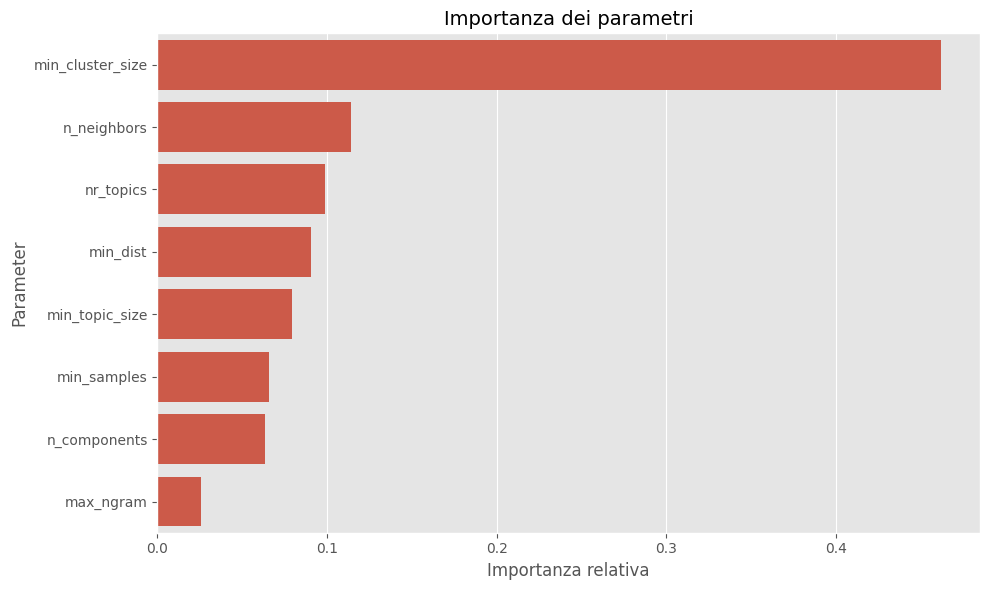

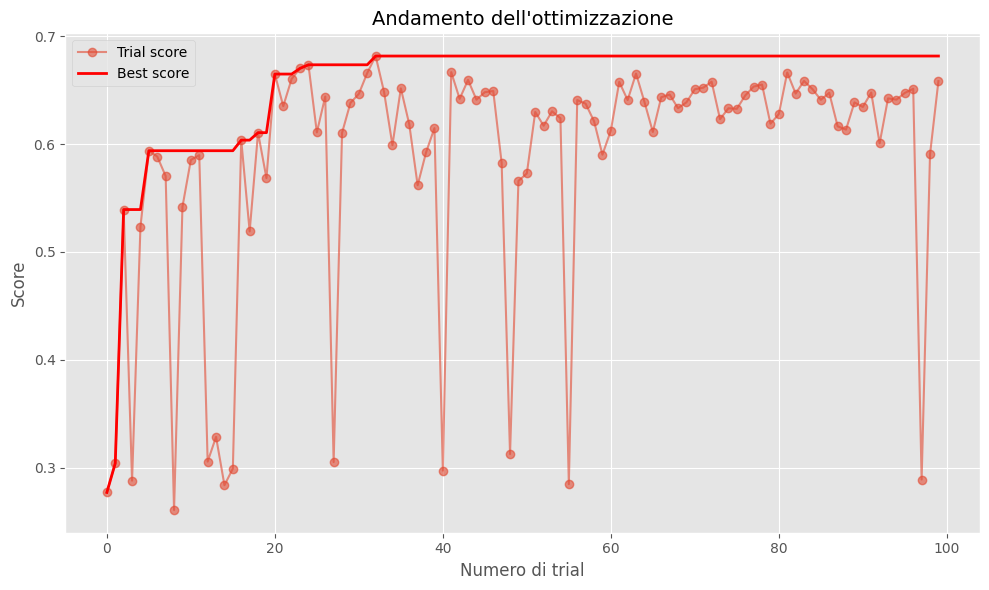

<Figure size 1200x1000 with 0 Axes>

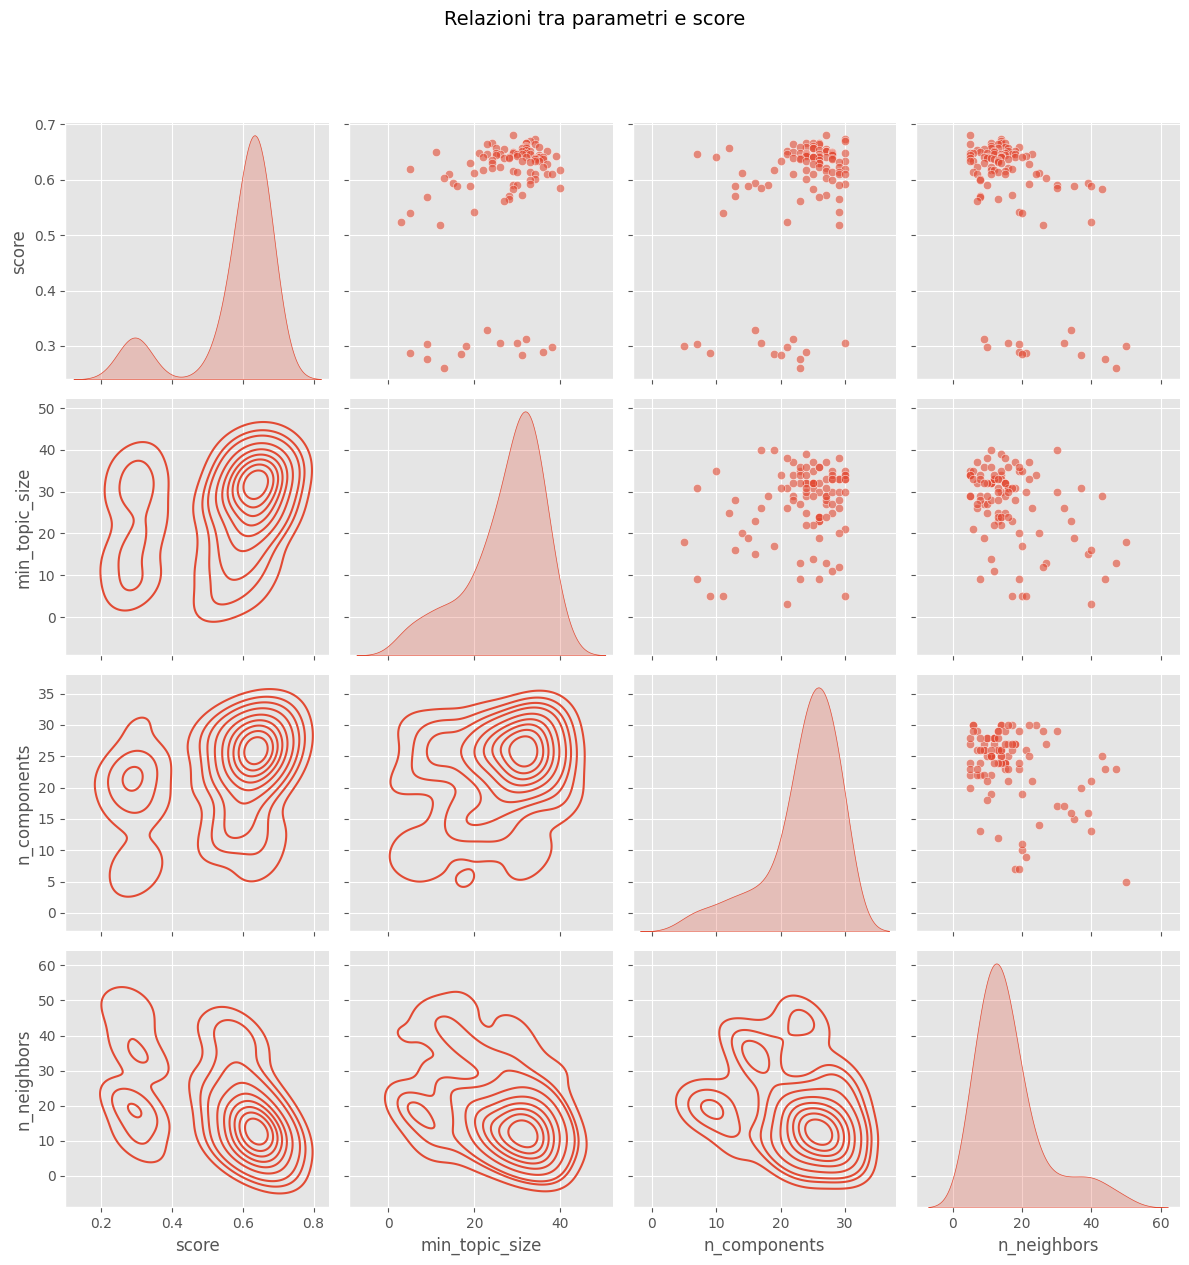

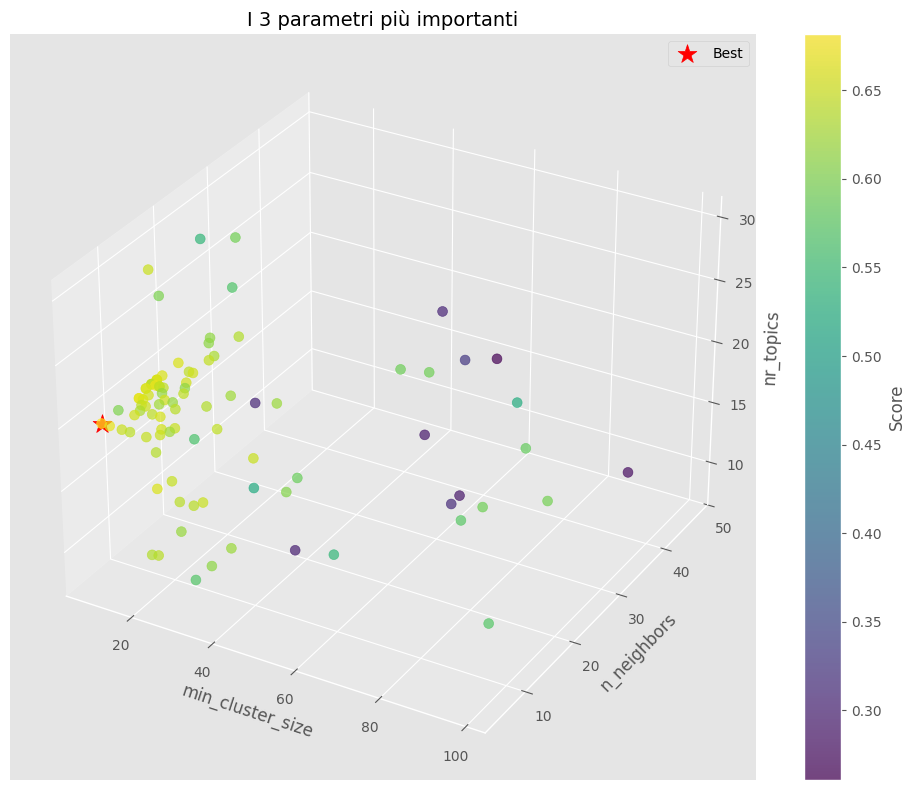

In [45]:
# Dopo aver completato l'ottimizzazione bayesianae
print("\n=== Visualizzazione dei risultati dell'ottimizzazione bayesiana ===")

# Estrai i risultati di tutti i trial
trials_df = pd.DataFrame([
    {
        'number': t.number,
        'score': t.value,
        **t.params
    }
    for t in study.trials
])

# Ordina per punteggio decrescente
trials_df = trials_df.sort_values('score', ascending=False).reset_index(drop=True)

# Mostra i migliori 10 trial
print("\nMigliori 10 combinazioni di parametri:")
print(trials_df.head(10))

# Configura il layout delle figure
plt.style.use('ggplot')

# 1. Grafico dell'importanza dei parametri (Plot separato)
plt.figure(figsize=(10, 6))
param_importances = optuna.importance.get_param_importances(study)
importance_df = pd.DataFrame({
    'Parameter': list(param_importances.keys()),
    'Importance': list(param_importances.values())
}).sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Parameter', data=importance_df)
plt.title('Importanza dei parametri', fontsize=14)
plt.xlabel('Importanza relativa')
plt.tight_layout()
plt.savefig('bayesian_most-importan-parameters.png')
plt.show()

# 2. Grafico di andamento dell'ottimizzazione (Plot separato)
plt.figure(figsize=(10, 6))
trial_scores = [t.value for t in study.trials]
best_scores = np.maximum.accumulate(trial_scores)
plt.plot(range(len(trial_scores)), trial_scores, 'o-', alpha=0.6, label='Trial score')
plt.plot(range(len(best_scores)), best_scores, 'r-', linewidth=2, label='Best score')
plt.xlabel('Numero di trial')
plt.ylabel('Score')
plt.title('Andamento dell\'ottimizzazione', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Bayesian_optimization.png')
plt.show()

# 3. Grafici di correlazione parametri-score (Plot separato)
if len(trials_df.columns) >= 4:  # Verifica che ci siano abbastanza colonne
    plt.figure(figsize=(12, 10))
    g = sns.PairGrid(trials_df[['score', 'min_topic_size', 'n_components', 'n_neighbors']], 
                    height=3, diag_sharey=False)
    g.map_upper(sns.scatterplot, alpha=0.6)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.kdeplot, fill=True)
    plt.suptitle('Relazioni tra parametri e score', y=1.05, fontsize=14)
    plt.tight_layout()
    plt.savefig('topic_correlation_parameters-score.png')
    plt.show()

# 4. Grafico a dispersione 3D per i 3 parametri più importanti (Plot separato)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Seleziona i 3 parametri più importanti
top_params = importance_df['Parameter'].tolist()[:3]
if len(top_params) >= 3:
    p1, p2, p3 = top_params[:3]
    
    # Assicurati che i dati siano array numerici
    x_data = pd.to_numeric(trials_df[p1], errors='coerce')
    y_data = pd.to_numeric(trials_df[p2], errors='coerce')
    z_data = pd.to_numeric(trials_df[p3], errors='coerce')
    
    # Verifica che non ci siano valori NaN
    valid_mask = ~(np.isnan(x_data) | np.isnan(y_data) | np.isnan(z_data))
    
    scatter = ax.scatter(x_data[valid_mask], y_data[valid_mask], z_data[valid_mask],
                        c=trials_df['score'][valid_mask], cmap='viridis',
                        s=50, alpha=0.7)
    
    # Evidenzia il miglior trial
    best_idx = trials_df['score'].idxmax()
    if valid_mask[best_idx]:  # Verifica che il miglior punto sia valido
        ax.scatter([float(trials_df.loc[best_idx, p1])],
                   [float(trials_df.loc[best_idx, p2])],
                   [float(trials_df.loc[best_idx, p3])],
                   c='red', s=200, marker='*', label='Best')
    
    ax.set_xlabel(p1)
    ax.set_ylabel(p2)
    ax.set_zlabel(p3)
    ax.set_title('I 3 parametri più importanti', fontsize=14)
    plt.colorbar(scatter, label='Score')
    plt.legend()
    plt.tight_layout()
    plt.savefig('mostimportanparams_3d.png')
    plt.show()

    #salva in un file png
    


##

# Recommendation system using sentence-transformer

Recommending for an article inside the dataset top_k articles using cosine similarity and topic assignment ( being in the same topic class gives a bonus)

In [46]:
embedding_model = joblib.load('embedding_model.pkl')
topic_model = joblib.load('best_bayes_topic_model.pkl')
embeddings = joblib.load('embeddings.pkl')#carico il modello di embedding, di topic modeling e gli embeddings



In [47]:
def recommend_articles(query_text, embedding_model, article_embeddings, df, top_k=5, topic_weight=0.5, consider_topics=True, exclude_idx=None, topic_model=None):
    """
    Raccomanda articoli basati su una query di testo, combinando similarità semantica e topic.
    
    Args:
        query_text (str): Il testo della query
        embedding_model: Il modello per l'embedding
        article_embeddings: Embeddings pre-calcolati degli articoli
        df (pd.DataFrame): DataFrame contenente gli articoli
        top_k (int): Numero di articoli da raccomandare
        topic_weight (float): Peso tra 0 e 1 da dare ai topic (1 = solo topic, 0 = solo semantica)
        consider_topics (bool): Se considerare i topic nella raccomandazione
        xclude_idx (int): Indice dell'articolo da escludere dalla raccomandazione
        
    Returns:
        pd.DataFrame: DataFrame contenente gli articoli raccomandati
    """
    try:
        # Verifica input
        if not query_text or embedding_model is None or df is None or df.empty or article_embeddings is None:
            print("Input non validi per la raccomandazione")
            return df.head(0)  # Ritorna DataFrame vuoto ma con colonne corrette
            
        # Calcola l'embedding della query
        query_embedding = embedding_model.encode(query_text, convert_to_tensor=True)
        query_embedding = query_embedding.cpu().numpy()
        
        # Importa cosine_similarity da sklearn
        from sklearn.metrics.pairwise import cosine_similarity
        
        # Calcola le similarità semantiche
        similarities = cosine_similarity([query_embedding], article_embeddings)[0]
        
        # Crea una copia del DataFrame per evitare modifiche all'originale
        result_df = df.copy()
        result_df['similarity'] = similarities

        # Escludiamo l'articolo originale se l'indice è fornito
        if exclude_idx is not None:
            result_df = result_df.drop(exclude_idx, errors='ignore')
        
        
         # Se vogliamo usare i topic e topic_weight > 0
        if consider_topics and topic_weight > 0 and 'topic' in df.columns:
            try:
                # Verifica che il modello sia funzionante
                if topic_model is None:
                    raise ValueError("Il modello di topic è None")
                e
                if 'topic' in df.columns:
                    # Trova il topic più comune tra i top N articoli più simili
                    top_similar_indices = np.argsort(similarities)[::-1][:10]  # Top 10 articoli simili
                    top_similar_topics = df.iloc[top_similar_indices]['topic'].value_counts()
                    
                    if not top_similar_topics.empty:
                        # Usa il topic più comune come "topic della query"
                        query_topic = top_similar_topics.index[0]
                        
                        # Ora possiamo procedere con la logica esistente
                        if query_topic != -1:  # Se il topic non è un outlier
                            # Calcola la penalità di topic (0 per lo stesso topic, 1 per topic diverso)
                            topic_penalty = np.ones(len(result_df))
                            
                            # Assegna penalità 0 agli articoli dello stesso topic
                            topic_penalty[result_df['topic'] == query_topic] = 0
                            
                            # Calcola il punteggio combinato
                            result_df['combined_score'] = (1 - topic_weight) * similarities[result_df.index] + topic_weight * (1 - topic_penalty)
                            
                            # Ordina per punteggio combinato
                            result_df = result_df.sort_values('combined_score', ascending=False)
                        else:
                            # Topic outlier, usa solo similarità
                            result_df = result_df.sort_values('similarity', ascending=False)
                    else:
                        # Nessun topic trovato nei top articoli, usa solo similarità
                        result_df = result_df.sort_values('similarity', ascending=False)
                else:
                    # Nessuna colonna topic, usa solo similarità
                    result_df = result_df.sort_values('similarity', ascending=False)
                    
            except Exception as e:
                # In caso di errore nel topic modeling, usa solo similarità semantica
                print(f"Errore nell'analisi dei topic: {str(e)}. Usando solo similarità semantica.")
                result_df = result_df.sort_values('similarity', ascending=False)
                
        # Esclude risultati identici (similarità > 0.95)
        result_df = result_df[result_df['similarity'] < 0.95]
        
        # Ritorna i top_k risultati
        return result_df.head(top_k)
    
    except Exception as e:
        print(f"Errore nella generazione delle raccomandazioni: {str(e)}")
        # Ritorna un DataFrame vuoto ma con la struttura corretta
        if df is not None and not df.empty:
            return df.head(0)
        else:
            # Se df non è valido, crea un DataFrame minimal
            return pd.DataFrame(columns=['title', 'abstract', 'similarity'])

In [48]:
def demonstrate_recommendations():
    """Dimostra il sistema di raccomandazione con un articolo campione"""
    
    # Seleziona un articolo casuale come esempio
    sample_idx = np.random.choice(len(df))
    title = df.iloc[sample_idx]['title']
    abstract = df.iloc[sample_idx]['abstract']
    
    print("\nArticolo di esempio:")
    print(f"Titolo: {title}")
    print(f"Abstract: {abstract[:400]}...")
    
    # Combina titolo e abstract come query
    query_text = f"{title}. {abstract}" if abstract else title
    
    # Utilizza il sistema di raccomandazione migliorato
    recommendations = recommend_articles(
        query_text, 
        best_embedding_model,
        best_embeddings,
        df, 
        top_k=7,
        consider_topics=True,
        topic_weight=0.3,
        exclude_idx=sample_idx,  # Escludiamo l'articolo di origine
        topic_model=topic_model  # Passa il modello di topic
    )
    
    if recommendations is None or recommendations.empty:
        print("\nNessun articolo raccomandato.")
        return
    
    print("\nArticoli raccomandati:")
    for i, (rec_idx, rec) in enumerate(recommendations.iterrows(), 1):
        similarity = rec['similarity']
        rec_title = rec['title']
        print(f"{i}. [{similarity:.4f}] {rec_title}")
        print("-" * 80)


demonstrate_recommendations()


Articolo di esempio:
Titolo: The First Real-Time Blockchain VAT - GCC Solves MTIC Fraud
Abstract: Following years of study the Gulf Cooperation Council (GCC) appears ready to adopt the recommendations of the International Monetary Fund (IMF) and put in place a tax system that will stabilize revenue. A value added tax (VAT) and corporate income tax (CIT) are considered. A VAT Framework Agreement, that functions like the VAT Directive in the EU, has been agreed....
Errore nell'analisi dei topic: cannot access local variable 'e' where it is not associated with a value. Usando solo similarità semantica.

Articoli raccomandati:
1. [0.8943] Blockchain, Bitcoin, and VAT in the GCC: The Missing Trader Example
--------------------------------------------------------------------------------
2. [0.6598] The Blockchain Revolution: An Analysis of Regulation and Technology Related to Distributed Ledger Technologies
--------------------------------------------------------------------------------
3. 

##

# SUMMARIZATION

Abbiamo valutato che il riassunto estrattivo è molto più veloce ed efficiente di riassunto generativo, anche se perde in precisione ed completezza ( rispetto a una valutazione umana , perche in realta roige dicono il contrario) (ma per i nostri fini è sufficiente, in quanto utente in interfaccia visualizza rapidamente il riassunto e se l'articolo gli interessa è ridirezionato all'articolo completo. Il riassunto serve solo per dare un idea rapida del contenuto).

In [49]:
embedding_model = joblib.load('embedding_model.pkl')
topic_model = joblib.load('best_bayes_topic_model.pkl')
embeddings = joblib.load('embeddings.pkl')

In [50]:
import pandas as pd
import numpy as np
import spacy
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rouge import Rouge
from transformers import pipeline
import random

def compare_summarization_methods(n_articles=25, generate_full_dataset_summaries=False):
    """
    Compares extractive and abstractive summarization methods on a subset of articles
    
    Parameters:
    -----------
    n_articles : int, default=25
        Number of articles to use for comparison
    generate_full_dataset_summaries : bool, default=False
        Whether to generate extractive summaries for the entire dataset
    """
    print("Loading dataset...")
    # Load your specific dataset file
    try:
        df = pd.read_parquet("openalex_articles_copy.parquet")
        print(f"Successfully loaded dataset with {len(df)} articles")
    except FileNotFoundError:
        print("Error: Dataset file 'openalex_articles_copy.parquet' not found.")
        return None, None
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None, None
    
    # Ensure abstract column exists and fill NA values
    if 'abstract' not in df.columns:
        print("Error: Dataset does not contain an 'abstract' column.")
        return None, None
    
    df["abstract"] = df["abstract"].fillna("").astype(str)
    
    # Filter for articles with valid abstracts
    df = df[df["abstract"].str.len() > 10]
    print(f"Found {len(df)} articles with valid abstracts")
    
    if len(df) < n_articles:
        print(f"Warning: Only {len(df)} valid articles available.")
        n_articles = len(df)
    
    # Select a random sample of articles
    sample_df = df.sample(n_articles, random_state=42)
    
    # Initialize SpaCy and transformers models
    print("Loading NLP models...")
    nlp = spacy.load("en_core_web_sm")
    
    # Initialize the abstractive summarizer
    try:
        print("Loading Falconsai summarization model...")
        abstractive_summarizer = pipeline("summarization", model="Falconsai/text_summarization")
        print("Model loaded successfully!")
    except Exception as e:
        print(f"Error loading Falconsai model: {e}")
        print("Using a fallback model...")
        try:
            abstractive_summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
            print("Fallback model loaded successfully!")
        except Exception as e:
            print(f"Error loading fallback model: {e}")
            return None, None
    
    # Initialize Rouge metric
    try:
        rouge = Rouge()
        print("Rouge evaluation metric initialized")
    except Exception as e:
        print(f"Error initializing Rouge: {e}")
        return None, None
    
    # Results storage
    results = []
    
    print(f"Comparing summarization methods for {n_articles} articles...")
    for index, row in tqdm(sample_df.iterrows(), total=n_articles):
        abstract = row['abstract']
        
        # Skip if abstract is too short
        if len(abstract.split()) < 50:
            print(f"Skipping article {index} - abstract too short ({len(abstract.split())} words)")
            continue
            
        # Original abstract stats
        abstract_word_count = len(abstract.split())
        
        # 1. Extractive Summarization
        extractive_start = time.time()
        extractive_summary = extractive_summarize(abstract, nlp, num_sentences=3)
        extractive_time = (time.time() - extractive_start) * 1000  # Convert to ms
        
        # 2. Abstractive Summarization
        abstractive_start = time.time()
        try:
            # Usa direttamente il tokenizer del modello per troncare correttamente
            tokenizer = abstractive_summarizer.tokenizer
            inputs = tokenizer(abstract, truncation=True, max_length=512, return_tensors="pt")
            
            # Calcola la lunghezza massima e minima del riassunto
            max_length = min(150, max(50, len(abstract.split()) // 3))
            min_length = max(30, max_length // 2)
            
            # Genera il riassunto usando gli input tokenizzati
            summary_ids = abstractive_summarizer.model.generate(
                inputs["input_ids"],
                max_length=max_length,
                min_length=min_length,
                num_beams=4,
                no_repeat_ngram_size=2,
                early_stopping=True
            )
            
            abstractive_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        except Exception as e:
            print(f"Error in abstractive summarization for article {index}: {e}")
            abstractive_summary = "Error generating summary"
        abstractive_time = (time.time() - extractive_start) * 1000  # Convert to ms
        
        # Skip comparison if either summary failed
        if not extractive_summary or abstractive_summary == "Error generating summary":
            print(f"Skipping article {index} - summarization failed")
            continue
        
        # Compression ratios
        extractive_word_count = len(extractive_summary.split())
        abstractive_word_count = len(abstractive_summary.split())
        extractive_compression = extractive_word_count / abstract_word_count
        abstractive_compression = abstractive_word_count / abstract_word_count
        
        # Calculate ROUGE scores (comparing each summary to the original abstract)
        try:
            extractive_rouge = rouge.get_scores(extractive_summary, abstract)[0]
            abstractive_rouge = rouge.get_scores(abstractive_summary, abstract)[0]
        except Exception as e:
            print(f"Error calculating ROUGE for article {index}: {e}")
            continue
        
        # Store results
        results.append({
            'article_id': index,
            'abstract_length': abstract_word_count,
            'extractive_length': extractive_word_count,
            'abstractive_length': abstractive_word_count,
            'extractive_compression': extractive_compression,
            'abstractive_compression': abstractive_compression,
            'extractive_rouge1_f': extractive_rouge['rouge-1']['f'],
            'extractive_rouge2_f': extractive_rouge['rouge-2']['f'],
            'extractive_rougeL_f': extractive_rouge['rouge-l']['f'],
            'abstractive_rouge1_f': abstractive_rouge['rouge-1']['f'],
            'abstractive_rouge2_f': abstractive_rouge['rouge-2']['f'],
            'abstractive_rougeL_f': abstractive_rouge['rouge-l']['f'],
            'extractive_time_ms': extractive_time,
            'abstractive_time_ms': abstractive_time,
            'extractive_summary': extractive_summary,
            'abstractive_summary': abstractive_summary,
            'abstract': abstract[:300] + "..." # Store a preview of the original abstract
        })
    
    # Skip further processing if no results
    if len(results) == 0:
        print("No valid comparison results obtained. Please check the errors above.")
        return None, None
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Save detailed results to CSV
    results_df.to_csv('summarization_comparison_results.csv', index=False)
    print(f"Detailed results saved to 'summarization_comparison_results.csv' ({len(results_df)} articles)")
    
    # Calculate averages for key metrics
    avg_metrics = {
        'Extractive ROUGE-1': results_df['extractive_rouge1_f'].mean(),
        'Extractive ROUGE-2': results_df['extractive_rouge2_f'].mean(),
        'Extractive ROUGE-L': results_df['extractive_rougeL_f'].mean(),
        'Abstractive ROUGE-1': results_df['abstractive_rouge1_f'].mean(),
        'Abstractive ROUGE-2': results_df['abstractive_rouge2_f'].mean(),
        'Abstractive ROUGE-L': results_df['abstractive_rougeL_f'].mean(),
        'Extractive Time (ms)': results_df['extractive_time_ms'].mean(),
        'Abstractive Time (ms)': results_df['abstractive_time_ms'].mean(),
        'Extractive Compression': results_df['extractive_compression'].mean(),
        'Abstractive Compression': results_df['abstractive_compression'].mean()
    }
    
    print("\nSummarization Comparison Results:")
    print("---------------------------------")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Create visualizations
    create_comparison_visualizations(results_df)
    
    # Generate summaries for all articles in the dataset if requested
    if generate_full_dataset_summaries:
        print("\nGenerating extractive summaries for the entire dataset...")
        generate_extractive_summaries_for_dataset(df, nlp)
    
    return results_df, avg_metrics

def extractive_summarize(text, nlp, num_sentences=3):
    """
    Extractive summarization using TF-IDF and cosine similarity
    
    Parameters:
    -----------
    text : str
        The text to summarize
    nlp : spacy.lang model
        Initialized spaCy model for sentence splitting
    num_sentences : int, default=3
        Number of sentences to include in the summary
    """
    if not isinstance(text, str) or pd.isna(text) or len(text.strip()) < 50:
        return None
    
    try:
        # Split into sentences
        doc = nlp(text)
        sentences = [sent.text for sent in doc.sents]
        
        if len(sentences) <= num_sentences:
            return text
        
        # Create TF-IDF vectors
        vectorizer = TfidfVectorizer(stop_words='english')
        sentence_vectors = vectorizer.fit_transform(sentences)

        # Score sentences by similarity to mean vector
        sentence_scores = []
        for i in range(len(sentences)):
            mean_vector = np.asarray(sentence_vectors.mean(axis=0)).reshape(1, -1)
            similarity = cosine_similarity(sentence_vectors[i:i+1], mean_vector)[0][0]
            sentence_scores.append((i, similarity, len(sentences[i].split())))
        
        # Select top sentences
        ranked_sentences = sorted(sentence_scores, key=lambda x: x[1], reverse=True)
        selected_indices = sorted([x[0] for x in ranked_sentences[:num_sentences]])

        # Create summary
        summary = ' '.join([sentences[i] for i in selected_indices])
        return summary

    except Exception as e:
        print(f"Error in extractive summarization: {str(e)}")
        return None

def generate_extractive_summaries_for_dataset(df, nlp):
    """
    Generates extractive summaries for the entire dataset
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataset containing articles
    nlp : spacy.lang model
        Initialized spaCy model
    """
    print("Generating extractive summaries for all articles...")
    
    # Create a copy of the dataframe
    processed_df = df.copy()
    
    # Add summary column if it doesn't exist
    if 'summary' not in processed_df.columns:
        processed_df['summary'] = None
    
    # Filter for valid abstracts
    valid_mask = processed_df["abstract"].str.len() > 10
    valid_indices = processed_df.index[valid_mask]
    
    print(f"Processing {len(valid_indices)} articles with valid abstracts out of {len(df)} total...")
    
    # Process in batches for progress tracking
    batch_size = 100
    for i in tqdm(range(0, len(valid_indices), batch_size)):
        batch_indices = valid_indices[i:i+batch_size]
        for idx in batch_indices:
            abstract = processed_df.loc[idx, 'abstract']
            processed_df.loc[idx, 'summary'] = extractive_summarize(abstract, nlp)
    
    # Count successful summaries
    successful_summaries = processed_df['summary'].notna().sum()
    print(f"Summaries generated successfully: {successful_summaries}/{len(valid_indices)} "
          f"({successful_summaries/len(valid_indices)*100:.1f}%)")
    
    # Save the processed dataframe
    processed_df.to_parquet("articles_with_summaries.parquet", index=False)
    print("Dataset with summaries saved to 'articles_with_summaries.parquet'")

def create_comparison_visualizations(results_df):
    """
    Creates visualizations comparing summarization methods
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        DataFrame containing comparison results
    """
    print("Creating comparison visualizations...")
    
    # Set up the figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Comparison of Summarization Methods', fontsize=16)
    
    # 1. ROUGE Scores Comparison (Top left)
    rouge_data = {
        'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L'] * 2,
        'Method': ['Extractive'] * 3 + ['Abstractive'] * 3,
        'Score': [
            results_df['extractive_rouge1_f'].mean(),
            results_df['extractive_rouge2_f'].mean(),
            results_df['extractive_rougeL_f'].mean(),
            results_df['abstractive_rouge1_f'].mean(),
            results_df['abstractive_rouge2_f'].mean(),
            results_df['abstractive_rougeL_f'].mean()
        ]
    }
    rouge_df = pd.DataFrame(rouge_data)
    
    sns.barplot(x='Metric', y='Score', hue='Method', data=rouge_df, ax=axes[0, 0])
    axes[0, 0].set_title('ROUGE Scores Comparison')
    axes[0, 0].set_ylim(0, 1)
    
    # 2. Processing Time Comparison (Top right)
    time_data = {
        'Method': ['Extractive', 'Abstractive'],
        'Time (ms)': [
            results_df['extractive_time_ms'].mean(),
            results_df['abstractive_time_ms'].mean()
        ]
    }
    time_df = pd.DataFrame(time_data)
    
    sns.barplot(x='Method', y='Time (ms)', data=time_df, ax=axes[0, 1])
    axes[0, 1].set_title('Average Processing Time')
    axes[0, 1].set_yscale('log')  # Log scale for better visualization
    
    # 3. Compression Ratio (Bottom left)
    compression_data = {
        'Method': ['Extractive', 'Abstractive'],
        'Compression Ratio': [
            results_df['extractive_compression'].mean(),
            results_df['abstractive_compression'].mean()
        ]
    }
    compression_df = pd.DataFrame(compression_data)
    
    sns.barplot(x='Method', y='Compression Ratio', data=compression_df, ax=axes[1, 0])
    axes[1, 0].set_title('Average Compression Ratio')
    axes[1, 0].set_ylim(0, 1)
    
    # 4. ROUGE-1 vs Summary Length Scatter (Bottom right)
    axes[1, 1].scatter(
        results_df['extractive_length'], 
        results_df['extractive_rouge1_f'],
        alpha=0.7,
        label='Extractive'
    )
    axes[1, 1].scatter(
        results_df['abstractive_length'], 
        results_df['abstractive_rouge1_f'],
        alpha=0.7,
        label='Abstractive'
    )
    axes[1, 1].set_xlabel('Summary Length (words)')
    axes[1, 1].set_ylabel('ROUGE-1 Score')
    axes[1, 1].set_title('ROUGE-1 Score vs Summary Length')
    axes[1, 1].legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('summarization_comparison.png', dpi=300, bbox_inches='tight')
    print("Main comparison visualization saved to 'summarization_comparison.png'")
    plt.close()
    
    # Create an additional figure for example summaries
    create_example_visualization(results_df)
    
def create_example_visualization(results_df):
    """
    Creates a visualization with example summaries
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        DataFrame containing comparison results
    """
    # Select one example with good scores for both methods
    good_examples = results_df[
        (results_df['extractive_rouge1_f'] > results_df['extractive_rouge1_f'].median()) &
        (results_df['abstractive_rouge1_f'] > results_df['abstractive_rouge1_f'].median())
    ]
    
    if len(good_examples) > 0:
        example = good_examples.iloc[0]
    else:
        example = results_df.iloc[0]
    
    # Create figure for text comparison
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.axis('off')
    
    # Prepare text
    example_text = (
        f"SUMMARIZATION METHODS COMPARISON EXAMPLE\n\n"
        f"ORIGINAL ABSTRACT ({len(example['abstract'].split())} words):\n"
        f"{example['abstract']}\n\n"
        f"EXTRACTIVE SUMMARY ({example['extractive_length']} words, "
        f"ROUGE-1: {example['extractive_rouge1_f']:.3f}):\n"
        f"{example['extractive_summary']}\n\n"
        f"ABSTRACTIVE SUMMARY ({example['abstractive_length']} words, "
        f"ROUGE-1: {example['abstractive_rouge1_f']:.3f}):\n"
        f"{example['abstractive_summary']}"
    )
    
    ax.text(0.05, 0.95, example_text, 
            verticalalignment='top', 
            horizontalalignment='left',
            wrap=True, 
            fontsize=12)
    
    plt.savefig('summarization_example.png', dpi=300, bbox_inches='tight')
    print("Example summaries visualization saved to 'summarization_example.png'")
    plt.close()

if __name__ == "__main__":
    print("Starting summarization methods comparison...")
    results_df, avg_metrics = compare_summarization_methods(n_articles=30, generate_full_dataset_summaries=True)
    
    if results_df is not None and avg_metrics is not None:
        # Create a formatted table for the report
        metrics_table = pd.DataFrame({
            'Method': ['Extractive (TF-IDF)', 'Abstractive (Falconsai)'],
            'ROUGE-1': [avg_metrics['Extractive ROUGE-1'], avg_metrics['Abstractive ROUGE-1']],
            'ROUGE-2': [avg_metrics['Extractive ROUGE-2'], avg_metrics['Abstractive ROUGE-2']],
            'ROUGE-L': [avg_metrics['Extractive ROUGE-L'], avg_metrics['Abstractive ROUGE-L']],
            'Processing Time (ms/doc)': [avg_metrics['Extractive Time (ms)'], avg_metrics['Abstractive Time (ms)']],
            'Compression Ratio': [avg_metrics['Extractive Compression'], avg_metrics['Abstractive Compression']],
        })
        
        # Format the metrics table
        for col in metrics_table.columns:
            if col != 'Method':
                metrics_table[col] = metrics_table[col].round(3)
        
        # Save the metrics table
        metrics_table.to_csv('summarization_metrics_table.csv', index=False)
        print("\nSummarization metrics table saved to 'summarization_metrics_table.csv'")
        print("\nAll tasks completed successfully!")
    else:
        print("\nComparison process failed. Please check the errors above.")

Starting summarization methods comparison...
Loading dataset...
Successfully loaded dataset with 6432 articles
Found 6432 articles with valid abstracts
Loading NLP models...
Loading Falconsai summarization model...


Device set to use cpu


Model loaded successfully!
Rouge evaluation metric initialized
Comparing summarization methods for 30 articles...


  0%|          | 0/30 [00:00<?, ?it/s]

Detailed results saved to 'summarization_comparison_results.csv' (30 articles)

Summarization Comparison Results:
---------------------------------
Extractive ROUGE-1: 0.6268
Extractive ROUGE-2: 0.5765
Extractive ROUGE-L: 0.6268
Abstractive ROUGE-1: 0.4899
Abstractive ROUGE-2: 0.3756
Abstractive ROUGE-L: 0.4889
Extractive Time (ms): 212.9194
Abstractive Time (ms): 7797.7242
Extractive Compression: 0.4349
Abstractive Compression: 0.2550
Creating comparison visualizations...
Main comparison visualization saved to 'summarization_comparison.png'
Example summaries visualization saved to 'summarization_example.png'

Generating extractive summaries for the entire dataset...
Generating extractive summaries for all articles...
Processing 6432 articles with valid abstracts out of 6432 total...


  0%|          | 0/65 [00:00<?, ?it/s]

Summaries generated successfully: 6430/6432 (100.0%)
Dataset with summaries saved to 'articles_with_summaries.parquet'

Summarization metrics table saved to 'summarization_metrics_table.csv'

All tasks completed successfully!


In [51]:
#visualizzo alcuni riassunti da articoli a caso in result_df
for i in range(5):
    print(f"Article {i+1}:\n")
    print(f"Original Abstract: {results_df.iloc[i]['abstract'][:200]}...\n")
    print(f"Extractive Summary: {results_df.iloc[i]['extractive_summary']}\n")
    print(f"Abstractive Summary: {results_df.iloc[i]['abstractive_summary']}\n")
    print("-" * 80)

Article 1:

Original Abstract: In modern smart grids, the focus is increasingly shifted towards distributed energy resources and flexible electricity assets owned by prosumers. A system with high penetration of flexible prosumers, ...

Extractive Summary: In this paper we present an auction-theoretic scheme for a setting with non-convex prosumer models and resource constraints. A game-theoretic analysis is made with respect to how an intelligent agent, that bids on behalf of a prosumer can try to strategize within the auction, in order to make itself better-off. Our simulations show that there is an alignment of incentives, i.e., when the prosumers try to strategize, they actually improve the auction's efficiency.

Abstractive Summary: for a setting with non-convex prosumer models and resource constraints. In modern smart grids, the focus is increasingly shifted towards distributed energy resources and flexible electricity assets owned by prossumers. An auction-theoretic scheme is base

# KEY METRICS

calcolo metriche per valutare topic model, embeddings quality, recommmendation system, statistiche generali del dataset

In [53]:
embedding_model = joblib.load('embedding_model.pkl')
topic_model = joblib.load('best_bayes_topic_model.pkl')
embeddings = joblib.load('embeddings.pkl')

In [54]:
def calculate_precision_at_k(model, embedding_model, test_data, full_df, article_embeddings, k=5, batch_size=50, num_batches=10):
    """
    Calcola Precision@K con più batch e media i risultati.
    
    Parameters:
    - model: Il modello di topic
    - embedding_model: Modello per creare gli embedding
    - test_data: DataFrame contenente gli articoli di test
    - full_df: Dataset completo da cui test_data è stato campionato (con indici originali)
    - article_embeddings: Embedding per l'intero dataset
    - k: Numero di raccomandazioni da valutare
    - batch_size: Dimensione di ogni batch di valutazione
    - num_batches: Numero di batch da valutare
    
    Returns:
    - mean_precision: Precisione media su tutti i batch
    - std_precision: Deviazione standard della precisione
    - confidence_interval: Intervallo di confidenza al 95%
    - precision_scores: Lista con tutte le precisioni calcolate
    """
    import numpy as np
    import random
    from tqdm import tqdm
    
    precision_scores = []
    
    # Assicurati di avere abbastanza dati per tutti i batch
    max_batches = min(num_batches, len(test_data) // batch_size)
    
    for i in tqdm(range(max_batches), desc="Valutazione batch"):
        # Campiona un batch di articoli
        batch_indices = random.sample(range(len(test_data)), batch_size)
        batch_data = test_data.iloc[batch_indices]
        
        batch_precision = []
        
        for idx, article in batch_data.iterrows():
            # Prendi il topic direttamente dal DataFrame se disponibile
            if 'topic' in article and article['topic'] != -1:
                article_topic = article['topic']
                article_text = f"{article.get('title', '')}. {article.get('abstract', '')}"
                
                try:
                    # Usa direttamente l'embedding del documento se possibile
                    if hasattr(article_embeddings, 'shape'):
                        # Se è un array numpy, l'indice è la posizione nel DataFrame
                        if idx in full_df.index:
                            position = full_df.index.get_loc(idx)
                            article_embedding = article_embeddings[position]
                        else:
                            # Calcola l'embedding manualmente
                            article_embedding = embedding_model.encode(article_text, convert_to_tensor=True)
                            article_embedding = article_embedding.cpu().numpy()
                    else:
                        # Se non è un array numpy, prova a usare l'indice direttamente
                        position = idx if idx < len(article_embeddings) else -1
                        if position >= 0:
                            article_embedding = article_embeddings[position]
                        else:
                            # Calcola l'embedding manualmente
                            article_embedding = embedding_model.encode(article_text, convert_to_tensor=True)
                            article_embedding = article_embedding.cpu().numpy()
                    
                    # Calcola similarità semantica con tutti gli articoli
                    from sklearn.metrics.pairwise import cosine_similarity
                    similarities = cosine_similarity([article_embedding], article_embeddings)[0]
                    
                    # Crea risultati ordinati
                    result_df = full_df.copy()
                    result_df['similarity'] = similarities
                    
                    # Escludiamo l'articolo originale
                    if idx in result_df.index:
                        result_df = result_df.drop(idx)
                    
                    # Filtra per stesso topic se richiesto
                    if 'topic' in result_df.columns:
                        topic_df = result_df[result_df['topic'] == article_topic]
                        other_df = result_df[result_df['topic'] != article_topic]
                        
                        # Seleziona le top raccomandazioni
                        topic_recommendations = topic_df.sort_values('similarity', ascending=False).head(k)
                        other_recommendations = other_df.sort_values('similarity', ascending=False).head(k)
                        
                        # Combina e prendi le top k
                        combined = pd.concat([topic_recommendations, other_recommendations])
                        recommendations = combined.sort_values('similarity', ascending=False).head(k)
                    else:
                        # Senza informazioni di topic, usa solo similarità
                        recommendations = result_df.sort_values('similarity', ascending=False).head(k)
                    
                    # Calcola precisione - verifica quanti articoli raccomandati hanno lo stesso topic
                    if not recommendations.empty and 'topic' in recommendations.columns:
                        correct_recommendations = sum(recommendations['topic'] == article_topic)
                        precision = correct_recommendations / len(recommendations)
                        batch_precision.append(precision)
                except Exception as e:
                    print(f"Errore nell'elaborazione dell'articolo {idx}: {str(e)}")
                    continue
        
        if batch_precision:
            avg_batch_precision = np.mean(batch_precision)
            precision_scores.append(avg_batch_precision)
    
    # Calcola statistiche
    if precision_scores:
        mean_precision = np.mean(precision_scores)
        std_precision = np.std(precision_scores)
        
        # Intervallo di confidenza al 95%
        confidence_interval = 1.96 * std_precision / np.sqrt(len(precision_scores))
    else:
        mean_precision = 0
        std_precision = 0
        confidence_interval = 0
    
    return mean_precision, std_precision, confidence_interval, precision_scores


def calculate_topic_coherence(model, test_data, topics_to_evaluate=10):
    """
    Calcola il punteggio di coerenza del topic basato sulla co-occorrenza dei termini
    
    Parameters:
    - model: Il modello di topic
    - test_data: DataFrame contenente gli articoli di test
    - topics_to_evaluate: Numero di top topic da valutare
    
    Returns:
    - coherence_scores: Dizionario con i punteggi di coerenza per topic
    """
    coherence_scores = {}
    
    # Ottieni informazioni sui topic ordinate per dimensione
    topic_info = model.get_topic_info()
    # Filtra gli outlier (-1) e ordina per conteggio
    top_topics = topic_info[topic_info['Topic'] != -1].sort_values('Count', ascending=False)['Topic'].head(topics_to_evaluate).tolist()
    
    for topic_id in top_topics:
        # Ottieni i top termini per questo topic
        top_terms = [term for term, _ in model.get_topic(topic_id)][:10]
        
        # Crea una matrice di co-occorrenza
        term_doc_matrix = np.zeros((len(top_terms), len(test_data)))
        
        # Riempi la matrice termine-documento
        for i, term in enumerate(top_terms):
            for j, doc in enumerate(test_data['abstract']):
                if isinstance(doc, str) and term.lower() in doc.lower():
                    term_doc_matrix[i, j] = 1
        
        # Calcola coerenza a coppie
        coherence = 0
        count = 0
        
        for i in range(len(top_terms)):
            for j in range(i+1, len(top_terms)):
                # Calcola co-occorrenza
                co_occur = np.sum(term_doc_matrix[i] * term_doc_matrix[j])
                occur_i = np.sum(term_doc_matrix[i])
                occur_j = np.sum(term_doc_matrix[j])
                
                # Evita divisione per zero
                if occur_i > 0 and occur_j > 0 and  co_occur > 0:
                    # Calcola PMI (Pointwise Mutual Information)
                    pmi = np.log((co_occur * len(test_data)) / (occur_i * occur_j))
                    coherence += max(0, pmi)  # Conta solo PMI positivo
                    count += 1
        
        # Coerenza media
        if count > 0:
            coherence_scores[topic_id] = coherence / count
        else:
            coherence_scores[topic_id] = 0
    
    return coherence_scores


def calculate_topic_diversity(model, num_topics=20, num_terms=20):
    """
    Calcola la diversità dei topic basata sui termini unici tra i topic
    
    Parameters:
    - model: Il modello di topic
    - num_topics: Numero di topic da considerare
    - num_terms: Numero di top termini per topic da considerare
    
    Returns:
    - diversity_score: Punteggio di diversità dei topic (0-1)
    """
    # Ottieni informazioni sui topic
    topic_info = model.get_topic_info()
    topics = topic_info[topic_info['Topic'] != -1]['Topic'].head(num_topics).tolist()
    
    # Raccogli tutti i termini
    all_terms = []
    for topic_id in topics:
        top_terms = [term for term, _ in model.get_topic(topic_id)[:num_terms]]
        all_terms.extend(top_terms)
    
    # Calcola diversità come rapporto tra termini unici e termini totali
    diversity_score = len(set(all_terms)) / len(all_terms) if all_terms else 0
    
    return diversity_score




In [55]:
def calculate_key_metrics(df, topic_model, article_embeddings, embedding_model):
    """
    Calcola le metriche chiave per il modello di topic e il sistema di raccomandazione,
    utilizzando i metodi originali per precision_k, coherence, diversity e silhouette.
    
    Args:
        df: DataFrame con gli articoli
        topic_model: Modello di topic addestrato
        article_embeddings: Embeddings degli articoli
        embedding_model: Modello per gli embedding
        
    Returns:
        dict: Dizionario contenente le metriche calcolate
    """
    import numpy as np
    from collections import Counter
    
    metrics = {}
    
    print("Calcolo delle metriche chiave in corso...")
    
    # Ottieni i topic assegnati dal DataFrame
    if 'topic' in df.columns:
        topics = df['topic'].tolist()
    else:
        print("ATTENZIONE: colonna 'topic' non trovata nel DataFrame")
        topics = [-1] * len(df)  # Assumi tutti outlier se manca la colonna topic
    
    # 1. METRICHE DI ELABORAZIONE
    total_articles = len(df)
    # Considerati come "scartati" i documenti che sono stati classificati come outlier (-1)
    discarded_articles = sum(1 for t in topics if t == -1)
    processed_articles = total_articles - discarded_articles  # Articoli non classificati come outlier
    metrics['total_articles'] = total_articles
    metrics['processed_articles'] = processed_articles
    metrics['processing_rate'] = processed_articles / total_articles * 100
    
    # 2. METRICHE DI RILEVANZA
    # Definizione delle parole chiave per valutare la rilevanza
    keywords_ai = ["ai", "artificial intelligence", "machine learning", "deep learning", "neural networks"]
    keywords_pricing = ["pricing", "promotion", "marketing", "discount", "dynamic pricing", "price optimization"]
    keywords_gdo = ["gdo", "retail", "supermarket", "large-scale distribution", "supply chain"]
    
    def check_relevance(text, keywords_sets):
        if not isinstance(text, str):
            return 0
            
        text = text.lower()
        # Calcola quanti set di keywords sono presenti nel testo
        matches = sum(1 for keywords in keywords_sets if any(kw in text for kw in keywords))
        
        # Rilevante se contiene almeno 2 categorie di keywords
        if matches >= 2:
            return 2  # Altamente rilevante
        elif matches == 1:
            return 1  # Parzialmente rilevante
        else:
            return 0  # Non rilevante
    
    # Combina titolo e abstract in un unico campo per la valutazione della rilevanza
    try:
        df['text_for_relevance'] = df['title'].fillna('') + '. ' + df['abstract'].fillna('')
        df['relevance_score'] = df['text_for_relevance'].apply(
            lambda x: check_relevance(x, [keywords_ai, keywords_pricing, keywords_gdo])
        )
    except KeyError:
        print("ATTENZIONE: colonne necessarie per la rilevanza non trovate")
        if 'text' in df.columns:
            df['relevance_score'] = df['text'].apply(
                lambda x: check_relevance(x, [keywords_ai, keywords_pricing, keywords_gdo])
            )
        else:
            print("Creazione colonna text per valutazione rilevanza")
            df['text'] = df['abstract'].fillna('') if 'abstract' in df.columns else ''
            df['relevance_score'] = df['text'].apply(
                lambda x: check_relevance(x, [keywords_ai, keywords_pricing, keywords_gdo])
            )
    
    relevant_count = sum(df['relevance_score'] == 2)
    partial_count = sum(df['relevance_score'] == 1)
    non_relevant_count = sum(df['relevance_score'] == 0)
    
    metrics['relevant_articles'] = relevant_count
    metrics['partially_relevant_articles'] = partial_count
    metrics['non_relevant_articles'] = non_relevant_count
    metrics['relevant_percentage'] = relevant_count / total_articles * 100
    metrics['partially_relevant_percentage'] = partial_count / total_articles * 100
    metrics['non_relevant_percentage'] = non_relevant_count / total_articles * 100
    
    # 3. METRICHE DI TOPIC MODELING
    topic_counts = Counter(topics)
    outliers = topic_counts.get(-1, 0)  # Conta documenti classificati come outlier (topic -1)
    
    metrics['total_topics'] = len(topic_counts) - (1 if -1 in topic_counts else 0)  # Escludi outlier
    metrics['outlier_count'] = outliers
    metrics['outlier_percentage'] = outliers / len(topics) * 100
    
    # Distribuzione degli articoli tra i topic
    topic_distribution = {topic: count for topic, count in topic_counts.items() if topic != -1}
    metrics['topic_distribution'] = topic_distribution
    metrics['largest_topic_size'] = max(topic_distribution.values()) if topic_distribution else 0
    metrics['smallest_topic_size'] = min(topic_distribution.values()) if topic_distribution else 0
    metrics['avg_topic_size'] = np.mean(list(topic_distribution.values())) if topic_distribution else 0
    metrics['topic_size_std'] = np.std(list(topic_distribution.values())) if topic_distribution else 0
    
    # 4. TOPIC COHERENCE - Usando la funzione originale
    try:
        print("\nCalcolo della coerenza dei topic...")
        # Prendi un campione del dataset per efficienza
        sample_size = min(2000, len(df))
        test_sample = df.sample(sample_size, random_state=11)
        
        coherence_scores = calculate_topic_coherence(topic_model, test_sample, topics_to_evaluate=10)
        metrics['topic_coherence_by_topic'] = coherence_scores
        metrics['topic_coherence'] = np.mean(list(coherence_scores.values())) if coherence_scores else 0
    except Exception as e:
        print(f"Errore nel calcolo della coerenza dei topic: {str(e)}")
        metrics['topic_coherence'] = 0
    
    # 5. TOPIC DIVERSITY - Usando la funzione originale
    try:
        print("\nCalcolo della diversità dei topic...")
        topic_diversity = calculate_topic_diversity(topic_model, num_topics=10, num_terms=20)
        metrics['topic_diversity'] = topic_diversity
    except Exception as e:
        print(f"Errore nel calcolo della diversità dei topic: {str(e)}")
        metrics['topic_diversity'] = 0
    
   
    
    #  PRECISION@K - Usando la funzione originale
    try:
        print("\nCalcolo della Precision@K...")
        # Seleziona un campione per efficienza
        sample_size = min(500, len(df))
        test_sample = df.sample(sample_size, random_state=42)
        
        precision, std_precision, conf_interval, precision_scores = calculate_precision_at_k(
            topic_model, embedding_model, test_sample, df, article_embeddings, 
            k=7, batch_size=100, num_batches=10
        )
        
        metrics['precision_at_k'] = precision
        metrics['precision_std'] = std_precision
        metrics['precision_conf_interval'] = conf_interval
    except Exception as e:
        print(f"Errore nel calcolo della Precision@K: {str(e)}")
        metrics['precision_at_k'] = 0
        metrics['precision_std'] = 0
        metrics['precision_conf_interval'] = 0
    
    # Salva le metriche in un file JSON per uso futuro
    try:
        import json
        
        # Converti valori non serializzabili
        serializable_metrics = {}
        for k, v in metrics.items():
            if isinstance(v, (int, float, str, bool, list)) or v is None:
                serializable_metrics[k] = v
            elif isinstance(v, tuple):
                serializable_metrics[k] = list(v)  # Converti tuple in liste
            elif isinstance(v, np.ndarray):
                serializable_metrics[k] = v.tolist()  # Converti array in liste
            elif isinstance(v, dict):
                # Converti chiavi e valori del dizionario
                serializable_dict = {}
                for dict_k, dict_v in v.items():
                    dict_k_str = str(dict_k)
                    if isinstance(dict_v, (int, float, str, bool, list)) or dict_v is None:
                        serializable_dict[dict_k_str] = dict_v
                    elif isinstance(dict_v, np.ndarray):
                        serializable_dict[dict_k_str] = dict_v.tolist()
                    else:
                        serializable_dict[dict_k_str] = str(dict_v)
                serializable_metrics[k] = serializable_dict
            else:
                serializable_metrics[k] = str(v)  # Converti oggetti complessi in stringhe
                
        with open('model_metrics_final.json', 'w') as f:
            json.dump(serializable_metrics, f, indent=2)
        print("Metriche salvate in 'model_metrics_final.json'")
    except Exception as e:
        print(f"Errore nel salvare le metriche: {str(e)}")
    
    return metrics

In [56]:
# Calcola le metriche chiave
metrics = calculate_key_metrics(
    df, 
    topic_model,  #  modello di topic
    embeddings,   #  embeddings precomputati
    embedding_model  # modello di embedding
)

# Mostra le metriche più importanti
print("\n=== Metriche Chiave ===")
for key, value in metrics.items():
    if not isinstance(value, dict) and not isinstance(value, list):
        print(f"{key}: {value}")



Calcolo delle metriche chiave in corso...

Calcolo della coerenza dei topic...

Calcolo della diversità dei topic...

Calcolo della Precision@K...


Valutazione batch: 100%|██████████| 5/5 [00:26<00:00,  5.25s/it]

Metriche salvate in 'model_metrics_final.json'

=== Metriche Chiave ===
total_articles: 6432
processed_articles: 5368
processing_rate: 83.45771144278606
relevant_articles: 1202
partially_relevant_articles: 4417
non_relevant_articles: 813
relevant_percentage: 18.687810945273633
partially_relevant_percentage: 68.67226368159204
non_relevant_percentage: 12.639925373134329
total_topics: 19
outlier_count: 1064
outlier_percentage: 16.54228855721393
largest_topic_size: 1578
smallest_topic_size: 10
avg_topic_size: 282.5263157894737
topic_size_std: 370.09065296592183
topic_coherence: 0.8740530071394659
topic_diversity: 0.8066666666666666
precision_at_k: 0.8264884791754884
precision_std: 0.017202100649622538
precision_conf_interval: 0.01507830603207292


In [ ]:
def visualize_metrics(metrics):
    """
    Crea visualizzazioni per le metriche calcolate
    
    Args:
        metrics: Dizionario contenente le metriche calcolate
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Imposta lo stile
    plt.style.use('ggplot')
    sns.set(font_scale=1.1)
    
    # 1. Panoramica elaborazione articoli
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Grafico a torta per la distribuzione degli articoli
    labels = ['Elaborati', 'Scartati (Outlier)']
    sizes = [metrics['processed_articles'], metrics['outlier_count']]
    colors = ['#5DA5DA', '#F15854']
    
    axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[0].set_title('Distribuzione degli articoli elaborati vs outlier')
    
    # Grafico a barre per la rilevanza
    relevance_labels = ['Altamente rilevanti', 'Parzialmente rilevanti', 'Non rilevanti']
    relevance_values = [
        metrics['relevant_articles'], 
        metrics['partially_relevant_articles'], 
        metrics['non_relevant_articles']
    ]
    relevance_colors = ['#60BD68', '#FAA43A', '#F15854']
    
    axes[1].bar(relevance_labels, relevance_values, color=relevance_colors)
    axes[1].set_title('Distribuzione della rilevanza degli articoli')
    axes[1].set_ylabel('Numero di articoli')
    
    # Ruota le etichette per una migliore leggibilità
    axes[1].set_xticklabels(relevance_labels, rotation=15, ha='right')
    
    plt.tight_layout()
    plt.savefig('articoli_overview.png', dpi=300)
    plt.show()
    
    # 2. Visualizzazione della distribuzione dei topic
    if 'topic_distribution' in metrics:
        # Estrai i topic e le loro dimensioni
        topic_ids = sorted(metrics['topic_distribution'].keys())
        topic_sizes = [metrics['topic_distribution'][topic_id] for topic_id in topic_ids]
        
        # Crea una colormap basata sulla dimensione dei topic
        colors = plt.cm.viridis(np.linspace(0, 1, len(topic_ids)))
        
        plt.figure(figsize=(12, 8))
        bars = plt.bar(topic_ids, topic_sizes, color=colors)
        
        # Aggiungi le etichette
        plt.title('Distribuzione degli articoli per topic', fontsize=15)
        plt.xlabel('Topic ID', fontsize=12)
        plt.ylabel('Numero di articoli', fontsize=12)
        
        # Aggiungi i valori sopra le barre
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{int(height)}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('topic_distribution.png', dpi=300)
        plt.show()
        
       
    
    # 4. Valutazione del sistema di raccomandazione
    if 'precision_at_k' in metrics:
        # Metriche di valutazione
        eval_metrics = {
            'Precisione@5': metrics.get('precision_at_k', 0),
            
            'Coerenza media topic': metrics.get('topic_coherence', 0)
        }
        
        plt.figure(figsize=(10, 6))
        performance_bars = plt.bar(eval_metrics.keys(), eval_metrics.values(), 
                                  color=['#5DA5DA',  '#FAA43A'])
        
        # Aggiungi i valori sopra le barre
        for bar in performance_bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.4f}', ha='center', va='bottom')
        
        plt.title('Valutazione delle prestazioni del sistema', fontsize=15)
        plt.ylabel('Punteggio (0-1)', fontsize=12)
        plt.ylim(0, 1.1)  # Fissa la scala da 0 a 1
        
        plt.tight_layout()
        plt.savefig('performance_evaluation.png', dpi=300)
        plt.show()
        
    # 5. Visualizzazione avanzata: matrice di confusione sui topic
    if 'topic_distribution' in metrics and 'precision_at_k' in metrics:
        # Crea una visualizzazione che mostra quanto il sistema tende a raccomandare 
        # articoli dello stesso topic
        
        plt.figure(figsize=(8, 8))
        
        # Crea un grafico a ciambella della precisione
        precision = metrics['precision_at_k']
        diversity = 1 - precision  # La diversità è il complemento della precisione
        
        # Crea una ciambella che mostra la proporzione di raccomandazioni intra-topic vs inter-topic
        plt.pie([precision, diversity], labels=['Stesso topic', 'Topic diversi'], 
               autopct='%1.1f%%', startangle=90, colors=['#5DA5DA', '#F15854'],
               wedgeprops=dict(width=0.5))
        
        plt.title('Tendenza delle raccomandazioni a rimanere nello stesso topic', fontsize=15)
        plt.axis('equal')  # Assicura che la ciambella sia circolare
        
        plt.tight_layout()
        plt.savefig('recommendation_topic_bias.png', dpi=300)
        plt.show()
        
    # 6. Grafico radar per le metriche complessive
    if 'precision_at_k' in metrics and 'topic_coherence' in metrics:
        import matplotlib.pyplot as plt
        import numpy as np
        
        # Prepara i dati per il grafico radar
        categories = ['Precisione\nraccomandazioni', 'Coerenza\ntopic', 
                      'Tasso\nelaborazione', 'Percentuale\nrilevanti']
        
        values = [
            metrics.get('precision_at_k', 0),
            metrics.get('topic_coherence', 0),
            metrics.get('processing_rate', 0) / 100,  # Normalizza a 0-1
            metrics.get('relevant_percentage', 0) / 100  # Normalizza a 0-1
        ]
        
        # Numero di variabili
        N = len(categories)
        
        # Crea gli angoli per ogni asse
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]  # Chiudi il cerchio
        
        # Aggiungi i valori per chiudere il poligono
        values += values[:1]
        
        # Crea la figura
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        
        # Disegna il poligono e riempilo
        ax.plot(angles, values, linewidth=1, linestyle='solid', color='#5DA5DA')
        ax.fill(angles, values, alpha=0.4, color='#5DA5DA')
        
        # Fissa gli assi a 0-1
        ax.set_ylim(0, 1)
        
        # Etichette degli assi
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        
        # Aggiungi etichette con i valori
        for i, (angle, value) in enumerate(zip(angles[:-1], values[:-1])):
            ax.text(angle, value + 0.05, f"{value:.2f}", 
                    ha='center', va='center', color='black',
                    bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'))
        
        plt.title('Valutazione complessiva del sistema', size=15, y=1.1)
        plt.tight_layout()
        plt.savefig('system_radar.png', dpi=300)
        plt.show()
        
    

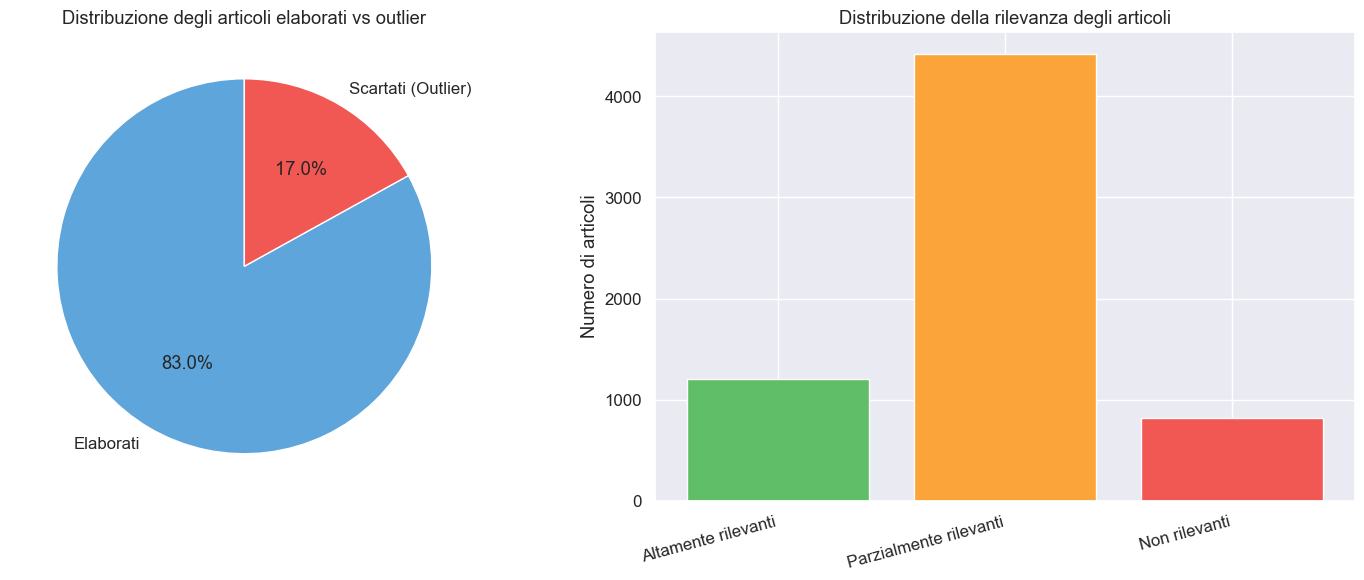

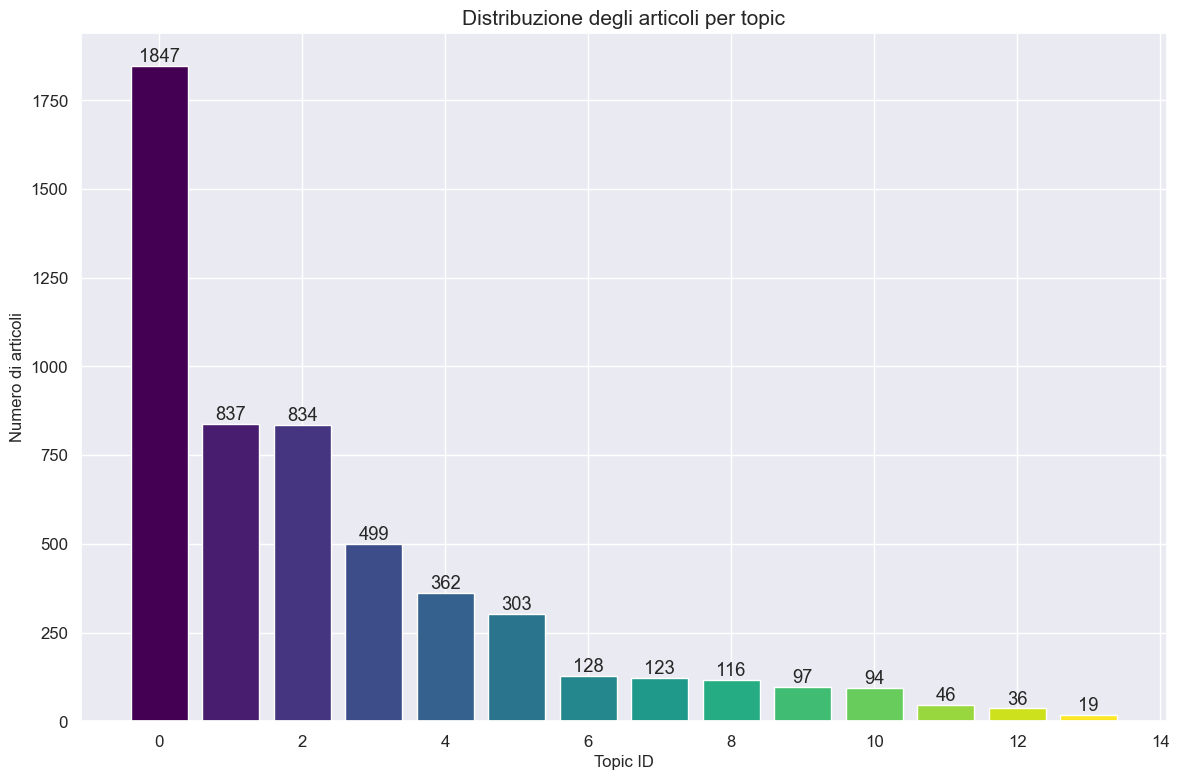

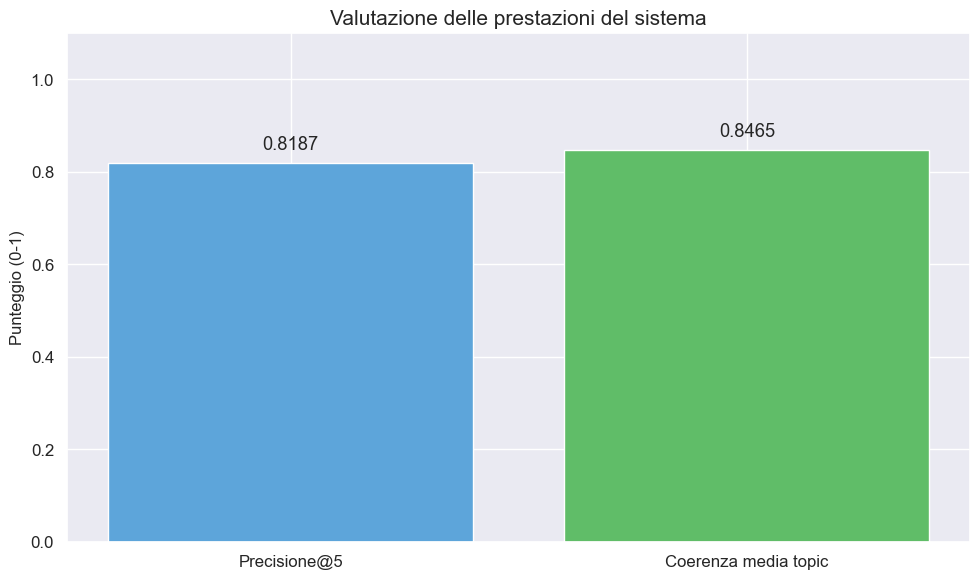

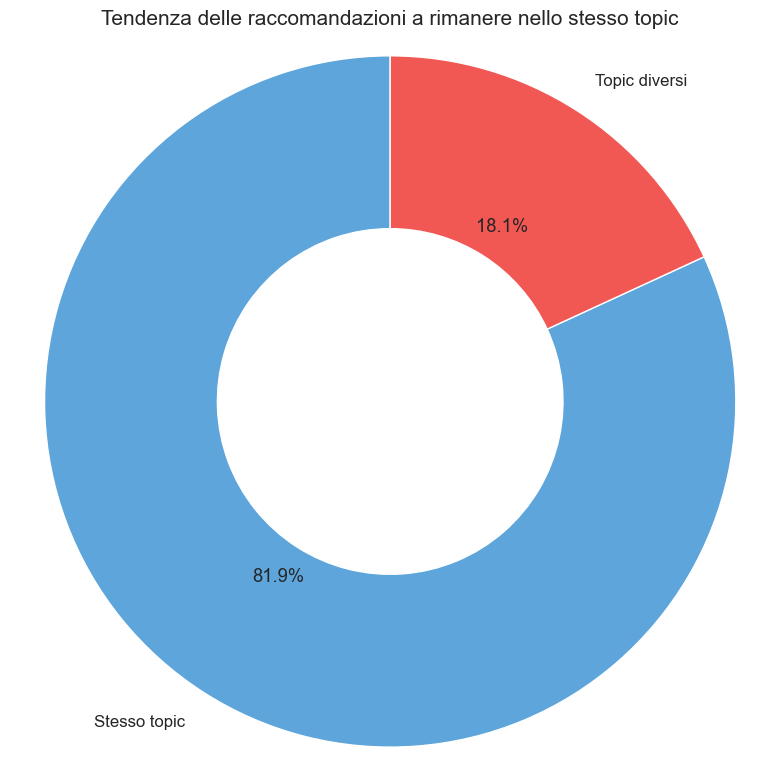

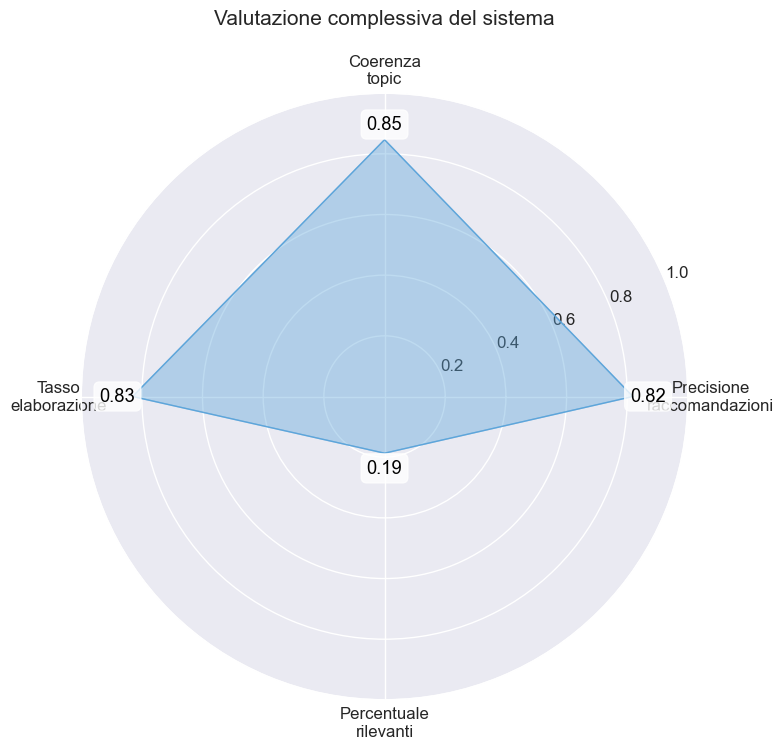

In [144]:
# carico le metrics da file
#metrics=joblib.load('model_metrics.json')
visualize_metrics(metrics)

# INTERFACCIA CON UTENTE

Per avere un interfaccia utilizzare versione python.  
Utilizza il file python con solo la cella di esecuzione per streamfit. (in questo file addestro, nell'altro ho interfaccia)

Per runnare interfaccia interattiva esegui su terminale: 

cd C:\Users\Utente\OneDrive\Desktop\DataScience\DSA 

streamlit run finale_DSA.py
